In [2]:
%load_ext autoreload
%autoreload 2


In [12]:
import networkx as nx
import numpy as np
import cvxpy as cp
from tqdm import tqdm
from pathlib import Path

from src.load_data import (
    read_metadata_networks_tntp,
    read_graph_transport_networks_tntp,
    read_traffic_mat_transport_networks_tntp,
)

from src.models import SDModel, BeckmannModel, TwostageModel
from src.algs import subgd, ustm, frank_wolfe, cyclic, N_conjugate_frank_wolfe 
from src.cvxpy_solvers import get_max_traffic_mat_mul
from src.commons import Correspondences

import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatter


plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'retina'

%matplotlib inline

In [31]:
networks_path = Path("./TransportationNetworks")

folder = "SiouxFalls"
net_name = "SiouxFalls_net"
traffic_mat_name = "SiouxFalls_trips"

# folder = "Anaheim"
# net_name = "Anaheim_net"
# traffic_mat_name = "Anaheim_trips"
    
# folder = "Barcelona"
# net_name = "Barcelona_net"
# traffic_mat_name = "Barcelona_trips"

    
net_file = networks_path / folder / f"{net_name}.tntp"
traffic_mat_file = networks_path / folder / f"{traffic_mat_name}.tntp"
graph, metadata = read_graph_transport_networks_tntp(net_file)
correspondences = read_traffic_mat_transport_networks_tntp(traffic_mat_file, metadata)
n = graph.number_of_nodes()

print(f"{graph.number_of_edges()=}, {graph.number_of_nodes()=}")

metadata["can_pass_through_zones"]=True
graph.number_of_edges()=76, graph.number_of_nodes()=24


In [32]:
beckmann_model = BeckmannModel(graph, correspondences)

eps = 1e-4
mean_bw = beckmann_model.graph.ep.capacities.a.mean()
mean_cost = beckmann_model.graph.ep.free_flow_times.a.mean()

# cost suboptimality <= eps * (average link cost * avg bandwidth * |E| \approx total cost when beta=1)
eps_abs = eps * mean_cost * mean_bw * graph.number_of_edges()

eps_cons_abs = eps * mean_bw 
# sum of capacity violation <= eps * average link capacity
print(eps_abs, eps_cons_abs)

321.76227778320316 1.0247206298828127


# Beckmann

In [5]:
times_e_ustm, flows_e_ustm, logs, optimal = ustm(beckmann_model, eps_abs, max_iter=2000, stop_by_crit=False)
dgap_ustm, cons_log_ustm, time_log_ustm = logs
print(len(dgap_ustm), "shortest paths calls")


100%|██████████| 2000/2000 [00:23<00:00, 86.75it/s]

7946 shortest paths calls


In [6]:
times_e_fw, flows_e_fw, logs, optimal = frank_wolfe(beckmann_model, eps_abs,  max_iter=7700, stop_by_crit=False)
dgap_fw, time_log_fw , primal_r_gap_fw = logs

100%|██████████| 7700/7700 [00:21<00:00, 364.64it/s]


In [7]:
times_e_nfw, flows_e_nfw, logs, optimal = N_conjugate_frank_wolfe(beckmann_model, eps_abs,  max_iter=4000, stop_by_crit=False, cnt_conjugates=3 , linesearch=True)
dgap_nfw, time_log_nfw , primal_r_gap_nfw = logs

100%|██████████| 3999/3999 [00:22<00:00, 181.24it/s]


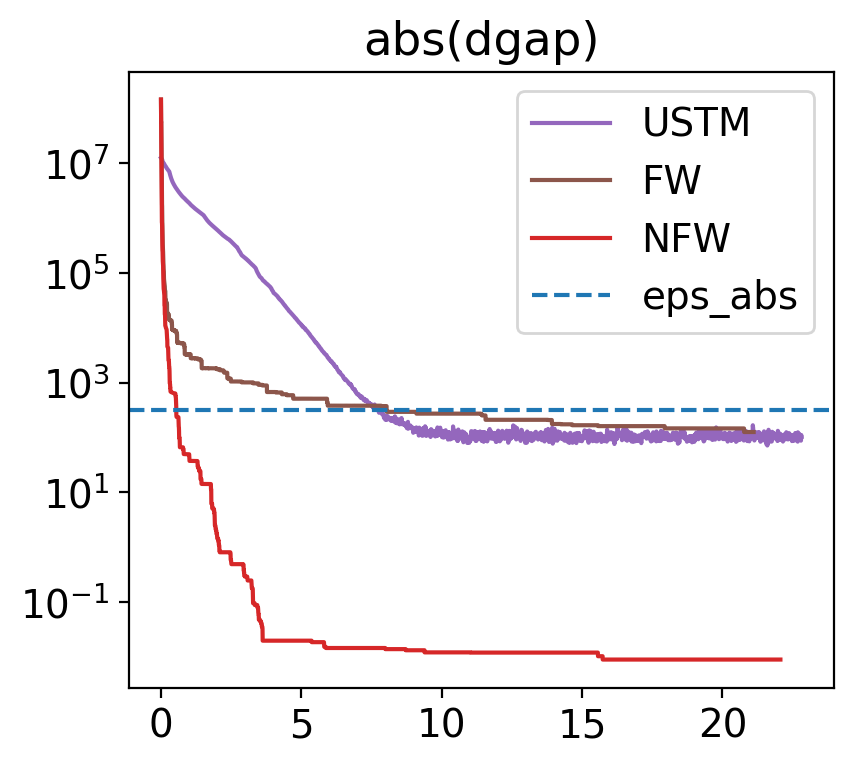

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(121)
dgap_ustm = np.abs(dgap_ustm)
dgap_fw = np.abs(dgap_fw)
dgap_nfw = np.abs(dgap_nfw)
plt.plot(time_log_ustm, dgap_ustm, c="C4", label="USTM")
plt.plot(time_log_fw, dgap_fw, c="C5", label="FW")
plt.plot(time_log_nfw, dgap_nfw, c="C3", label="NFW")
plt.axhline(y=np.ones(max(dgap_ustm.size, dgap_fw.size))[0] * eps_abs, linestyle= '--', label='eps_abs')
plt.yscale("log")
plt.title("abs(dgap)")
plt.legend()


# SD

In [9]:
# %%time

# for Anaheim 18 min on my laptop (for np.ones matrix ~3 min, omg. maybe scaling impacts?). result \approx 0.529
# sd_max_traffic_mul = get_max_traffic_mat_mul(graph, correspondences.traffic_mat, solver=cp.SCS)
sd_max_traffic_mul = 0.529

# for SiouxFalls
# sd_max_traffic_mul = get_max_traffic_mat_mul(graph, correspondences.node_traffic_mat, solver=cp.ECOS, 
#                                              max_iters=1000, verbose=False)

print(f"{sd_max_traffic_mul=},")

corrs = Correspondences(traffic_mat=correspondences.traffic_mat * sd_max_traffic_mul * 0.9,
                        node_traffic_mat=correspondences.node_traffic_mat * sd_max_traffic_mul * 0.9,
                        sources=correspondences.sources,
                        targets=correspondences.targets)

sd_model = SDModel(graph, corrs)
# model = SDModel(graph, traffic_mat * sd_max_traffic_mul * 1.1)  # you should see that constraints error does not converge

sd_max_traffic_mul=0.529,


## cvxpy edge-based

## Ustm

In [10]:
%%time

times_e_ustm, flows_e_ustm, logs, optimal = ustm(sd_model, eps_abs, eps_cons_abs,
                                                                         max_iter=1000, stop_by_crit=True)

dgap_ustm, cons_log_ustm, time_log_ustm = logs
print(len(dgap_ustm), "iters")


100%|██████████| 1000/1000 [00:10<00:00, 93.85it/s]

4008 iters
CPU times: user 10.8 s, sys: 384 ms, total: 11.2 s
Wall time: 10.7 s


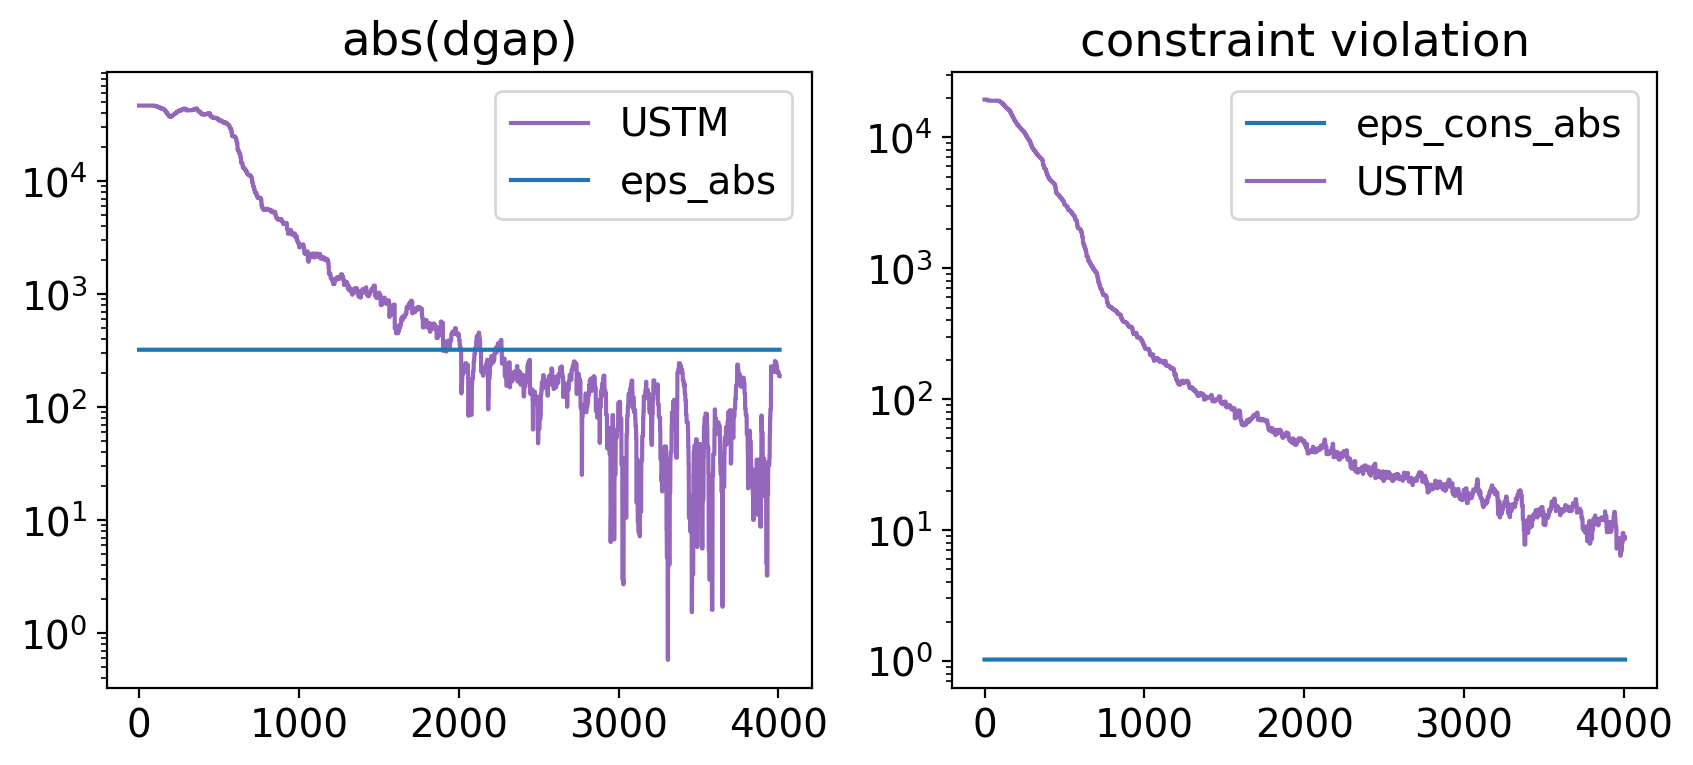

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(121)
dgap_abs = np.abs(dgap_ustm)
plt.plot(dgap_abs, c="C4", label="USTM")
plt.plot(np.ones(dgap_abs.size) * eps_abs, label="eps_abs")
plt.yscale("log")
plt.ylim(None, dgap_abs.max() * 2)
plt.title("abs(dgap)")
plt.legend()

plt.subplot(122)
plt.plot(np.ones(len(cons_log_ustm)) * eps_cons_abs, label="eps_cons_abs")
plt.plot(cons_log_ustm, c="C4", label="USTM")
plt.title("constraint violation")
plt.yscale("log")
plt.legend()

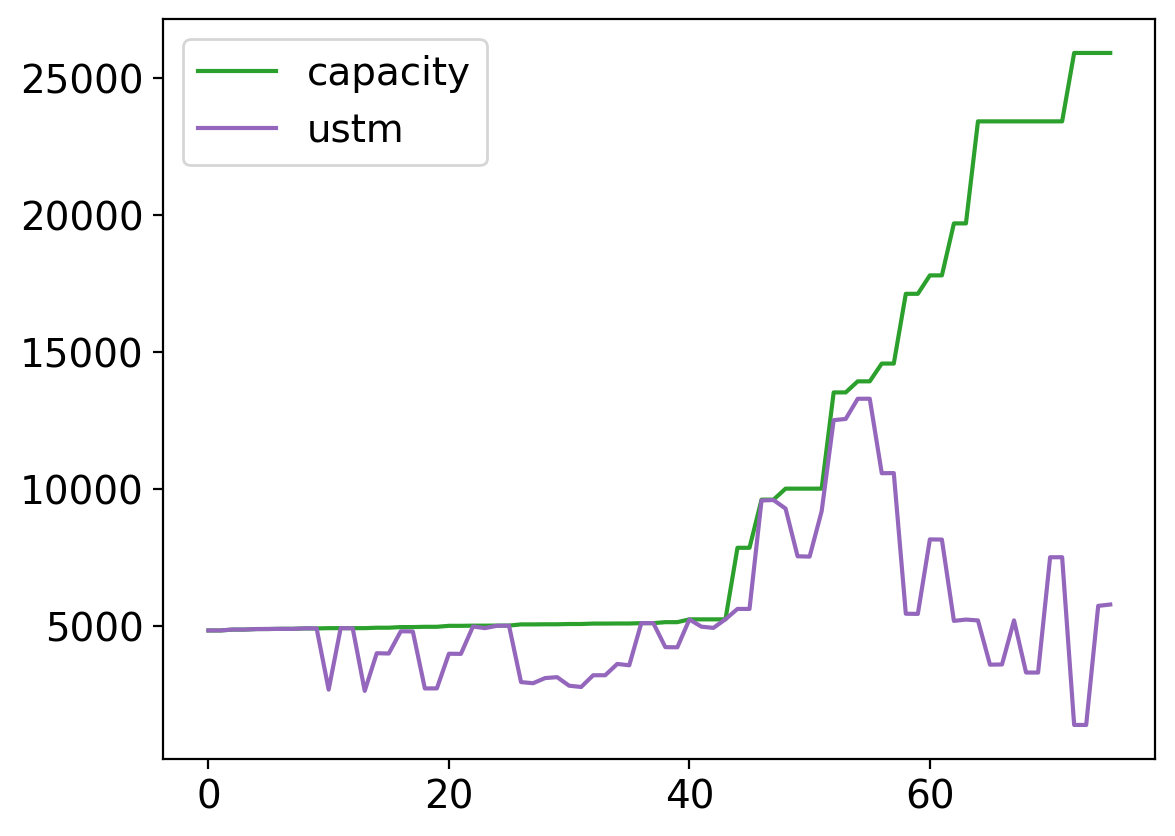

In [12]:
bws = sd_model.graph.ep.capacities.a
order = bws.argsort()

plt.plot(bws[order], label="capacity", c='C2')
# plt.plot(flows_cvx[order], label="cvxpy", c="C1")
plt.plot(flows_e_ustm[order], label="ustm", c="C4")

plt.legend()

# Subgd

In [13]:
%%time

times_e_subgd, flows_e_subgd, logs, optimal = subgd(sd_model, R=10, eps_abs=eps_abs, 
                                                                   eps_cons_abs=eps_cons_abs, max_iter=1000)

dgap_subgd, cons_log_subgd = logs

100%|██████████| 1000/1000 [00:02<00:00, 378.54it/s]

CPU times: user 2.64 s, sys: 66.9 ms, total: 2.71 s
Wall time: 2.64 s


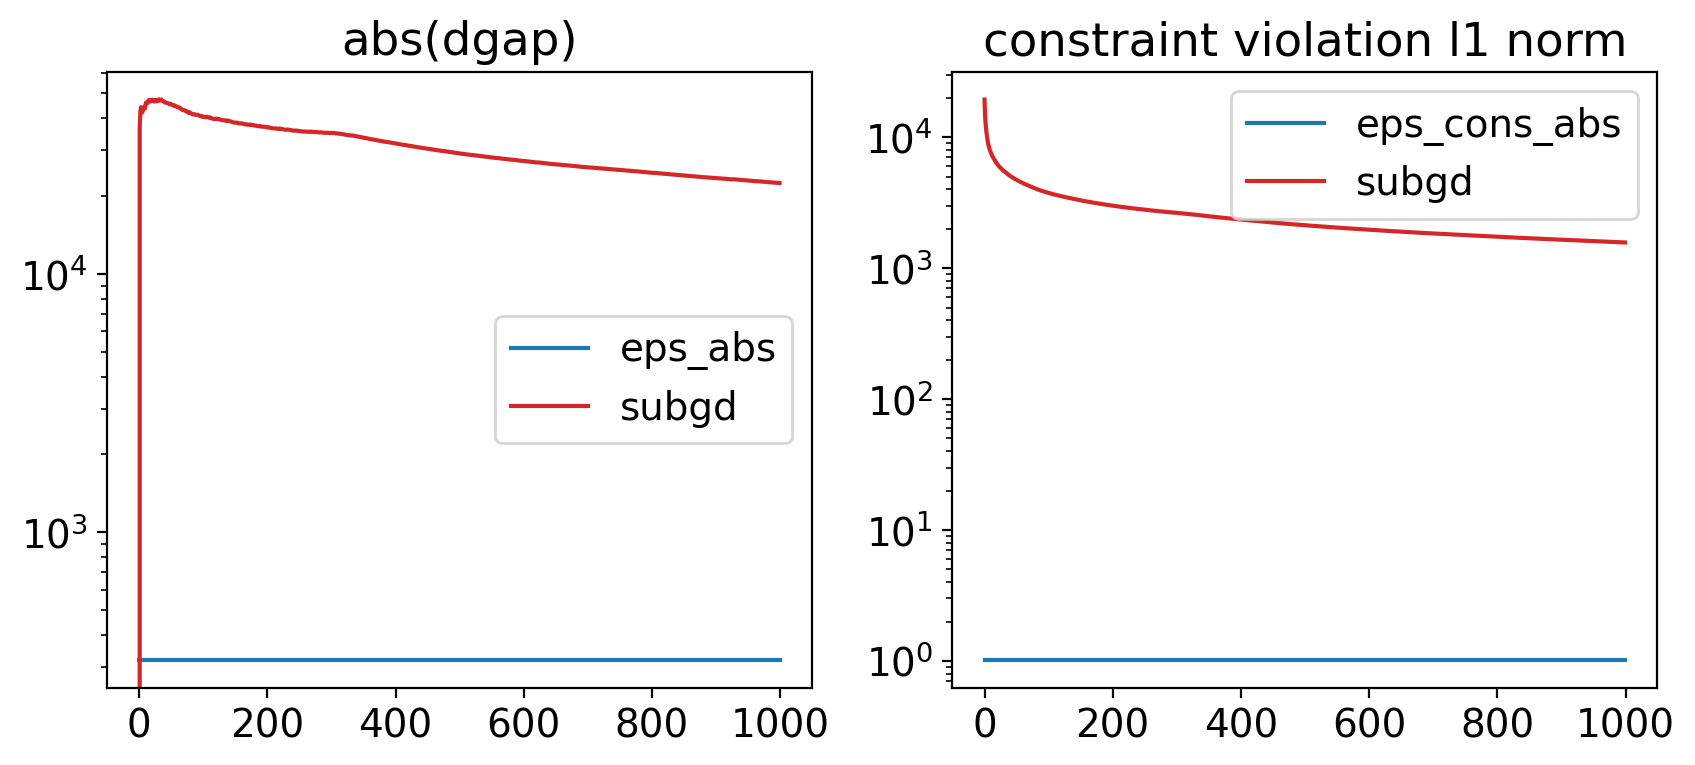

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(121)
dgap_abs = np.abs(dgap_subgd)
plt.plot(np.ones(dgap_abs.size) * eps_abs, label="eps_abs")
plt.plot(dgap_abs, c="C3", label="subgd")
plt.legend()
plt.yscale("log")

plt.title("abs(dgap)")
plt.subplot(122)
plt.plot(np.ones(len(cons_log_subgd)) * eps_cons_abs, label="eps_cons_abs")
plt.plot(cons_log_subgd, c="C3", label="subgd")
plt.legend()
plt.title("constraint violation l1 norm")
plt.yscale("log")


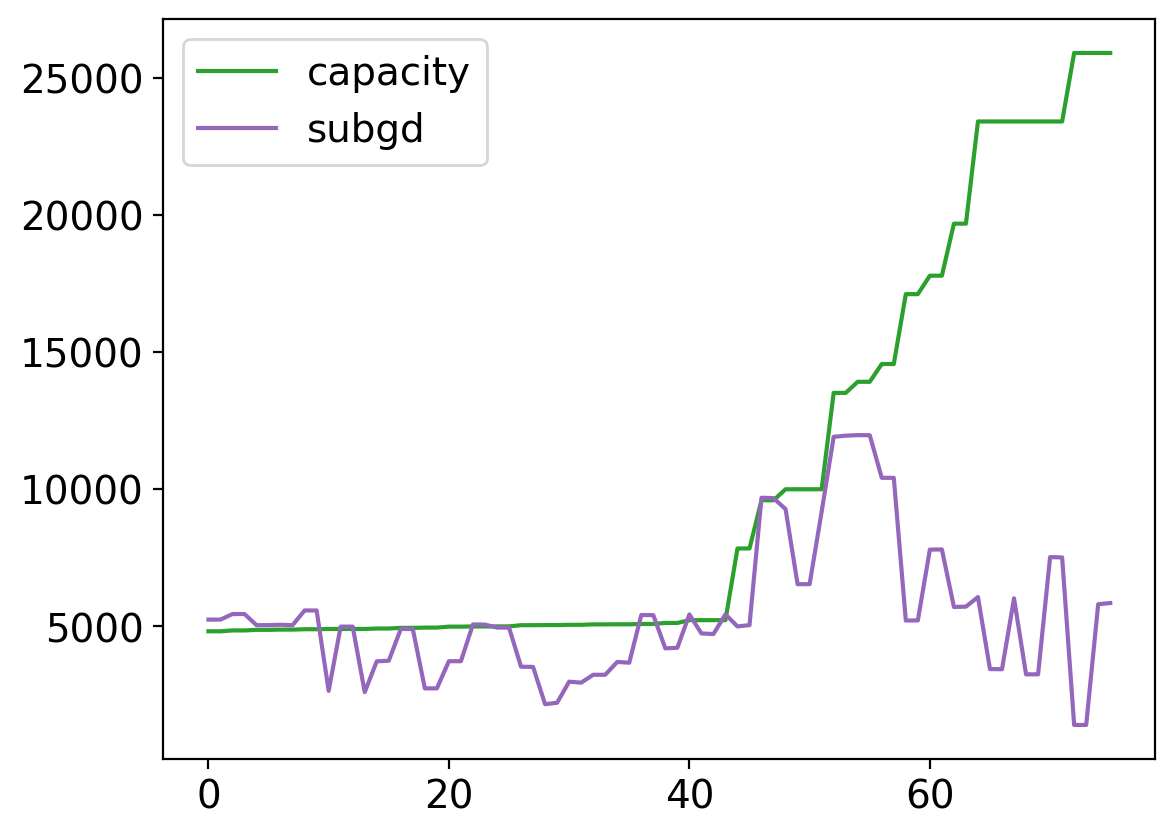

In [15]:
bws = sd_model.graph.ep.capacities.a
order = bws.argsort()

plt.plot(bws[order], label="capacity", c='C2')
# plt.plot(flows_cvx[order], label="cvxpy", c="C1")
plt.plot(flows_e_subgd[order], label="subgd", c="C4")

plt.legend()

# Twostage

In [35]:
times_ustm_2s, primal_var_ustm_2s, logs, optimal = ustm(twostage_beckmann_model, eps_abs=100, max_iter=1000, stop_by_crit=False)
dgap_ustm_2s, cons_log_ustm_2s, time_log_ustm_2s = logs
print(len(dgap_ustm_2s), "iters")

  8%|▊         | 83/1000 [00:02<00:24, 37.02it/s]

KeyboardInterrupt



In [26]:
traffic_mat = beckmann_model.correspondences.traffic_mat.copy() 
departures, arrivals = traffic_mat.sum(axis=1), traffic_mat.sum(axis=0) 
twostage_beckmann_model = TwostageModel(beckmann_model, departures=departures, arrivals=arrivals, gamma=0.1)

print(eps_abs, eps_cons_abs)

321.76227778320316 1.0247206298828127


In [ ]:
from src.admm_stuff import AdmmOracle, combined_admm

l, w = departures, arrivals
admm_oracle = AdmmOracle(twostage_beckmann_model.traffic_model, twostage_beckmann_model.gamma, l, w)

In [122]:
output = cyclic(model=twostage_beckmann_model,
                traffic_assigment_eps_abs=experiment["almost_exact"]["ta_eps_abs"],
                traffic_assigment_max_iter=experiment["almost_exact"]["max_iter"],
                max_iter=experiment["meta"]["cyclic_iters"],
                stop_by_crit=False)

times_e_best, flows_e_best, d_ij_best, logs, optimal = output
times, dgaps = logs[2], logs[0]
experiment["almost_exact"]["times"] = times
experiment["almost_exact"]["dgaps"] = dgaps 

100%|██████████| 20/20 [00:53<00:00,  2.70s/it]


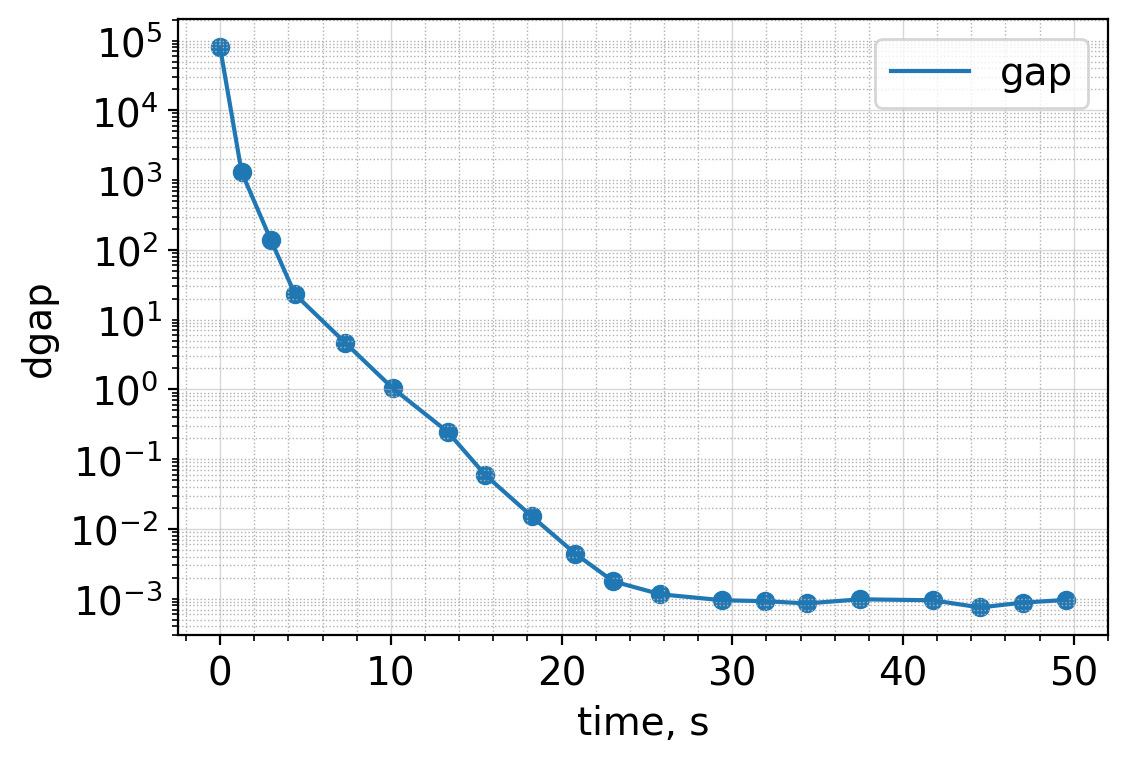

In [123]:
times, dgaps = experiment["almost_exact"]["times"], experiment["almost_exact"]["dgaps"]
ax = plt.figure(figsize=(6,4)).add_subplot(1, 1, 1)
ax.plot(times, dgaps, label=f"gap")
ax.scatter(times, dgaps)

ax.minorticks_on(), ax.set_yscale("log"), ax.set_ylabel("dgap"), ax.set_xlabel("time, s")
minor_locator = LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=12)
ax.yaxis.set_minor_locator(minor_locator)
ax.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5)
ax.grid(which='minor', linestyle=':', linewidth='0.5', alpha=1) 
_ = ax.legend(), plt.show()

In [176]:
comment = "3FW in cyclic"
ta_epss = list(10.0 ** np.arange(2, -1, -1))
# agd_kwargs = dict(eps_abs=1e-4, iters=1000, M0=10)
# salim_kwargs = dict(eps_abs=1e-5, iters=1000, mu=0.01, L=1)
experiment = {"meta": {"network": folder, "description": comment, },
#        "almost_exact" : {"max_iter": 10_000, "ta_eps_abs": 1e-2},
        "cyclic_big_iters": 15,
        "cyclic_ta_iters": 10_000,
        "ta_epss" : ta_epss,
        "dgapss" : None,
        "timess" : None,
        "distss" : None,
        "salim_kwargs" : dict(mu=1e-4, L=1,lam2=l.size, lam1=3*l.size),
        "salim_iters" : 2000,
        "salim_exact_iters" : 5000,
        "salim_exact_cons" : None,
        "salim_exact_opt" : None,
        "salim_times" : None,
        "salim_dists" : None,
        }

In [177]:
from src.admm_stuff import combined_salim

output = combined_salim(admm_oracle, **experiment["salim_kwargs"], iters=experiment["salim_exact_iters"],
#                solution_corrs=d_ij_best,
#                solution_flows=flows_e_best,
               plot_convergence=False)
corrs_best, flows_best, yK_s, yAB_s, dists_s, times_s, pri_res, opt = output
flows_best = flows_best.sum(axis=1)

experiment["salim_exact_times"], experiment["salim_exact_cons"], experiment["salim_exact_opt"] = times_s, pri_res, opt

salim 4999


/home/demyan/reps/mmo_tm/src/admm_stuff.py:314: RuntimeWarning: Salim reached iter limit
  if i == iters - 1:


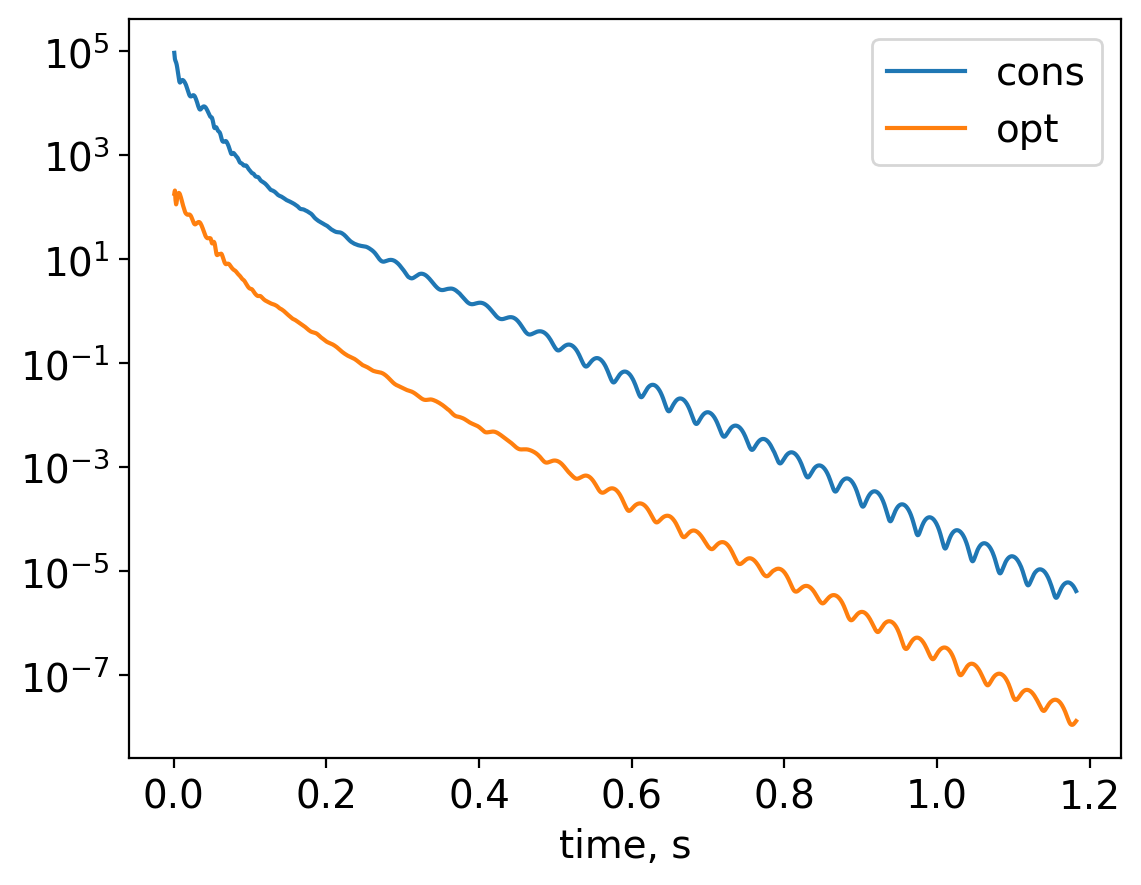

In [178]:
plt.plot(experiment["salim_exact_times"], experiment["salim_exact_cons"], label="cons")
plt.plot(experiment["salim_exact_times"], experiment["salim_exact_opt"], label="opt")
plt.legend()
plt.xlabel("time, s")
plt.yscale("log")

In [179]:
output = combined_salim(admm_oracle, **experiment["salim_kwargs"], iters=experiment["salim_iters"],
               solution_corrs=d_ij_best,
               solution_flows=flows_e_best,
               )
corrs_best, flows_best, yK_s, yAB_s, dists_s, times_s, pri_res, opt = output
flows_best = flows_best.sum(axis=1)

experiment["salim_times"], experiment["salim_dists"] = times_s, dists_s

salim 1999


In [180]:
dgapss = []
timess = []
distss = []

for ta_eps in experiment["ta_epss"]:
    times_e_cyclic, flows_e_cyclic, d_ij_cyclic, logs, optimal = cyclic(model=twostage_beckmann_model, 
                                                                    traffic_assigment_eps_abs=ta_eps, 
                                                                    traffic_assigment_max_iter=experiment["cyclic_ta_iters"], 
                                                                    max_iter=experiment["cyclic_iters"], 
                                                                    stop_by_crit=False,
                                                                    solution_flows=flows_best,
                                                                    solution_corrs=corrs_best,
                                                                    )
    dgap_cyclic, cons_log_cyclic, time_log_cyclic, dist_flows_log, dist_corrs_log = logs
    
    dgapss.append(dgap_cyclic)    
    timess.append(time_log_cyclic)    
    distss.append((np.array(dist_flows_log) ** 2 + np.array(dist_corrs_log) ** 2) ** 0.5)
    
experiment["dgapss"] = dgapss
experiment["timess"] = timess 
experiment["distss"] = distss 

KeyError: 'cyclic_iters'

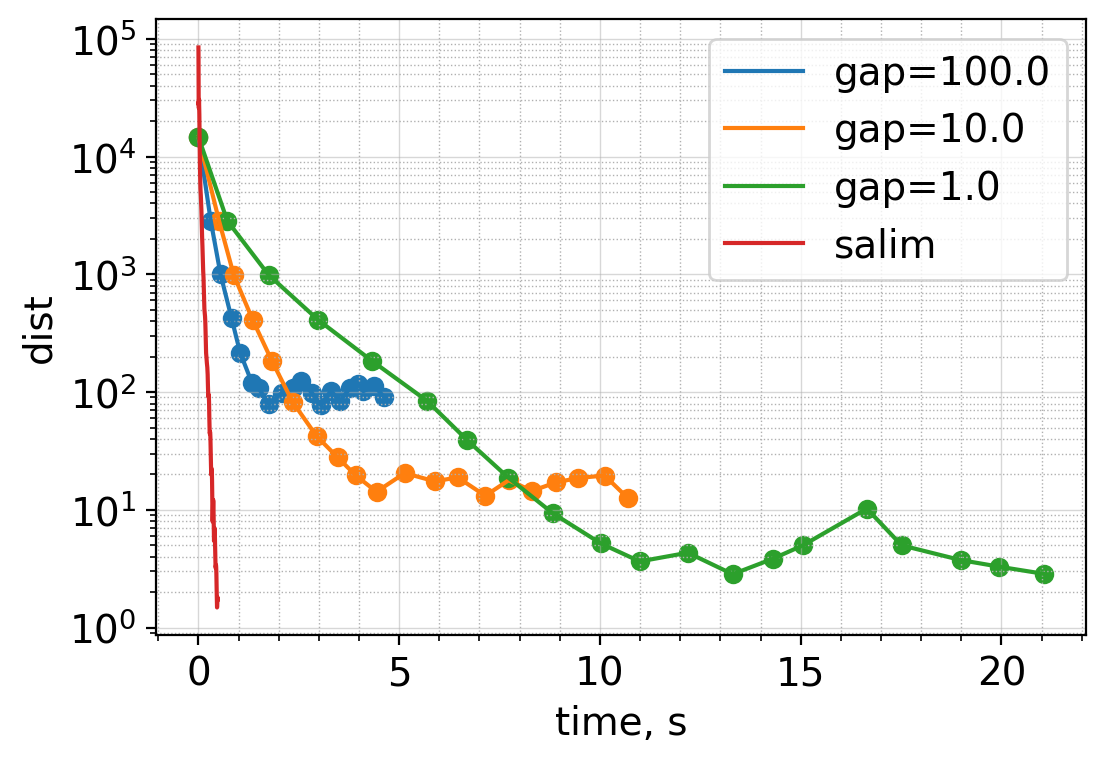

In [175]:
ax = plt.figure(figsize=(6,4)).add_subplot(1, 1, 1)
# ticks = ((10.0 ** np.arange(-1, 5, 1))[:, np.newaxis] * np.arange(1, 10, 3)).flatten()

ta_epss = experiment["ta_epss"]
for i in range(len(ta_epss)):
    times, dists = experiment["timess"][i], experiment["distss"][i] 
    ax.plot(times, dists, label=f"gap={ta_epss[i]}")
    ax.scatter(times, dists)
# plt.plot(time_log_ustm_2s, dgap_ustm_2s, c="C6", label="ustm")

# ax.plot(experiment["admm_times"], experiment["admm_dists"], label="admm")
ax.plot(experiment["salim_times"], experiment["salim_dists"], label="salim")
# ax.scatter(admm_times, admm_dists)

# Enable minor ticks
ax.minorticks_on()

# Set the y-axis to log scale
ax.set_yscale("log")
# ax.set_xscale("log")

# Set labels for axes
ax.set_ylabel("dist")
ax.set_xlabel("time, s")

minor_locator = LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=12)
ax.yaxis.set_minor_locator(minor_locator)

# Set grid for both major and minor grid lines
ax.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5)
ax.grid(which='minor', linestyle=':', linewidth='0.5', alpha=1) 

# Add legend
ax.legend()

# Display the plot
plt.show()

  0%|          | 0/3000 [00:00<?, ?it/s]

flows agd: 32572.21585304059 M= 5.0e+00
flows agd: 0.4461260952483021 M= 2.5e+00
flows agd: 0.049324639636309446 M= 2.5e+00


  0%|          | 1/3000 [00:00<22:19,  2.24it/s]

flows agd: 0.015611989260795144 M= 1.2e+00
flows agd: 0.010799860660719675 M= 2.5e+00
agd 999
salim 362
flows agd: 49.25215295967325 M= 5.0e+00
flows agd: 0.13505778920299794 M= 2.5e+00
flows agd: 0.028349099432476377 M= 2.5e+00
flows agd: 0.015293036410622768 M= 1.2e+00


  0%|          | 2/3000 [00:00<22:03,  2.27it/s]

flows agd: 0.004948185327844343 M= 1.2e+00
agd 999
salim 354
flows agd: 40.8349428689501 M= 5.0e+00
flows agd: 0.11286130456585944 M= 1.2e+00
flows agd: 0.023416152735684516 M= 1.2e+00
flows agd: 0.010631897385094352 M= 1.2e+00
flows agd: 0.004094631518789257 M= 1.2e+00


  0%|          | 3/3000 [00:01<21:57,  2.28it/s]

agd 999
salim 355
flows agd: 40.81759091862334 M= 5.0e+00
flows agd: 0.17094762262134433 M= 2.5e+00
flows agd: 0.03454894608074057 M= 2.5e+00
flows agd: 0.013530305144276642 M= 2.5e+00
flows agd: 0.010709914700799081 M= 1.2e+00
agd 999


  0%|          | 4/3000 [00:01<22:13,  2.25it/s]

salim 356
flows agd: 35.994498291799374 M= 5.0e+00
flows agd: 0.2208915530684649 M= 2.5e+00
flows agd: 0.042418322676955014 M= 2.5e+00


  0%|          | 5/3000 [00:02<22:07,  2.26it/s]

flows agd: 0.01569048917559276 M= 2.5e+00
flows agd: 0.005682932132168976 M= 2.5e+00
agd 999
salim 357
flows agd: 30.806234460296928 M= 5.0e+00
flows agd: 0.2470063046482353 M= 2.5e+00
flows agd: 0.09608361824693296 M= 1.2e+00
flows agd: 0.025283022821455337 M= 1.2e+00


  0%|          | 6/3000 [00:02<22:04,  2.26it/s]

flows agd: 0.011926954747241912 M= 1.2e+00
agd 999
salim 358
flows agd: 26.761645114346724 M= 5.0e+00
flows agd: 0.08751244270669144 M= 2.5e+00
flows agd: 0.015272506862008732 M= 2.5e+00
flows agd: 0.00866922174039805 M= 1.2e+00
flows agd: 0.0017847977950272913 M= 2.5e+00


  0%|          | 7/3000 [00:03<21:57,  2.27it/s]

agd 999
salim 358
flows agd: 23.739823416463214 M= 5.0e+00
flows agd: 0.11126808301227469 M= 2.5e+00
flows agd: 0.025578522837535884 M= 2.5e+00


  0%|          | 8/3000 [00:03<21:53,  2.28it/s]

flows agd: 0.013540774336161231 M= 1.2e+00
flows agd: 0.004182707134844143 M= 1.2e+00
agd 999
salim 359
flows agd: 21.39948330177453 M= 5.0e+00
flows agd: 0.1406053278757308 M= 2.5e+00
flows agd: 0.024161441461133804 M= 2.5e+00
flows agd: 0.00772978854929655 M= 2.5e+00


  0%|          | 9/3000 [00:03<21:56,  2.27it/s]

flows agd: 0.004931415975857635 M= 1.2e+00
agd 999
salim 359
flows agd: 19.637293937370693 M= 5.0e+00
flows agd: 0.11711134831105392 M= 1.2e+00
flows agd: 0.024744107257127206 M= 1.2e+00
flows agd: 0.01396537675593875 M= 2.5e+00
flows agd: 0.005149038551321932 M= 2.5e+00


  0%|          | 10/3000 [00:04<21:54,  2.27it/s]

agd 999
salim 359
flows agd: 18.306460408573592 M= 5.0e+00
flows agd: 0.1368052502678759 M= 2.5e+00
flows agd: 0.04484311903451632 M= 1.2e+00


  0%|          | 11/3000 [00:04<21:50,  2.28it/s]

flows agd: 0.01572332574124187 M= 1.2e+00
flows agd: 0.009432654350316982 M= 2.5e+00
agd 999
salim 359
flows agd: 17.275245677198857 M= 5.0e+00
flows agd: 0.18532767667302744 M= 1.2e+00
flows agd: 0.06289084610911161 M= 2.5e+00
flows agd: 0.02073417767174596 M= 2.5e+00


  0%|          | 12/3000 [00:05<22:02,  2.26it/s]

flows agd: 0.012289795405835418 M= 1.2e+00
agd 999
salim 360
flows agd: 16.359208279274206 M= 5.0e+00
flows agd: 0.1754812074902547 M= 2.5e+00
flows agd: 0.052808698529126806 M= 1.2e+00
flows agd: 0.0181671268113837 M= 1.2e+00


  0%|          | 13/3000 [00:05<22:17,  2.23it/s]

flows agd: 0.005127514767436699 M= 1.2e+00
agd 999
salim 360
flows agd: 15.515064036474053 M= 5.0e+00
flows agd: 0.7462747925676968 M= 2.5e+00
flows agd: 0.11219776101644806 M= 2.5e+00
flows agd: 0.02527066527888174 M= 2.5e+00


  0%|          | 14/3000 [00:06<22:08,  2.25it/s]

flows agd: 0.015890446110092604 M= 1.2e+00
agd 999
salim 360
flows agd: 14.735065704784127 M= 5.0e+00
flows agd: 0.012759958065838127 M= 2.5e+00
flows agd: 0.0024706344046183004 M= 2.5e+00
flows agd: 0.0028399813063740838 M= 2.5e+00
flows agd: 0.001694398303602289 M= 1.2e+00


  0%|          | 15/3000 [00:06<22:06,  2.25it/s]

agd 999
salim 360
flows agd: 14.036211883811948 M= 5.0e+00
flows agd: 0.10521529934773105 M= 1.2e+00
flows agd: 0.030730057600455926 M= 2.5e+00


  1%|          | 16/3000 [00:07<22:00,  2.26it/s]

flows agd: 0.014917893568875658 M= 1.2e+00
flows agd: 0.005082087186097737 M= 1.2e+00
agd 999
salim 360
flows agd: 13.368979855879866 M= 5.0e+00
flows agd: 0.14627027700235315 M= 1.2e+00
flows agd: 0.036570026610101974 M= 2.5e+00
flows agd: 0.017019432802377686 M= 1.2e+00


  1%|          | 17/3000 [00:07<22:01,  2.26it/s]

flows agd: 0.00981644346325819 M= 2.5e+00
agd 999
salim 360
flows agd: 12.750915081893336 M= 5.0e+00
flows agd: 0.09902037066830136 M= 2.5e+00
flows agd: 0.046817857556857724 M= 2.5e+00
flows agd: 0.011706949981502625 M= 1.2e+00
flows agd: 0.01098683958822637 M= 1.2e+00


  1%|          | 18/3000 [00:07<22:05,  2.25it/s]

agd 999
salim 360
flows agd: 12.195103634149707 M= 5.0e+00
flows agd: 0.006976994413467714 M= 1.2e+00
flows agd: 0.0032571089522258224 M= 1.2e+00


  1%|          | 19/3000 [00:08<21:53,  2.27it/s]

flows agd: 0.0011050620119605868 M= 2.5e+00
flows agd: 0.0003477283209601797 M= 1.2e+00
agd 999
salim 360
flows agd: 11.689690471705703 M= 5.0e+00
flows agd: 0.0850547741957622 M= 2.5e+00
flows agd: 0.017632155981164677 M= 1.2e+00
flows agd: 0.010393874625970627 M= 1.2e+00


  1%|          | 20/3000 [00:08<21:48,  2.28it/s]

flows agd: 0.003926208438157828 M= 2.5e+00
agd 999
salim 360
flows agd: 11.241155391940943 M= 5.0e+00
flows agd: 0.0035640524626162047 M= 2.5e+00


  1%|          | 21/3000 [00:09<20:08,  2.46it/s]

flows agd: 0.001245841850281813 M= 2.5e+00
flows agd: 0.0004259799588502037 M= 1.2e+00
agd 731
salim 360
flows agd: 10.861801482001267 M= 5.0e+00
flows agd: 0.00325753170250017 M= 2.5e+00
flows agd: 0.0011357635381867644 M= 2.5e+00
flows agd: 0.00039429776670077746 M= 1.2e+00


  1%|          | 22/3000 [00:09<19:21,  2.56it/s]

agd 730
salim 360
flows agd: 10.499494466132335 M= 5.0e+00
flows agd: 0.0030237268122615215 M= 2.5e+00


  1%|          | 23/3000 [00:09<18:11,  2.73it/s]

flows agd: 0.0010797382693711315 M= 2.5e+00
flows agd: 0.00037232182354702745 M= 1.2e+00
agd 672
salim 360
flows agd: 10.163623876542346 M= 5.0e+00
flows agd: 0.002980389044160892 M= 2.5e+00
flows agd: 0.001050978646207461 M= 2.5e+00
flows agd: 0.0007675046528618146 M= 2.5e+00
agd 675


  1%|          | 24/3000 [00:10<17:29,  2.83it/s]

salim 360
flows agd: 9.850827224571072 M= 5.0e+00
flows agd: 0.0028534089332305536 M= 2.5e+00
flows agd: 0.0010008646784950424 M= 2.5e+00


  1%|          | 25/3000 [00:10<17:50,  2.78it/s]

flows agd: 0.0007313338642448615 M= 2.5e+00
agd 795
salim 360
flows agd: 9.558041467699264 M= 5.0e+00
flows agd: 0.0027485299016363233 M= 2.5e+00
flows agd: 0.0009574845461416852 M= 2.5e+00
flows agd: 0.0007001064136683593 M= 2.5e+00


  1%|          | 26/3000 [00:10<17:16,  2.87it/s]

agd 685
salim 360
flows agd: 9.283627025883991 M= 5.0e+00
flows agd: 0.002674379955754315 M= 2.5e+00


  1%|          | 27/3000 [00:11<16:53,  2.93it/s]

flows agd: 0.0009228062407553022 M= 2.5e+00
flows agd: 0.000670939928049696 M= 2.5e+00
agd 681
salim 360
flows agd: 9.025797001331112 M= 5.0e+00
flows agd: 0.0026062827416536405 M= 2.5e+00
flows agd: 0.0009029227006622256 M= 2.5e+00
flows agd: 0.0006488095919566068 M= 2.5e+00


  1%|          | 28/3000 [00:11<16:47,  2.95it/s]

agd 684
salim 360
flows agd: 8.780916347079017 M= 5.0e+00
flows agd: 0.0025374403486464986 M= 2.5e+00
flows agd: 0.0008883728523251638 M= 2.5e+00


  1%|          | 29/3000 [00:11<16:32,  2.99it/s]

flows agd: 0.0006320611969597505 M= 2.5e+00
agd 687
salim 360
flows agd: 8.548264252452014 M= 5.0e+00
flows agd: 0.002466356526994651 M= 2.5e+00


  1%|          | 30/3000 [00:12<16:27,  3.01it/s]

flows agd: 0.0008577843465954771 M= 2.5e+00
flows agd: 0.0006110208056971808 M= 2.5e+00
agd 684
salim 360
flows agd: 8.323257456946786 M= 5.0e+00
flows agd: 0.002402426022282825 M= 2.5e+00
flows agd: 0.000831556612446335 M= 2.5e+00
flows agd: 0.0005892337454498497 M= 2.5e+00


  1%|          | 31/3000 [00:12<17:35,  2.81it/s]

flows agd: 0.0001738034231067722 M= 1.2e+00
agd 875
salim 359
flows agd: 8.10591260225084 M= 5.0e+00
flows agd: 0.0023458996541987735 M= 2.5e+00
flows agd: 0.0008085192062628645 M= 2.5e+00
flows agd: 0.0005701858270428838 M= 2.5e+00
flows agd: 0.0001705553561353047 M= 1.2e+00


  1%|          | 32/3000 [00:12<18:31,  2.67it/s]

agd 928
salim 347
flows agd: 7.895556561404712 M= 5.0e+00
flows agd: 0.002317052818504726 M= 2.5e+00


  1%|          | 33/3000 [00:13<17:48,  2.78it/s]

flows agd: 0.0007901437411886838 M= 2.5e+00
flows agd: 0.000549415379833414 M= 2.5e+00
agd 698
salim 347
flows agd: 7.690882447896852 M= 5.0e+00
flows agd: 0.002256032282867481 M= 2.5e+00
flows agd: 0.0007605687400642433 M= 2.5e+00
flows agd: 0.00026128440710790124 M= 1.2e+00
agd 698


  1%|          | 34/3000 [00:13<17:12,  2.87it/s]

salim 347
flows agd: 7.491491603454038 M= 5.0e+00
flows agd: 0.0021944122214320964 M= 2.5e+00
flows agd: 0.0007337520575315025 M= 2.5e+00


  1%|          | 35/3000 [00:13<17:09,  2.88it/s]

flows agd: 0.0005221517102439747 M= 2.5e+00
agd 698
salim 346
flows agd: 7.295566059201838 M= 5.0e+00
flows agd: 0.002100110095735847 M= 2.5e+00


  1%|          | 36/3000 [00:14<16:58,  2.91it/s]

flows agd: 0.0006986634366594047 M= 2.5e+00
flows agd: 0.00023520342524245094 M= 1.2e+00
agd 701
salim 346
flows agd: 7.10713072718511 M= 5.0e+00
flows agd: 0.002006809795326494 M= 2.5e+00
flows agd: 0.0006625759379202356 M= 2.5e+00
flows agd: 0.000221562242482493 M= 1.2e+00
agd 646


  1%|          | 37/3000 [00:14<16:40,  2.96it/s]

salim 346
flows agd: 6.925483354942708 M= 5.0e+00
flows agd: 0.0019432496272814236 M= 2.5e+00
flows agd: 0.000639408349159392 M= 2.5e+00


  1%|▏         | 38/3000 [00:14<16:53,  2.92it/s]

flows agd: 0.00021463680020357206 M= 1.2e+00
agd 711
salim 346
flows agd: 6.748815625370872 M= 5.0e+00
flows agd: 0.0018707857157475461 M= 2.5e+00


  1%|▏         | 39/3000 [00:15<16:29,  2.99it/s]

flows agd: 0.0006121442271625506 M= 2.5e+00
flows agd: 0.00020439506469639026 M= 1.2e+00
agd 652
salim 346
flows agd: 6.576664513243315 M= 5.0e+00
flows agd: 0.0018019671509039985 M= 2.5e+00
flows agd: 0.0005864794116227783 M= 2.5e+00
flows agd: 0.0001939446079461959 M= 1.2e+00
agd 652


  1%|▏         | 40/3000 [00:15<16:13,  3.04it/s]

salim 346
flows agd: 6.409268270164977 M= 5.0e+00
flows agd: 0.0017279349778766388 M= 2.5e+00
flows agd: 0.0005583821281858087 M= 2.5e+00


  1%|▏         | 41/3000 [00:15<15:57,  3.09it/s]

flows agd: 0.00018312188327196025 M= 1.2e+00
agd 651
salim 346
flows agd: 6.246454621054195 M= 5.0e+00
flows agd: 0.0016648161729525056 M= 2.5e+00


  1%|▏         | 42/3000 [00:16<15:32,  3.17it/s]

flows agd: 0.0005333200358205693 M= 2.5e+00
flows agd: 0.0001729550158866376 M= 1.2e+00
agd 648
salim 346
flows agd: 6.088472464805183 M= 5.0e+00
flows agd: 0.001604597331308989 M= 2.5e+00
flows agd: 0.0005116908067880451 M= 2.5e+00
flows agd: 0.0001650474298605625 M= 1.2e+00
agd 648


  1%|▏         | 43/3000 [00:16<15:25,  3.19it/s]

salim 345
flows agd: 5.935573025160178 M= 5.0e+00
flows agd: 0.0015350538130418881 M= 2.5e+00
flows agd: 0.0004873626015552998 M= 2.5e+00


  1%|▏         | 44/3000 [00:16<15:18,  3.22it/s]

flows agd: 0.00015589097055485472 M= 1.2e+00
agd 650
salim 345
flows agd: 5.787745318883109 M= 5.0e+00
flows agd: 0.002086252154179583 M= 1.2e+00


  2%|▏         | 45/3000 [00:17<15:24,  3.20it/s]

flows agd: 0.000412278004758002 M= 2.5e+00
flows agd: 0.0001310935684826628 M= 1.2e+00
agd 657
salim 345
flows agd: 5.644813984555218 M= 5.0e+00
flows agd: 0.001767734935282166 M= 1.2e+00
flows agd: 0.0003479383194400961 M= 2.5e+00
flows agd: 0.00023154468705713938 M= 2.5e+00
agd 601


  2%|▏         | 46/3000 [00:17<15:05,  3.26it/s]

salim 345
flows agd: 5.506775533756049 M= 5.0e+00
flows agd: 0.001703227253447173 M= 1.2e+00
flows agd: 0.000334357781111999 M= 2.5e+00


  2%|▏         | 47/3000 [00:17<14:22,  3.42it/s]

agd 543
salim 345
flows agd: 5.373349292445287 M= 5.0e+00
flows agd: 0.0016208823004562113 M= 1.2e+00
flows agd: 0.0003186813087129891 M= 2.5e+00


  2%|▏         | 48/3000 [00:17<13:52,  3.55it/s]

agd 539
salim 345
flows agd: 5.2446831783381365 M= 5.0e+00
flows agd: 0.0015440051333546246 M= 1.2e+00


  2%|▏         | 49/3000 [00:18<13:36,  3.62it/s]

flows agd: 0.00030398054807628534 M= 2.5e+00
agd 539
salim 345
flows agd: 5.120370933036829 M= 5.0e+00
flows agd: 0.0014989930153124671 M= 1.2e+00


  2%|▏         | 50/3000 [00:18<13:24,  3.67it/s]

flows agd: 0.00028742238275875385 M= 2.5e+00
agd 541
salim 345
flows agd: 5.000749893948988 M= 5.0e+00
flows agd: 0.0014653556359827133 M= 1.2e+00


  2%|▏         | 51/3000 [00:18<13:57,  3.52it/s]

flows agd: 0.00028330828551127393 M= 2.5e+00
flows agd: 0.0002898641737977619 M= 1.2e+00
agd 655
salim 345
flows agd: 4.885722766364226 M= 5.0e+00
flows agd: 0.0014214786381108952 M= 1.2e+00
flows agd: 0.0005842898555507916 M= 1.2e+00
flows agd: 0.00029840811530739217 M= 1.2e+00
agd 670


  2%|▏         | 52/3000 [00:19<14:30,  3.39it/s]

salim 345
flows agd: 4.773951292808688 M= 5.0e+00
flows agd: 0.0013552285797122344 M= 1.2e+00
flows agd: 0.0005548381454132336 M= 1.2e+00


  2%|▏         | 53/3000 [00:19<15:27,  3.18it/s]

flows agd: 0.00028456412951935445 M= 1.2e+00
agd 786
salim 345
flows agd: 4.665671834657013 M= 5.0e+00
flows agd: 0.0012402757236407798 M= 1.2e+00


  2%|▏         | 54/3000 [00:19<15:32,  3.16it/s]

flows agd: 0.00024041754257283346 M= 2.5e+00
flows agd: 0.00026420445088482875 M= 1.2e+00
agd 669
salim 345
flows agd: 4.5607337415933005 M= 5.0e+00
flows agd: 0.0011738090368510472 M= 1.2e+00
flows agd: 0.00022911061637151324 M= 2.5e+00
flows agd: 0.00016214125563598274 M= 2.5e+00
agd 668


  2%|▏         | 55/3000 [00:20<15:28,  3.17it/s]

salim 345
flows agd: 4.459372613581404 M= 5.0e+00
flows agd: 0.0010818801885711601 M= 1.2e+00
flows agd: 0.00020619060412206398 M= 2.5e+00


  2%|▏         | 56/3000 [00:20<15:22,  3.19it/s]

flows agd: 0.00014011407364079815 M= 2.5e+00
agd 668
salim 345
flows agd: 4.361968121095114 M= 5.0e+00
flows agd: 0.001024023891078512 M= 1.2e+00


  2%|▏         | 57/3000 [00:20<15:19,  3.20it/s]

flows agd: 0.0001969421129030516 M= 2.5e+00
flows agd: 0.00013193829713662418 M= 2.5e+00
agd 662
salim 345
flows agd: 4.2680918560262455 M= 5.0e+00
flows agd: 0.0009681078378474277 M= 1.2e+00
flows agd: 0.00018618240306921298 M= 2.5e+00
flows agd: 0.0001244213114945414 M= 2.5e+00
agd 662


  2%|▏         | 58/3000 [00:21<15:12,  3.23it/s]

salim 345
flows agd: 4.177511192383619 M= 5.0e+00
flows agd: 0.0009206310554847637 M= 1.2e+00
flows agd: 0.00038253361259313 M= 1.2e+00


  2%|▏         | 59/3000 [00:21<15:10,  3.23it/s]

flows agd: 0.0001919990845486781 M= 1.2e+00
agd 682
salim 345
flows agd: 4.0872763874067894 M= 5.0e+00
flows agd: 0.0018517733975422545 M= 2.5e+00


  2%|▏         | 60/3000 [00:21<14:42,  3.33it/s]

flows agd: 0.0003690843334623339 M= 1.2e+00
agd 599
salim 344
flows agd: 3.9981080679980274 M= 5.0e+00
flows agd: 0.0017525648995995453 M= 2.5e+00


  2%|▏         | 61/3000 [00:21<14:28,  3.38it/s]

flows agd: 0.00034802369896977457 M= 1.2e+00
flows agd: 0.00017264979931145948 M= 1.2e+00
agd 616
salim 344
flows agd: 3.913017211073307 M= 5.0e+00
flows agd: 0.0016430779962499848 M= 2.5e+00
flows agd: 0.0003245986726366249 M= 1.2e+00
flows agd: 0.00016031065502883628 M= 1.2e+00


  2%|▏         | 62/3000 [00:22<14:57,  3.27it/s]

agd 726
salim 344
flows agd: 3.831754473177609 M= 5.0e+00
flows agd: 0.0007098341169073456 M= 1.2e+00
flows agd: 0.00030696791418150676 M= 1.2e+00


  2%|▏         | 63/3000 [00:22<14:14,  3.44it/s]

agd 539
salim 344
flows agd: 3.754026683335908 M= 5.0e+00
flows agd: 0.0006730222908343933 M= 1.2e+00


  2%|▏         | 64/3000 [00:22<13:44,  3.56it/s]

flows agd: 0.00029383707218652057 M= 1.2e+00
agd 536
salim 344
flows agd: 3.6798609141246073 M= 5.0e+00
flows agd: 0.0006438051422050221 M= 1.2e+00


  2%|▏         | 65/3000 [00:23<13:30,  3.62it/s]

flows agd: 0.0002808004043762704 M= 1.2e+00
agd 539
salim 344
flows agd: 3.6091922029856875 M= 5.0e+00
flows agd: 0.0006134379187735913 M= 1.2e+00


  2%|▏         | 66/3000 [00:23<13:14,  3.69it/s]

flows agd: 0.0005628161204378467 M= 2.5e+00
agd 541
salim 344
flows agd: 3.5412686633950354 M= 5.0e+00
flows agd: 0.0005850669399156094 M= 1.2e+00


  2%|▏         | 67/3000 [00:23<13:01,  3.75it/s]

flows agd: 0.0005305542503430741 M= 2.5e+00
agd 541
salim 344
flows agd: 3.4758678073128393 M= 5.0e+00
flows agd: 0.0011277077292708737 M= 2.5e+00


  2%|▏         | 68/3000 [00:23<13:00,  3.75it/s]

flows agd: 0.000499052003861419 M= 2.5e+00
agd 541
salim 344
flows agd: 3.412998757665772 M= 5.0e+00
flows agd: 0.0010627289934278987 M= 2.5e+00


  2%|▏         | 69/3000 [00:24<12:52,  3.80it/s]

flows agd: 0.00046921656538574647 M= 2.5e+00
agd 543
salim 344
flows agd: 3.3525294401216756 M= 5.0e+00
flows agd: 0.0009963209659457246 M= 2.5e+00


  2%|▏         | 70/3000 [00:24<12:49,  3.81it/s]

flows agd: 0.00043880191361038537 M= 2.5e+00
agd 544
salim 344
flows agd: 3.294355294248553 M= 5.0e+00
flows agd: 0.0009338385858332344 M= 2.5e+00


  2%|▏         | 71/3000 [00:24<12:41,  3.85it/s]

flows agd: 0.0004108705347309211 M= 2.5e+00
agd 541
salim 344
flows agd: 3.2384368261165624 M= 5.0e+00
flows agd: 0.0008717846659977982 M= 2.5e+00


  2%|▏         | 72/3000 [00:24<12:42,  3.84it/s]

flows agd: 0.00038377479126917944 M= 2.5e+00
agd 541
salim 344
flows agd: 3.184615365509416 M= 5.0e+00
flows agd: 0.0008139211095770395 M= 2.5e+00


  2%|▏         | 73/3000 [00:25<12:49,  3.80it/s]

flows agd: 0.0003579863559800999 M= 2.5e+00
agd 540
salim 344
flows agd: 3.1327854708950937 M= 5.0e+00
flows agd: 0.0007577600200139345 M= 2.5e+00


  2%|▏         | 74/3000 [00:25<12:44,  3.83it/s]

flows agd: 0.0003324942371342212 M= 2.5e+00
agd 540
salim 344
flows agd: 3.082844918245289 M= 5.0e+00
flows agd: 0.0007079818046024211 M= 2.5e+00


  2%|▎         | 75/3000 [00:25<12:41,  3.84it/s]

flows agd: 0.0003108036639890757 M= 2.5e+00
agd 540
salim 344
flows agd: 3.03464801051754 M= 5.0e+00
flows agd: 0.0006603418384747787 M= 2.5e+00


  3%|▎         | 76/3000 [00:25<12:49,  3.80it/s]

flows agd: 0.00028918406829339926 M= 2.5e+00
agd 540
salim 344
flows agd: 2.9880976115075555 M= 5.0e+00
flows agd: 0.0006165523937449606 M= 2.5e+00


  3%|▎         | 77/3000 [00:26<12:50,  3.79it/s]

flows agd: 0.0002714557168317751 M= 2.5e+00
agd 544
salim 344
flows agd: 2.9430988147826427 M= 5.0e+00
flows agd: 0.0005717397128506412 M= 2.5e+00


  3%|▎         | 78/3000 [00:26<12:52,  3.78it/s]

flows agd: 0.0003747600540605848 M= 1.2e+00
agd 538
salim 344
flows agd: 2.899561909761403 M= 5.0e+00
flows agd: 0.0005313869339793514 M= 2.5e+00


  3%|▎         | 79/3000 [00:26<12:27,  3.91it/s]

flows agd: 0.00034515705526266496 M= 1.2e+00
agd 459
salim 344
flows agd: 2.8572994268901155 M= 5.0e+00
flows agd: 0.0004858766859573156 M= 2.5e+00


  3%|▎         | 80/3000 [00:26<12:39,  3.84it/s]

flows agd: 0.0003334801848323326 M= 1.2e+00
agd 542
salim 344
flows agd: 2.8164804183750736 M= 5.0e+00
flows agd: 0.0008766199620074543 M= 1.2e+00


  3%|▎         | 81/3000 [00:27<12:44,  3.82it/s]

flows agd: 0.00030297500160673767 M= 1.2e+00
agd 541
salim 344
flows agd: 2.7767716310319273 M= 5.0e+00
flows agd: 0.0008554086208526369 M= 1.2e+00


  3%|▎         | 82/3000 [00:27<12:25,  3.91it/s]

flows agd: 0.0002744860638635592 M= 1.2e+00
agd 473
salim 344
flows agd: 2.737603279567861 M= 5.0e+00
flows agd: 0.0007537665077792352 M= 1.2e+00


  3%|▎         | 83/3000 [00:27<12:15,  3.97it/s]

flows agd: 0.00014744797883912934 M= 2.5e+00
agd 471
salim 344
flows agd: 2.700196178179643 M= 5.0e+00
flows agd: 0.000650197218927192 M= 1.2e+00


  3%|▎         | 84/3000 [00:27<11:23,  4.27it/s]

agd 350
salim 343
flows agd: 2.665689129135888 M= 5.0e+00
flows agd: 0.0005606491503855911 M= 1.2e+00
agd 355


  3%|▎         | 86/3000 [00:28<10:02,  4.83it/s]

salim 343
flows agd: 2.6317038849717798 M= 5.0e+00
flows agd: 0.0009051903382957324 M= 2.5e+00
agd 352
salim 343
flows agd: 2.5983368160176985 M= 5.0e+00


  3%|▎         | 87/3000 [00:28<09:34,  5.07it/s]

flows agd: 0.0007066586239291027 M= 2.5e+00
agd 350
salim 327
flows agd: 2.565595334171459 M= 5.0e+00
flows agd: 0.000542794742912955 M= 2.5e+00


  3%|▎         | 88/3000 [00:28<09:13,  5.26it/s]

agd 350
salim 326
flows agd: 2.5334201681494837 M= 5.0e+00
flows agd: 0.0005259946446783715 M= 1.2e+00
agd 348


  3%|▎         | 90/3000 [00:28<08:51,  5.47it/s]

salim 326
flows agd: 2.5019196777404904 M= 5.0e+00
flows agd: 0.0005327552598769049 M= 1.2e+00
agd 354
salim 326
flows agd: 2.47097217477246 M= 5.0e+00


  3%|▎         | 91/3000 [00:29<08:46,  5.53it/s]

flows agd: 0.00048729156250765736 M= 2.5e+00
agd 353
salim 326
flows agd: 2.4407183830194144 M= 5.0e+00
flows agd: 0.0006000185190699773 M= 2.5e+00


  3%|▎         | 92/3000 [00:29<08:46,  5.53it/s]

agd 356
salim 326
flows agd: 2.410992106757693 M= 5.0e+00
flows agd: 0.0003636995245194159 M= 1.2e+00
agd 350


  3%|▎         | 94/3000 [00:29<08:53,  5.45it/s]

salim 326
flows agd: 2.3818395872790963 M= 5.0e+00
flows agd: 0.0004137307970490515 M= 1.2e+00
agd 353
salim 326
flows agd: 2.3532445749085884 M= 5.0e+00


  3%|▎         | 95/3000 [00:29<09:01,  5.36it/s]

flows agd: 0.0004661554845562426 M= 1.2e+00
agd 359
salim 326
flows agd: 2.3251610563262313 M= 5.0e+00
flows agd: 0.0005067826409985587 M= 2.5e+00


  3%|▎         | 96/3000 [00:30<09:08,  5.30it/s]

agd 357
salim 326
flows agd: 2.2976102374133607 M= 5.0e+00
flows agd: 0.0003757409633755793 M= 1.2e+00
agd 357


  3%|▎         | 98/3000 [00:30<09:00,  5.37it/s]

salim 326
flows agd: 2.2702769615371214 M= 5.0e+00
flows agd: 0.0004380720461628486 M= 1.2e+00
agd 346
salim 326
flows agd: 2.243471301513949 M= 5.0e+00


  3%|▎         | 99/3000 [00:30<08:51,  5.45it/s]

flows agd: 0.0006661855149169989 M= 2.5e+00
agd 349
salim 326
flows agd: 2.2171329421972366 M= 5.0e+00
flows agd: 0.0006891237476458192 M= 2.5e+00


  3%|▎         | 100/3000 [00:30<08:54,  5.42it/s]

agd 347
salim 326
flows agd: 2.191270969486909 M= 5.0e+00
flows agd: 0.0007120926898035733 M= 2.5e+00
agd 347


  3%|▎         | 102/3000 [00:31<08:39,  5.57it/s]

salim 326
flows agd: 2.1658948413885244 M= 5.0e+00
flows agd: 0.0007340980363262555 M= 2.5e+00
agd 301
salim 326
flows agd: 2.140873474456118 M= 5.0e+00


  3%|▎         | 103/3000 [00:31<08:28,  5.69it/s]

flows agd: 0.0007569294143524481 M= 2.5e+00
agd 301
salim 326
flows agd: 2.1164098492622094 M= 5.0e+00
flows agd: 0.0003614237291140101 M= 1.2e+00


  3%|▎         | 104/3000 [00:31<08:39,  5.58it/s]

agd 351
salim 325
flows agd: 2.092393770173211 M= 5.0e+00
flows agd: 0.0003662755859762917 M= 1.2e+00
agd 310


  4%|▎         | 106/3000 [00:31<08:23,  5.74it/s]

salim 325
flows agd: 2.068632636366015 M= 5.0e+00
flows agd: 0.00037191303654481657 M= 1.2e+00
agd 307
salim 325
flows agd: 2.0453359432453695 M= 5.0e+00


  4%|▎         | 107/3000 [00:31<08:18,  5.81it/s]

flows agd: 0.00037709626218289995 M= 1.2e+00
agd 305
salim 325
flows agd: 2.0224099643900835 M= 5.0e+00
flows agd: 0.0003831342572102303 M= 1.2e+00


  4%|▎         | 108/3000 [00:32<08:14,  5.85it/s]

agd 305
salim 325
flows agd: 1.9998359894083217 M= 5.0e+00
flows agd: 0.00038844155464103775 M= 1.2e+00
agd 299


  4%|▎         | 110/3000 [00:32<08:07,  5.92it/s]

salim 325
flows agd: 1.9776308197862347 M= 5.0e+00
flows agd: 0.0003946772659968175 M= 1.2e+00
agd 305
salim 325
flows agd: 1.9557730251767151 M= 5.0e+00


  4%|▎         | 111/3000 [00:32<08:07,  5.92it/s]

flows agd: 0.00039852460477880655 M= 1.2e+00
agd 305
salim 325
flows agd: 1.934232307307777 M= 5.0e+00
flows agd: 0.00040256998428577563 M= 1.2e+00


  4%|▍         | 113/3000 [00:32<08:00,  6.01it/s]

agd 305
salim 325
flows agd: 1.9130187855819178 M= 5.0e+00
flows agd: 0.0004121521045672631 M= 1.2e+00
agd 305
salim 325
flows agd: 1.892126390027578 M= 5.0e+00


  4%|▍         | 114/3000 [00:33<07:51,  6.11it/s]

flows agd: 0.0004117711860358652 M= 1.2e+00
agd 303
salim 325
flows agd: 1.871553076152698 M= 5.0e+00
flows agd: 0.0004166707325088262 M= 1.2e+00
agd 299


  4%|▍         | 116/3000 [00:33<07:47,  6.17it/s]

salim 325
flows agd: 1.85127408644905 M= 5.0e+00
flows agd: 0.0004182818940794428 M= 1.2e+00
agd 301
salim 325
flows agd: 1.8313273502525926 M= 5.0e+00


  4%|▍         | 117/3000 [00:33<07:44,  6.21it/s]

flows agd: 0.0004228434816378412 M= 1.2e+00
agd 309
salim 325
flows agd: 1.8116294238474486 M= 5.0e+00
flows agd: 0.0004273613777183206 M= 1.2e+00
agd 297


  4%|▍         | 119/3000 [00:33<07:32,  6.37it/s]

salim 325
flows agd: 1.7922390913515363 M= 5.0e+00
flows agd: 0.0004288060183659446 M= 1.2e+00
agd 295
salim 325
flows agd: 1.773110808205875 M= 5.0e+00


  4%|▍         | 120/3000 [00:34<07:29,  6.41it/s]

flows agd: 0.00043008260664455174 M= 1.2e+00
agd 297
salim 325
flows agd: 1.7543349907707324 M= 5.0e+00
flows agd: 0.0004308748140412203 M= 1.2e+00
agd 294


  4%|▍         | 122/3000 [00:34<07:27,  6.43it/s]

salim 325
flows agd: 1.7358466824581458 M= 5.0e+00
flows agd: 0.0004330684962405444 M= 1.2e+00
agd 309
salim 325
flows agd: 1.7177694458472603 M= 5.0e+00


  4%|▍         | 123/3000 [00:34<07:25,  6.45it/s]

flows agd: 0.00044003646699196597 M= 1.2e+00
agd 294
salim 325
flows agd: 1.700085453374789 M= 5.0e+00
flows agd: 0.0004363369978341285 M= 1.2e+00
agd 288


  4%|▍         | 125/3000 [00:34<07:23,  6.48it/s]

salim 325
flows agd: 1.682752076660505 M= 5.0e+00
flows agd: 0.00043679932386355254 M= 1.2e+00
agd 294
salim 325
flows agd: 1.6658471381008628 M= 5.0e+00


  4%|▍         | 126/3000 [00:35<07:19,  6.54it/s]

flows agd: 0.00043902880281047874 M= 1.2e+00
agd 288
salim 325
flows agd: 1.6492132531517836 M= 5.0e+00
flows agd: 0.0004130958124654981 M= 1.2e+00
agd 291


  4%|▍         | 128/3000 [00:35<07:06,  6.73it/s]

salim 325
flows agd: 1.632969282587365 M= 5.0e+00
flows agd: 0.0004144479126702422 M= 1.2e+00
agd 267
salim 325
flows agd: 1.6170590744330604 M= 5.0e+00


  4%|▍         | 129/3000 [00:35<07:11,  6.66it/s]

flows agd: 0.00021985710857412512 M= 2.5e+00
agd 291
salim 325
flows agd: 1.601417274643585 M= 5.0e+00
flows agd: 0.000216497253911905 M= 2.5e+00
agd 288


  4%|▍         | 131/3000 [00:35<06:48,  7.02it/s]

salim 325
flows agd: 1.5861699295904128 M= 5.0e+00
flows agd: 0.0004198836220961208 M= 1.2e+00
agd 221
salim 325
flows agd: 1.5712693368000734 M= 5.0e+00


  4%|▍         | 132/3000 [00:35<06:57,  6.87it/s]

flows agd: 0.00021842532901480852 M= 2.5e+00
agd 288
salim 325
flows agd: 1.5566029089595708 M= 5.0e+00
flows agd: 0.00021489583434052733 M= 2.5e+00
agd 267


  4%|▍         | 133/3000 [00:36<06:53,  6.94it/s]

salim 325
flows agd: 1.542341175155495 M= 5.0e+00
agd 164
salim 325
flows agd: 1.5283435579664388 M= 5.0e+00
flows agd: 0.0002151638117055197 M= 2.5e+00
agd 221


  5%|▍         | 136/3000 [00:36<06:03,  7.89it/s]

salim 325
flows agd: 1.5146344003080938 M= 5.0e+00
flows agd: 0.00021557858789637564 M= 2.5e+00
agd 221
salim 325
flows agd: 1.501240863918455 M= 5.0e+00


  5%|▍         | 138/3000 [00:36<05:56,  8.02it/s]

flows agd: 0.00021657582164737383 M= 2.5e+00
agd 221
salim 325
flows agd: 1.4881338231940648 M= 5.0e+00
flows agd: 0.00021629978733853086 M= 2.5e+00
agd 221
salim 324
flows agd: 1.4753269215234108 M= 5.0e+00


  5%|▍         | 140/3000 [00:36<05:24,  8.82it/s]

agd 165
salim 324
flows agd: 1.4627798354326391 M= 5.0e+00
agd 163
salim 324
flows agd: 1.4505918574558316 M= 5.0e+00


  5%|▍         | 142/3000 [00:37<05:40,  8.38it/s]

agd 161
salim 324
flows agd: 1.4385772172036955 M= 5.0e+00
flows agd: 0.0002136877332808398 M= 2.5e+00
agd 257
salim 324
flows agd: 1.426852905692287 M= 5.0e+00


  5%|▍         | 143/3000 [00:37<05:45,  8.26it/s]

flows agd: 0.00021450305885967817 M= 2.5e+00
agd 221
salim 324
flows agd: 1.41536133210339 M= 5.0e+00
agd 161
salim 324
flows agd: 1.4041111471513206 M= 5.0e+00


  5%|▍         | 146/3000 [00:37<05:26,  8.73it/s]

agd 161
salim 324
flows agd: 1.3930821797654582 M= 5.0e+00
flows agd: 0.0002115978842874097 M= 2.5e+00
agd 227
salim 324
flows agd: 1.3823003553628912 M= 5.0e+00


  5%|▍         | 148/3000 [00:37<05:09,  9.22it/s]

agd 163
salim 324
flows agd: 1.3716488374883622 M= 5.0e+00
agd 163
salim 324
flows agd: 1.3612504395963707 M= 5.0e+00


  5%|▌         | 150/3000 [00:37<05:12,  9.13it/s]

flows agd: 0.00020997200681943456 M= 2.5e+00
agd 221
salim 324
flows agd: 1.3510346020228516 M= 5.0e+00
agd 163
salim 324
flows agd: 1.3410974222595737 M= 5.0e+00


  5%|▌         | 152/3000 [00:38<05:08,  9.23it/s]

agd 163
salim 324
flows agd: 1.3313403566957172 M= 5.0e+00
agd 163
salim 324
flows agd: 1.321792992605552 M= 5.0e+00


  5%|▌         | 154/3000 [00:38<05:25,  8.74it/s]

flows agd: 0.00018708547047448308 M= 2.5e+00
agd 205
salim 324
flows agd: 1.312305638346183 M= 5.0e+00
flows agd: 0.0001903966082522444 M= 2.5e+00
agd 207
salim 324
flows agd: 1.3023911054935156 M= 5.0e+00


  5%|▌         | 156/3000 [00:38<05:35,  8.47it/s]

flows agd: 0.0001926954998621158 M= 2.5e+00
agd 217
salim 324
flows agd: 1.2930216531493557 M= 5.0e+00
flows agd: 0.0001927684321697753 M= 2.5e+00
agd 203
salim 324
flows agd: 1.2837425998627237 M= 5.0e+00


  5%|▌         | 158/3000 [00:38<05:55,  7.98it/s]

flows agd: 0.00019295532371499301 M= 2.5e+00
agd 248
salim 324
flows agd: 1.274725836927328 M= 5.0e+00
flows agd: 0.0001935073186787036 M= 2.5e+00
agd 227
salim 305
flows agd: 1.2658314078576276 M= 5.0e+00


  5%|▌         | 160/3000 [00:39<05:50,  8.09it/s]

flows agd: 0.000192602820562444 M= 2.5e+00
agd 205
salim 305
flows agd: 1.2570695309121154 M= 5.0e+00
flows agd: 0.00019435046018021894 M= 2.5e+00
agd 221
salim 305
flows agd: 1.2484464930870327 M= 5.0e+00


  5%|▌         | 162/3000 [00:39<05:36,  8.44it/s]

agd 200
salim 305
flows agd: 1.2399620466791426 M= 5.0e+00
agd 200
salim 305
flows agd: 1.2316395152320965 M= 5.0e+00


  5%|▌         | 164/3000 [00:39<05:39,  8.36it/s]

flows agd: 0.0001911888463252126 M= 2.5e+00
agd 223
salim 305
flows agd: 1.2234800167725646 M= 5.0e+00
flows agd: 0.00019110925891814714 M= 2.5e+00
agd 215
salim 305
flows agd: 1.2153568625391906 M= 5.0e+00


  6%|▌         | 166/3000 [00:39<05:30,  8.59it/s]

agd 200
salim 305
flows agd: 1.2074043880649254 M= 5.0e+00
agd 200
salim 305
flows agd: 1.1995809995434468 M= 5.0e+00


  6%|▌         | 168/3000 [00:40<05:20,  8.84it/s]

agd 184
salim 305
flows agd: 1.1914740440453822 M= 5.0e+00
agd 192
salim 305
flows agd: 1.1833995404827606 M= 5.0e+00


  6%|▌         | 170/3000 [00:40<05:20,  8.83it/s]

agd 200
salim 305
flows agd: 1.1754698480138062 M= 5.0e+00
agd 196
salim 305
flows agd: 1.1676698434871837 M= 5.0e+00


  6%|▌         | 172/3000 [00:40<05:18,  8.87it/s]

agd 196
salim 305
flows agd: 1.1599955157355508 M= 5.0e+00
agd 196
salim 305
flows agd: 1.1524291921756697 M= 5.0e+00


  6%|▌         | 174/3000 [00:40<05:16,  8.93it/s]

agd 196
salim 305
flows agd: 1.1449703053892086 M= 5.0e+00
agd 183
salim 305
flows agd: 1.1375726278041929 M= 5.0e+00


  6%|▌         | 176/3000 [00:40<05:19,  8.85it/s]

agd 196
salim 305
flows agd: 1.130372322917745 M= 5.0e+00
agd 188
salim 305
flows agd: 1.1232082154497467 M= 5.0e+00


  6%|▌         | 178/3000 [00:41<05:18,  8.85it/s]

agd 194
salim 305
flows agd: 1.1161264069404564 M= 5.0e+00
agd 190
salim 305
flows agd: 1.1091338686323475 M= 5.0e+00


  6%|▌         | 180/3000 [00:41<05:20,  8.81it/s]

agd 194
salim 305
flows agd: 1.1022540069795992 M= 5.0e+00
agd 196
salim 305
flows agd: 1.0954578219839501 M= 5.0e+00


  6%|▌         | 182/3000 [00:41<05:17,  8.87it/s]

agd 186
salim 305
flows agd: 1.0886487306972468 M= 5.0e+00
agd 190
salim 305
flows agd: 1.0820215592418991 M= 5.0e+00


  6%|▌         | 184/3000 [00:41<05:16,  8.89it/s]

agd 190
salim 305
flows agd: 1.0754223692698779 M= 5.0e+00
agd 186
salim 305
flows agd: 1.0688818684161132 M= 5.0e+00


  6%|▌         | 186/3000 [00:42<05:15,  8.91it/s]

agd 190
salim 305
flows agd: 1.0624454002822317 M= 5.0e+00
agd 184
salim 305
flows agd: 1.0560556140659572 M= 5.0e+00


  6%|▋         | 188/3000 [00:42<05:15,  8.90it/s]

agd 188
salim 305
flows agd: 1.0497325418814052 M= 5.0e+00
agd 192
salim 305
flows agd: 1.0434704606610206 M= 5.0e+00


  6%|▋         | 190/3000 [00:42<05:22,  8.72it/s]

agd 196
salim 304
flows agd: 1.0372324327961657 M= 5.0e+00
agd 194
salim 304
flows agd: 1.0310928816217766 M= 5.0e+00


  6%|▋         | 192/3000 [00:42<05:18,  8.81it/s]

agd 190
salim 304
flows agd: 1.024975509654539 M= 5.0e+00
agd 190
salim 304
flows agd: 1.018930733844537 M= 5.0e+00


  6%|▋         | 194/3000 [00:43<05:19,  8.78it/s]

agd 192
salim 304
flows agd: 1.0129629009249859 M= 5.0e+00
agd 192
salim 304
flows agd: 1.0070022863390102 M= 5.0e+00


  7%|▋         | 196/3000 [00:43<05:15,  8.89it/s]

agd 188
salim 304
flows agd: 1.0010924161217898 M= 5.0e+00
agd 184
salim 304
flows agd: 0.9952311290284932 M= 5.0e+00


  7%|▋         | 198/3000 [00:43<04:59,  9.35it/s]

agd 144
salim 304
flows agd: 0.9893971331387603 M= 5.0e+00
agd 184
salim 304
flows agd: 0.9836597986080418 M= 5.0e+00


  7%|▋         | 200/3000 [00:43<05:07,  9.12it/s]

agd 196
salim 304
flows agd: 0.9779368375688218 M= 5.0e+00
agd 192
salim 304
flows agd: 0.9722812089312867 M= 5.0e+00


  7%|▋         | 202/3000 [00:43<05:10,  9.02it/s]

agd 188
salim 304
flows agd: 0.9666190810290255 M= 5.0e+00
agd 195
salim 304
flows agd: 0.9610013657771721 M= 5.0e+00


  7%|▋         | 203/3000 [00:43<05:10,  9.00it/s]

agd 192
salim 304
flows agd: 0.9554753851171707 M= 5.0e+00
agd 154
salim 304
flows agd: 0.9498564694096268 M= 5.0e+00
agd 154


  7%|▋         | 207/3000 [00:44<04:31, 10.27it/s]

salim 304
flows agd: 0.944399996700871 M= 5.0e+00
agd 142
salim 304
flows agd: 0.9390324697764043 M= 5.0e+00
agd 142
salim 304
flows agd: 0.9336035851955419 M= 5.0e+00


  7%|▋         | 209/3000 [00:44<04:26, 10.48it/s]

agd 146
salim 304
flows agd: 0.9282163581184767 M= 5.0e+00
agd 154
salim 304
flows agd: 0.9228346354246825 M= 5.0e+00
agd 148


  7%|▋         | 211/3000 [00:44<04:23, 10.59it/s]

salim 304
flows agd: 0.9175846376158904 M= 5.0e+00
agd 154
salim 304
flows agd: 0.9122908588039457 M= 5.0e+00
agd 153
salim 304
flows agd: 0.9070893125935702 M= 5.0e+00


  7%|▋         | 213/3000 [00:44<04:22, 10.63it/s]

agd 153
salim 304
flows agd: 0.9018877001180097 M= 5.0e+00
agd 150
salim 304
flows agd: 0.8967323386949368 M= 5.0e+00
agd 150


  7%|▋         | 217/3000 [00:45<04:18, 10.77it/s]

salim 304
flows agd: 0.8915954450507292 M= 5.0e+00
agd 150
salim 304
flows agd: 0.8864920830816566 M= 5.0e+00
agd 150
salim 304
flows agd: 0.881418614710984 M= 5.0e+00


  7%|▋         | 219/3000 [00:45<04:17, 10.78it/s]

agd 153
salim 304
flows agd: 0.8763645739039471 M= 5.0e+00
agd 150
salim 304
flows agd: 0.871361731470134 M= 5.0e+00
agd 150


  7%|▋         | 221/3000 [00:45<04:20, 10.65it/s]

salim 304
flows agd: 0.8663708356872798 M= 5.0e+00
agd 150
salim 304
flows agd: 0.86141032118603 M= 5.0e+00
agd 150
salim 304
flows agd: 0.8564775426259456 M= 5.0e+00


  7%|▋         | 223/3000 [00:45<04:25, 10.44it/s]

agd 150
salim 304
flows agd: 0.8515697229550413 M= 5.0e+00
agd 150
salim 304
flows agd: 0.8466889317620339 M= 5.0e+00
agd 150


  8%|▊         | 227/3000 [00:46<04:30, 10.27it/s]

salim 304
flows agd: 0.8418337563664743 M= 5.0e+00
agd 153
salim 304
flows agd: 0.8369939620409047 M= 5.0e+00
agd 150
salim 304
flows agd: 0.8322023960378625 M= 5.0e+00


  8%|▊         | 229/3000 [00:46<04:32, 10.16it/s]

agd 150
salim 304
flows agd: 0.8274191815440031 M= 5.0e+00
agd 150
salim 304
flows agd: 0.8226630263985805 M= 5.0e+00
agd 150


  8%|▊         | 231/3000 [00:46<04:28, 10.32it/s]

salim 304
flows agd: 0.8179309618448469 M= 5.0e+00
agd 150
salim 304
flows agd: 0.8132225553507523 M= 5.0e+00
agd 150
salim 304
flows agd: 0.8085376038840407 M= 5.0e+00


  8%|▊         | 233/3000 [00:46<04:33, 10.11it/s]

agd 150
salim 304
flows agd: 0.8038757496214696 M= 5.0e+00
agd 150
salim 304
flows agd: 0.7992368990239469 M= 5.0e+00


  8%|▊         | 235/3000 [00:47<04:36, 10.02it/s]

agd 150
salim 304
flows agd: 0.794648328582625 M= 5.0e+00
agd 150
salim 304
flows agd: 0.7900158711906319 M= 5.0e+00


  8%|▊         | 237/3000 [00:47<04:38,  9.94it/s]

agd 146
salim 304
flows agd: 0.7854958902790555 M= 5.0e+00
agd 149
salim 304
flows agd: 0.7808915595344093 M= 5.0e+00
agd 149


  8%|▊         | 241/3000 [00:47<04:29, 10.26it/s]

salim 304
flows agd: 0.7763792469225499 M= 5.0e+00
agd 149
salim 304
flows agd: 0.7718729744671221 M= 5.0e+00
agd 149
salim 304
flows agd: 0.7673882321147283 M= 5.0e+00


  8%|▊         | 243/3000 [00:47<04:29, 10.24it/s]

agd 146
salim 304
flows agd: 0.762933107181897 M= 5.0e+00
agd 146
salim 304
flows agd: 0.7584888881864617 M= 5.0e+00
agd 146


  8%|▊         | 245/3000 [00:48<04:30, 10.19it/s]

salim 304
flows agd: 0.754066917433742 M= 5.0e+00
agd 146
salim 284
flows agd: 0.7496990137669053 M= 5.0e+00
agd 146
salim 284
flows agd: 0.7452760754808774 M= 5.0e+00


  8%|▊         | 247/3000 [00:48<04:29, 10.22it/s]

agd 144
salim 284
flows agd: 0.7409445625026301 M= 5.0e+00
agd 146
salim 284
flows agd: 0.7365900150108601 M= 5.0e+00
agd 146


  8%|▊         | 251/3000 [00:48<04:24, 10.38it/s]

salim 284
flows agd: 0.7322778889069963 M= 5.0e+00
agd 146
salim 284
flows agd: 0.7279821757912643 M= 5.0e+00
agd 140
salim 284
flows agd: 0.7237274381334837 M= 5.0e+00


  8%|▊         | 253/3000 [00:48<04:24, 10.39it/s]

agd 146
salim 284
flows agd: 0.7194478341802019 M= 5.0e+00
agd 146
salim 284
flows agd: 0.7152176100345617 M= 5.0e+00
agd 146


  8%|▊         | 255/3000 [00:48<04:24, 10.39it/s]

salim 284
flows agd: 0.7110037498712336 M= 5.0e+00
agd 146
salim 284
flows agd: 0.7068100263473948 M= 5.0e+00
agd 146
salim 284
flows agd: 0.7026363492722406 M= 5.0e+00


  9%|▊         | 257/3000 [00:49<04:23, 10.43it/s]

agd 146
salim 284
flows agd: 0.6984826819363219 M= 5.0e+00
agd 146
salim 284
flows agd: 0.6943488883387128 M= 5.0e+00
agd 142


  9%|▊         | 261/3000 [00:49<04:21, 10.48it/s]

salim 284
flows agd: 0.6902733149820138 M= 5.0e+00
agd 146
salim 284
flows agd: 0.6861281974012007 M= 5.0e+00
agd 145
salim 284
flows agd: 0.6820655722846122 M= 5.0e+00


  9%|▉         | 263/3000 [00:49<04:23, 10.39it/s]

agd 145
salim 284
flows agd: 0.6780118240820068 M= 5.0e+00
agd 145
salim 284
flows agd: 0.6739762559002097 M= 5.0e+00
agd 142


  9%|▉         | 265/3000 [00:49<04:17, 10.60it/s]

salim 284
flows agd: 0.6699991291456459 M= 5.0e+00
agd 145
salim 284
flows agd: 0.6659506548083348 M= 5.0e+00
agd 145
salim 284
flows agd: 0.6619877360560213 M= 5.0e+00


  9%|▉         | 267/3000 [00:50<04:14, 10.72it/s]

agd 142
salim 284
flows agd: 0.6580369070875318 M= 5.0e+00
agd 142
salim 284
flows agd: 0.6540975476340654 M= 5.0e+00
agd 142


  9%|▉         | 271/3000 [00:50<04:08, 11.00it/s]

salim 284
flows agd: 0.6501775085009904 M= 5.0e+00
agd 142
salim 283
flows agd: 0.646277397895177 M= 5.0e+00
agd 142
salim 283
flows agd: 0.6423952965118616 M= 5.0e+00


  9%|▉         | 273/3000 [00:50<04:07, 11.02it/s]

agd 142
salim 283
flows agd: 0.6385328621224751 M= 5.0e+00
agd 142
salim 283
flows agd: 0.6346894639757524 M= 5.0e+00
agd 108
salim 283
flows agd: 0.6308370704467133 M= 5.0e+00


  9%|▉         | 277/3000 [00:50<03:54, 11.59it/s]

agd 142
salim 283
flows agd: 0.6270813274566409 M= 5.0e+00
agd 108
salim 283
flows agd: 0.6232455243078935 M= 5.0e+00
agd 142
salim 283
flows agd: 0.6195261374375386 M= 5.0e+00


  9%|▉         | 279/3000 [00:51<03:51, 11.77it/s]

agd 142
salim 283
flows agd: 0.6157557257908655 M= 5.0e+00
agd 108
salim 283
flows agd: 0.6119986548366222 M= 5.0e+00
agd 142
salim 283
flows agd: 0.6083344172616768 M= 5.0e+00


  9%|▉         | 283/3000 [00:51<03:49, 11.86it/s]

agd 132
salim 283
flows agd: 0.604641012091707 M= 5.0e+00
agd 108
salim 283
flows agd: 0.6009206288320103 M= 5.0e+00
agd 142
salim 283
flows agd: 0.597308550995811 M= 5.0e+00


 10%|▉         | 285/3000 [00:51<03:51, 11.71it/s]

agd 142
salim 283
flows agd: 0.5936800398721439 M= 5.0e+00
agd 141
salim 283
flows agd: 0.5900206194672533 M= 5.0e+00
agd 141


 10%|▉         | 287/3000 [00:51<03:53, 11.63it/s]

salim 283
flows agd: 0.5864334923434523 M= 5.0e+00
agd 141
salim 283
flows agd: 0.5828512491747622 M= 5.0e+00
agd 140
salim 283
flows agd: 0.5793002560145517 M= 5.0e+00


 10%|▉         | 291/3000 [00:52<03:50, 11.76it/s]

agd 141
salim 283
flows agd: 0.5757374592343016 M= 5.0e+00
agd 141
salim 283
flows agd: 0.5722146312721258 M= 5.0e+00
agd 111
salim 283
flows agd: 0.5686966285715748 M= 5.0e+00


 10%|▉         | 293/3000 [00:52<03:51, 11.71it/s]

agd 138
salim 283
flows agd: 0.5652343346695454 M= 5.0e+00
agd 136
salim 283
flows agd: 0.5617579683318871 M= 5.0e+00
agd 104
salim 283
flows agd: 0.5582464940714738 M= 5.0e+00


 10%|▉         | 297/3000 [00:52<03:32, 12.72it/s]

agd 104
salim 283
flows agd: 0.5548432630229141 M= 5.0e+00
agd 106
salim 283
flows agd: 0.5514570182868225 M= 5.0e+00
agd 106
salim 283
flows agd: 0.5480443066515164 M= 5.0e+00


 10%|▉         | 299/3000 [00:52<03:28, 12.95it/s]

agd 106
salim 283
flows agd: 0.5446624703961566 M= 5.0e+00
agd 104
salim 283
flows agd: 0.5412653727530494 M= 5.0e+00
agd 138
salim 283
flows agd: 0.5379583008484918 M= 5.0e+00


 10%|█         | 303/3000 [00:53<03:30, 12.80it/s]

agd 124
salim 283
flows agd: 0.5346240613585429 M= 5.0e+00
agd 126
salim 283
flows agd: 0.5313480523172419 M= 5.0e+00
agd 104
salim 283
flows agd: 0.5279579261635162 M= 5.0e+00


 10%|█         | 305/3000 [00:53<03:26, 13.08it/s]

agd 106
salim 283
flows agd: 0.5247503149030782 M= 5.0e+00
agd 104
salim 283
flows agd: 0.5214473790984134 M= 5.0e+00
agd 104
salim 283
flows agd: 0.5182182570709484 M= 5.0e+00


 10%|█         | 309/3000 [00:53<03:21, 13.37it/s]

agd 104
salim 283
flows agd: 0.5149936153024525 M= 5.0e+00
agd 104
salim 283
flows agd: 0.5117868137238364 M= 5.0e+00
agd 111
salim 283
flows agd: 0.5086185286077397 M= 5.0e+00


 10%|█         | 311/3000 [00:53<03:23, 13.21it/s]

agd 106
salim 283
flows agd: 0.5054485801038859 M= 5.0e+00
agd 106
salim 283
flows agd: 0.5022896729872527 M= 5.0e+00
agd 103
salim 283
flows agd: 0.4991194622439549 M= 5.0e+00


 10%|█         | 315/3000 [00:54<03:25, 13.07it/s]

agd 103
salim 283
flows agd: 0.49601190113086197 M= 5.0e+00
agd 103
salim 283
flows agd: 0.492908264392575 M= 5.0e+00
agd 117
salim 283
flows agd: 0.4898514323589787 M= 5.0e+00


 11%|█         | 317/3000 [00:54<03:25, 13.06it/s]

agd 100
salim 283
flows agd: 0.486731688963446 M= 5.0e+00
agd 102
salim 283
flows agd: 0.4837259166232517 M= 5.0e+00
agd 102
salim 283
flows agd: 0.48067911226925164 M= 5.0e+00


 11%|█         | 321/3000 [00:54<03:17, 13.57it/s]

agd 113
salim 283
flows agd: 0.4776853796038216 M= 5.0e+00
agd 100
salim 283
flows agd: 0.47462053201516446 M= 5.0e+00
agd 102
salim 283
flows agd: 0.47168779880475575 M= 5.0e+00


 11%|█         | 323/3000 [00:54<03:14, 13.74it/s]

agd 100
salim 283
flows agd: 0.46867710310390565 M= 5.0e+00
agd 102
salim 283
flows agd: 0.4657678433728863 M= 5.0e+00
agd 117
salim 283
flows agd: 0.462824503109304 M= 5.0e+00


 11%|█         | 327/3000 [00:54<03:11, 13.92it/s]

agd 100
salim 283
flows agd: 0.459870448479074 M= 5.0e+00
agd 100
salim 283
flows agd: 0.45698105460510513 M= 5.0e+00
agd 100
salim 283
flows agd: 0.45409420977615106 M= 5.0e+00


 11%|█         | 329/3000 [00:55<03:12, 13.88it/s]

agd 102
salim 283
flows agd: 0.4512538166228165 M= 5.0e+00
agd 100
salim 283
flows agd: 0.4483604738844151 M= 5.0e+00
agd 102
salim 283
flows agd: 0.4455636929286357 M= 5.0e+00


 11%|█         | 333/3000 [00:55<03:12, 13.86it/s]

agd 107
salim 283
flows agd: 0.4427186543309649 M= 5.0e+00
agd 99
salim 283
flows agd: 0.43990156607472325 M= 5.0e+00
agd 99
salim 283
flows agd: 0.4371177328098214 M= 5.0e+00


 11%|█         | 335/3000 [00:55<03:11, 13.92it/s]

agd 102
salim 283
flows agd: 0.43437534313583326 M= 5.0e+00
agd 103
salim 283
flows agd: 0.4315843943417167 M= 5.0e+00
agd 103
salim 283
flows agd: 0.42885248263319864 M= 5.0e+00


 11%|█▏        | 339/3000 [00:55<03:10, 13.94it/s]

agd 103
salim 283
flows agd: 0.4261264127653849 M= 5.0e+00
agd 99
salim 283
flows agd: 0.4234075038134184 M= 5.0e+00
agd 99
salim 283
flows agd: 0.4207149311940429 M= 5.0e+00


 11%|█▏        | 341/3000 [00:55<03:09, 14.00it/s]

agd 101
salim 283
flows agd: 0.4180674045997599 M= 5.0e+00
agd 96
salim 283
flows agd: 0.4153570252392579 M= 5.0e+00
agd 96
salim 282
flows agd: 0.41272309588823336 M= 5.0e+00


 12%|█▏        | 345/3000 [00:56<03:10, 13.96it/s]

agd 101
salim 282
flows agd: 0.4101252177317347 M= 5.0e+00
agd 98
salim 282
flows agd: 0.4074915808561191 M= 5.0e+00
agd 99
salim 282
flows agd: 0.40486720703197365 M= 5.0e+00


 12%|█▏        | 347/3000 [00:56<03:08, 14.07it/s]

agd 96
salim 282
flows agd: 0.40228682099381824 M= 5.0e+00
agd 96
salim 282
flows agd: 0.39971615443583 M= 5.0e+00
agd 101
salim 282
flows agd: 0.397193314725273 M= 5.0e+00


 12%|█▏        | 351/3000 [00:56<03:09, 14.01it/s]

agd 96
salim 282
flows agd: 0.39460697766340674 M= 5.0e+00
agd 101
salim 282
flows agd: 0.3921263085195015 M= 5.0e+00
agd 96
salim 282
flows agd: 0.3895702445314644 M= 5.0e+00


 12%|█▏        | 353/3000 [00:56<03:05, 14.26it/s]

agd 96
salim 262
flows agd: 0.38708284931010534 M= 5.0e+00
agd 96
salim 262
flows agd: 0.38460289659551145 M= 5.0e+00
agd 96
salim 262
flows agd: 0.38213495066152464 M= 5.0e+00
agd 96


 12%|█▏        | 357/3000 [00:56<03:01, 14.55it/s]

salim 262
flows agd: 0.379682186518369 M= 5.0e+00
agd 98
salim 262
flows agd: 0.3772714167256214 M= 5.0e+00
agd 96
salim 262
flows agd: 0.37481104846246843 M= 5.0e+00
agd 98


 12%|█▏        | 359/3000 [00:57<03:01, 14.51it/s]

salim 262
flows agd: 0.3724395998172237 M= 5.0e+00
agd 95
salim 262
flows agd: 0.3700058298370277 M= 5.0e+00
agd 109
salim 262
flows agd: 0.3676514440252741 M= 5.0e+00
agd 95


 12%|█▏        | 363/3000 [00:57<03:03, 14.33it/s]

salim 262
flows agd: 0.3652653891440258 M= 5.0e+00
agd 95
salim 262
flows agd: 0.36291764304664065 M= 5.0e+00
agd 99
salim 262
flows agd: 0.36058532348369005 M= 5.0e+00
agd 95


 12%|█▏        | 365/3000 [00:57<03:04, 14.26it/s]

salim 262
flows agd: 0.35825329316488497 M= 5.0e+00
agd 95
salim 262
flows agd: 0.3559449551229627 M= 5.0e+00
agd 95
salim 262
flows agd: 0.3536487887536321 M= 5.0e+00
agd 95


 12%|█▏        | 369/3000 [00:57<03:02, 14.39it/s]

salim 262
flows agd: 0.3513664078526157 M= 5.0e+00
agd 99
salim 262
flows agd: 0.34910375623616824 M= 5.0e+00
agd 95
salim 262
flows agd: 0.3468412921990975 M= 5.0e+00
agd 99


 12%|█▏        | 373/3000 [00:58<02:56, 14.86it/s]

salim 262
flows agd: 0.34460769978818806 M= 5.0e+00
agd 92
salim 262
flows agd: 0.34237006443933904 M= 5.0e+00
agd 92
salim 262
flows agd: 0.3401589974552629 M= 5.0e+00
agd 92
salim 262
flows agd: 0.3379588299192242 M= 5.0e+00


 12%|█▎        | 375/3000 [00:58<02:55, 14.96it/s]

agd 92
salim 262
flows agd: 0.3357719324127344 M= 5.0e+00
agd 95
salim 262
flows agd: 0.333600158001859 M= 5.0e+00
agd 92
salim 262
flows agd: 0.33143694961349784 M= 5.0e+00
agd 92


 13%|█▎        | 379/3000 [00:58<02:53, 15.13it/s]

salim 262
flows agd: 0.32929053167471495 M= 5.0e+00
agd 95
salim 262
flows agd: 0.32715832216979973 M= 5.0e+00
agd 92
salim 262
flows agd: 0.3250345897363072 M= 5.0e+00
agd 92


 13%|█▎        | 383/3000 [00:58<02:55, 14.94it/s]

salim 262
flows agd: 0.3229272731343441 M= 5.0e+00
agd 94
salim 262
flows agd: 0.3208573413936128 M= 5.0e+00
agd 94
salim 262
flows agd: 0.3187667960351266 M= 5.0e+00
agd 94
salim 262
flows agd: 0.31669887370787525 M= 5.0e+00


 13%|█▎        | 385/3000 [00:58<02:53, 15.09it/s]

agd 94
salim 262
flows agd: 0.3146437141122744 M= 5.0e+00
agd 92
salim 262
flows agd: 0.31257661599209663 M= 5.0e+00
agd 92
salim 262
flows agd: 0.3105550346953224 M= 5.0e+00
agd 95


 13%|█▎        | 389/3000 [00:59<02:50, 15.28it/s]

salim 262
flows agd: 0.3085376635625404 M= 5.0e+00
agd 93
salim 262
flows agd: 0.30655463592576987 M= 5.0e+00
agd 91
salim 262
flows agd: 0.3045240434744318 M= 5.0e+00
agd 93
salim 262
flows agd: 0.30258115234885513 M= 5.0e+00


 13%|█▎        | 393/3000 [00:59<02:48, 15.43it/s]

agd 91
salim 262
flows agd: 0.30057470388571433 M= 5.0e+00
agd 91
salim 262
flows agd: 0.2986283790772019 M= 5.0e+00
agd 95
salim 262
flows agd: 0.29668693698186954 M= 5.0e+00
agd 77


 13%|█▎        | 397/3000 [00:59<02:45, 15.77it/s]

salim 262
flows agd: 0.29479135383755756 M= 5.0e+00
agd 93
salim 262
flows agd: 0.29283837642149607 M= 5.0e+00
agd 90
salim 262
flows agd: 0.29093691326002313 M= 5.0e+00
agd 90
salim 262
flows agd: 0.2890417562649338 M= 5.0e+00


 13%|█▎        | 399/3000 [00:59<02:45, 15.72it/s]

agd 93
salim 262
flows agd: 0.28716016641679326 M= 5.0e+00
agd 88
salim 262
flows agd: 0.2852601578271411 M= 5.0e+00
agd 88
salim 262
flows agd: 0.2834093982750303 M= 5.0e+00
agd 88


 13%|█▎        | 403/3000 [01:00<02:44, 15.80it/s]

salim 262
flows agd: 0.2815591476815233 M= 5.0e+00
agd 88
salim 262
flows agd: 0.2797201338482578 M= 5.0e+00
agd 90
salim 262
flows agd: 0.27791651254921296 M= 5.0e+00
agd 77
salim 262
flows agd: 0.2761116800859408 M= 5.0e+00


 14%|█▎        | 407/3000 [01:00<02:42, 15.99it/s]

agd 88
salim 262
flows agd: 0.27425949739907374 M= 5.0e+00
agd 88
salim 262
flows agd: 0.2724826102511794 M= 5.0e+00
agd 88
salim 262
flows agd: 0.2707000889622985 M= 5.0e+00
agd 88


 14%|█▎        | 411/3000 [01:00<02:40, 16.11it/s]

salim 262
flows agd: 0.2689293638494523 M= 5.0e+00
agd 75
salim 262
flows agd: 0.2672071880435846 M= 5.0e+00
agd 88
salim 262
flows agd: 0.2654062291978073 M= 5.0e+00
agd 88
salim 262
flows agd: 0.26368338579848183 M= 5.0e+00


 14%|█▍        | 413/3000 [01:00<02:39, 16.22it/s]

agd 75
salim 262
flows agd: 0.26199330395204473 M= 5.0e+00
agd 90
salim 262
flows agd: 0.2602470423045574 M= 5.0e+00
agd 73
salim 262
flows agd: 0.2585877564096516 M= 5.0e+00
agd 89


 14%|█▍        | 417/3000 [01:00<02:37, 16.41it/s]

salim 262
flows agd: 0.2568447081219508 M= 5.0e+00
agd 73
salim 262
flows agd: 0.2552121957771309 M= 5.0e+00
agd 89
salim 262
flows agd: 0.25349135396111927 M= 5.0e+00
agd 89
salim 262
flows agd: 0.25184508215665574 M= 5.0e+00


 14%|█▍        | 421/3000 [01:01<02:37, 16.41it/s]

agd 73
salim 262
flows agd: 0.25022816726810976 M= 5.0e+00
agd 73
salim 262
flows agd: 0.24858161708613052 M= 5.0e+00
agd 95
salim 262
flows agd: 0.24688867762021602 M= 5.0e+00
agd 73


 14%|█▍        | 425/3000 [01:01<02:34, 16.65it/s]

salim 261
flows agd: 0.2453426856989096 M= 5.0e+00
agd 86
salim 261
flows agd: 0.2436830045914325 M= 5.0e+00
agd 73
salim 261
flows agd: 0.2421310981397762 M= 5.0e+00
agd 86
salim 261
flows agd: 0.24049561350817447 M= 5.0e+00


 14%|█▍        | 429/3000 [01:01<02:31, 17.00it/s]

agd 73
salim 261
flows agd: 0.23896426471161678 M= 5.0e+00
agd 86
salim 261
flows agd: 0.2373493529192418 M= 5.0e+00
agd 60
salim 261
flows agd: 0.23590573606783644 M= 5.0e+00
agd 86
salim 261


 14%|█▍        | 431/3000 [01:01<02:31, 16.95it/s]

flows agd: 0.23422091452390678 M= 5.0e+00
agd 74
salim 261
flows agd: 0.23273056430290875 M= 5.0e+00
agd 84
salim 261
flows agd: 0.23116076387779264 M= 5.0e+00
agd 87
salim 261
flows agd: 0.22964924755907848 M= 5.0e+00


 14%|█▍        | 435/3000 [01:01<02:29, 17.20it/s]

agd 62
salim 261
flows agd: 0.2282436204822816 M= 5.0e+00
agd 89
salim 261
flows agd: 0.2266218979858316 M= 5.0e+00
agd 62
salim 261
flows agd: 0.22524214834583428 M= 5.0e+00
agd 84


 15%|█▍        | 439/3000 [01:02<02:31, 16.89it/s]

salim 261
flows agd: 0.22363415083215935 M= 5.0e+00
agd 71
salim 261
flows agd: 0.22224494515522944 M= 5.0e+00
agd 84
salim 261
flows agd: 0.2207141746618317 M= 5.0e+00
agd 86
salim 261
flows agd: 0.21929695410363734 M= 5.0e+00


 15%|█▍        | 441/3000 [01:02<02:29, 17.13it/s]

agd 72
salim 261
flows agd: 0.21788148507107122 M= 5.0e+00
agd 71
salim 261
flows agd: 0.21643509886948617 M= 5.0e+00
agd 84
salim 261
flows agd: 0.2149593495941407 M= 5.0e+00
agd 83


 15%|█▍        | 445/3000 [01:02<02:30, 16.96it/s]

salim 261
flows agd: 0.21356018098250315 M= 5.0e+00
agd 69
salim 261
flows agd: 0.21222011495601775 M= 5.0e+00
agd 85
salim 261
flows agd: 0.21075353154539458 M= 5.0e+00
agd 83
salim 261
flows agd: 0.2093615617602089 M= 5.0e+00


 15%|█▍        | 449/3000 [01:02<02:26, 17.40it/s]

agd 74
salim 261
flows agd: 0.2080202067323053 M= 5.0e+00
agd 69
salim 261
flows agd: 0.2066751447665263 M= 5.0e+00
agd 69
salim 261
flows agd: 0.20530450187618288 M= 5.0e+00
agd 71
salim 261
flows agd: 0.20393138762149768 M= 5.0e+00


 15%|█▌        | 453/3000 [01:02<02:26, 17.43it/s]

agd 82
salim 261
flows agd: 0.2025641460066426 M= 5.0e+00
agd 69
salim 261
flows agd: 0.20127917818191798 M= 5.0e+00
agd 82
salim 261
flows agd: 0.19989836900524782 M= 5.0e+00
agd 82
salim 261
flows agd: 0.19859431964297278 M= 5.0e+00


 15%|█▌        | 457/3000 [01:03<02:23, 17.73it/s]

agd 61
salim 261
flows agd: 0.19735568406937096 M= 5.0e+00
agd 83
salim 261
flows agd: 0.19593657799446748 M= 5.0e+00
agd 59
salim 261
flows agd: 0.19478096204980674 M= 5.0e+00
agd 85
salim 261
flows agd: 0.19337349448927463 M= 5.0e+00


 15%|█▌        | 461/3000 [01:03<02:23, 17.65it/s]

agd 68
salim 261
flows agd: 0.19217103821514903 M= 5.0e+00
agd 80
salim 261
flows agd: 0.19083266324468004 M= 5.0e+00
agd 65
salim 261
flows agd: 0.18965381845146606 M= 5.0e+00
agd 80
salim 261
flows agd: 0.18831698582325063 M= 5.0e+00


 16%|█▌        | 465/3000 [01:03<02:25, 17.43it/s]

agd 59
salim 261
flows agd: 0.18719029268286388 M= 5.0e+00
agd 59
salim 261
flows agd: 0.18594346173959386 M= 5.0e+00
agd 80
salim 261
flows agd: 0.1845943398443861 M= 5.0e+00
agd 70


 16%|█▌        | 469/3000 [01:03<02:21, 17.83it/s]

salim 261
flows agd: 0.18344469557524723 M= 5.0e+00
agd 68
salim 261
flows agd: 0.18224093983482312 M= 5.0e+00
agd 82
salim 261
flows agd: 0.18098615534956108 M= 5.0e+00
agd 58
salim 261
flows agd: 0.17989037902898541 M= 5.0e+00
agd 72


 16%|█▌        | 473/3000 [01:04<02:22, 17.76it/s]

salim 261
flows agd: 0.17861958133503286 M= 5.0e+00
agd 81
salim 261
flows agd: 0.17742893050939268 M= 5.0e+00
agd 61
salim 261
flows agd: 0.17632623748208312 M= 5.0e+00
agd 81
salim 261
flows agd: 0.1750801537111228 M= 5.0e+00
agd 68


 16%|█▌        | 477/3000 [01:04<02:20, 17.90it/s]

salim 261
flows agd: 0.17397917271731442 M= 5.0e+00
agd 72
salim 261
flows agd: 0.17280566744391762 M= 5.0e+00
agd 65
salim 261
flows agd: 0.17169651418092846 M= 5.0e+00
agd 79
salim 261
flows agd: 0.17048537407411382 M= 5.0e+00
agd 63


 16%|█▌        | 481/3000 [01:04<02:17, 18.37it/s]

salim 261
flows agd: 0.16944849807433132 M= 5.0e+00
agd 61
salim 261
flows agd: 0.16832209726544586 M= 5.0e+00
agd 67
salim 261
flows agd: 0.167173493636813 M= 5.0e+00
agd 67
salim 261
flows agd: 0.16607163621587895 M= 5.0e+00
agd 65


 16%|█▌        | 485/3000 [01:04<02:15, 18.52it/s]

salim 261
flows agd: 0.16498795807084987 M= 5.0e+00
agd 67
salim 261
flows agd: 0.1638769741049372 M= 5.0e+00
agd 67
salim 261
flows agd: 0.16279398371889978 M= 5.0e+00
agd 67
salim 261
flows agd: 0.16171514411737442 M= 5.0e+00
agd 58


 16%|█▋        | 489/3000 [01:04<02:15, 18.53it/s]

salim 261
flows agd: 0.16069361077628885 M= 5.0e+00
agd 65
salim 261
flows agd: 0.1595857977530929 M= 5.0e+00
agd 65
salim 261
flows agd: 0.15853488806463809 M= 5.0e+00
agd 78
salim 261
flows agd: 0.157439089577245 M= 5.0e+00
agd 68


 16%|█▋        | 493/3000 [01:05<02:12, 18.97it/s]

salim 240
flows agd: 0.15644045614258242 M= 5.0e+00
agd 65
salim 240
flows agd: 0.15541111204674962 M= 5.0e+00
agd 65
salim 240
flows agd: 0.15438136601254376 M= 5.0e+00
agd 68
salim 240
flows agd: 0.15334574141360877 M= 5.0e+00
agd 65


 17%|█▋        | 497/3000 [01:05<02:12, 18.88it/s]

salim 240
flows agd: 0.15234562227841336 M= 5.0e+00
agd 64
salim 240
flows agd: 0.1513390164148809 M= 5.0e+00
agd 78
salim 240
flows agd: 0.15028895483074792 M= 5.0e+00
agd 64
salim 240
flows agd: 0.14934725198318352 M= 5.0e+00
agd 64


 17%|█▋        | 501/3000 [01:05<02:10, 19.16it/s]

salim 240
flows agd: 0.14835310471732716 M= 5.0e+00
agd 66
salim 240
flows agd: 0.14735327125625408 M= 5.0e+00
agd 66
salim 240
flows agd: 0.14637906375898396 M= 5.0e+00
agd 64
salim 240
flows agd: 0.14542451646242385 M= 5.0e+00
agd 76


 17%|█▋        | 505/3000 [01:05<02:11, 18.94it/s]

salim 240
flows agd: 0.14440330321798045 M= 5.0e+00
agd 76
salim 240
flows agd: 0.14346001701667271 M= 5.0e+00
agd 64
salim 240
flows agd: 0.14255756445140508 M= 5.0e+00
agd 64
salim 240
flows agd: 0.14160416404089116 M= 5.0e+00
agd 55


 17%|█▋        | 509/3000 [01:06<02:09, 19.26it/s]

salim 240
flows agd: 0.1407081252599416 M= 5.0e+00
agd 64
salim 240
flows agd: 0.13972743186474548 M= 5.0e+00
agd 68
salim 240
flows agd: 0.1387913220069252 M= 5.0e+00
agd 57
salim 240
flows agd: 0.1379169651077404 M= 5.0e+00
agd 64


 17%|█▋        | 513/3000 [01:06<02:07, 19.44it/s]

salim 240
flows agd: 0.13696725076949962 M= 5.0e+00
agd 64
salim 240
flows agd: 0.13606325806110647 M= 5.0e+00
agd 72
salim 240
flows agd: 0.13513244162121935 M= 5.0e+00
agd 61
salim 240
flows agd: 0.13428079618579153 M= 5.0e+00
agd 55
salim 240
flows agd: 0.13341683579858543 M= 5.0e+00


 17%|█▋        | 518/3000 [01:06<02:04, 19.96it/s]

agd 74
salim 240
flows agd: 0.13245003544598377 M= 5.0e+00
agd 52
salim 240
flows agd: 0.13167031638186838 M= 5.0e+00
agd 63
salim 240
flows agd: 0.1307321707199386 M= 5.0e+00
agd 61
salim 240
flows agd: 0.12988309077204208 M= 5.0e+00
agd 63


 17%|█▋        | 521/3000 [01:06<02:02, 20.23it/s]

salim 240
flows agd: 0.12900797621736196 M= 5.0e+00
agd 61
salim 240
flows agd: 0.12816453960702928 M= 5.0e+00
agd 52
salim 240
flows agd: 0.1273626918493615 M= 5.0e+00
agd 61
salim 240
flows agd: 0.12646125549403284 M= 5.0e+00
agd 64
salim 240
flows agd: 0.1256147265437556 M= 5.0e+00


 18%|█▊        | 527/3000 [01:06<02:02, 20.16it/s]

agd 61
salim 240
flows agd: 0.12479568417403035 M= 5.0e+00
agd 63
salim 240
flows agd: 0.1239550269565104 M= 5.0e+00
agd 63
salim 240
flows agd: 0.12313195640367892 M= 5.0e+00
agd 63
salim 240
flows agd: 0.12231352778027334 M= 5.0e+00
agd 61


 18%|█▊        | 530/3000 [01:07<02:02, 20.15it/s]

salim 240
flows agd: 0.12151263328174985 M= 5.0e+00
agd 61
salim 240
flows agd: 0.1207058285814404 M= 5.0e+00
agd 61
salim 240
flows agd: 0.11990502996505371 M= 5.0e+00
agd 59
salim 240
flows agd: 0.11911612712011457 M= 5.0e+00
agd 60
salim 240
flows agd: 0.11832093905581977 M= 5.0e+00


 18%|█▊        | 536/3000 [01:07<02:01, 20.25it/s]

agd 60
salim 240
flows agd: 0.11753614083881848 M= 5.0e+00
agd 60
salim 240
flows agd: 0.11675636634980628 M= 5.0e+00
agd 62
salim 240
flows agd: 0.11596814670139133 M= 5.0e+00
agd 60
salim 240
flows agd: 0.11521144583624206 M= 5.0e+00
agd 51


 18%|█▊        | 539/3000 [01:07<02:00, 20.41it/s]

salim 240
flows agd: 0.11449073997489714 M= 5.0e+00
agd 62
salim 240
flows agd: 0.1136648124840364 M= 5.0e+00
agd 60
salim 240
flows agd: 0.11292972282741155 M= 5.0e+00
agd 53
salim 240
flows agd: 0.11221361494708262 M= 5.0e+00
agd 60
salim 240
flows agd: 0.1114263906137027 M= 5.0e+00


 18%|█▊        | 545/3000 [01:07<01:59, 20.53it/s]

agd 55
salim 240
flows agd: 0.11071469988913085 M= 5.0e+00
agd 60
salim 240
flows agd: 0.10995504770308294 M= 5.0e+00
agd 60
salim 240
flows agd: 0.1092271495733323 M= 5.0e+00
agd 62
salim 240
flows agd: 0.10848964677773493 M= 5.0e+00
agd 62


 18%|█▊        | 548/3000 [01:07<02:00, 20.28it/s]

salim 240
flows agd: 0.10776922485362951 M= 5.0e+00
agd 70
salim 240
flows agd: 0.1070265867668689 M= 5.0e+00
agd 60
salim 240
flows agd: 0.10635526951636366 M= 5.0e+00
agd 55
salim 240
flows agd: 0.10566666223814089 M= 5.0e+00
agd 62
salim 240
flows agd: 0.10492979056535108 M= 5.0e+00


 18%|█▊        | 554/3000 [01:08<01:59, 20.51it/s]

agd 60
salim 240
flows agd: 0.10424748846163738 M= 5.0e+00
agd 60
salim 240
flows agd: 0.10355479218854534 M= 5.0e+00
agd 48
salim 240
flows agd: 0.10292666359020855 M= 5.0e+00
agd 62
salim 240
flows agd: 0.10216108580907797 M= 5.0e+00
agd 51


 19%|█▊        | 557/3000 [01:08<01:58, 20.67it/s]

salim 240
flows agd: 0.10154368793902999 M= 5.0e+00
agd 70
salim 240
flows agd: 0.10078133867149247 M= 5.0e+00
agd 48
salim 240
flows agd: 0.1002128275767541 M= 5.0e+00
agd 57
salim 240
flows agd: 0.09949939952188722 M= 5.0e+00
agd 57
salim 240
flows agd: 0.0988426845082606 M= 5.0e+00


 19%|█▉        | 563/3000 [01:08<01:55, 21.10it/s]

agd 57
salim 240
flows agd: 0.09818680959547862 M= 5.0e+00
agd 48
salim 240
flows agd: 0.09758232703193438 M= 5.0e+00
agd 62
salim 240
flows agd: 0.09685177435601791 M= 5.0e+00
agd 48
salim 240
flows agd: 0.09628528296276669 M= 5.0e+00
agd 48


 19%|█▉        | 566/3000 [01:08<01:54, 21.22it/s]

salim 240
flows agd: 0.09564753303028277 M= 5.0e+00
agd 57
salim 240
flows agd: 0.09495652430463125 M= 5.0e+00
agd 57
salim 240
flows agd: 0.09433230679805003 M= 5.0e+00
agd 48
salim 240
flows agd: 0.09375248894698186 M= 5.0e+00
agd 57
salim 240
flows agd: 0.09307659964918892 M= 5.0e+00


 19%|█▉        | 572/3000 [01:09<01:54, 21.25it/s]

agd 57
salim 240
flows agd: 0.09246354233980743 M= 5.0e+00
agd 57
salim 240
flows agd: 0.0918496689946304 M= 5.0e+00
agd 56
salim 240
flows agd: 0.09124230979043138 M= 5.0e+00
agd 56
salim 240
flows agd: 0.09063601736809573 M= 5.0e+00
agd 50


 19%|█▉        | 575/3000 [01:09<01:52, 21.49it/s]

salim 240
flows agd: 0.09007000021295788 M= 5.0e+00
agd 56
salim 240
flows agd: 0.08942631707127831 M= 5.0e+00
agd 47
salim 240
flows agd: 0.08888391289161578 M= 5.0e+00
agd 48
salim 240
flows agd: 0.08829029842568169 M= 5.0e+00
agd 56
salim 240
flows agd: 0.08765440690921125 M= 5.0e+00


 19%|█▉        | 581/3000 [01:09<01:52, 21.51it/s]

agd 50
salim 240
flows agd: 0.0871134737661637 M= 5.0e+00
agd 56
salim 240
flows agd: 0.08649015691060978 M= 5.0e+00
agd 56
salim 240
flows agd: 0.0859223663382464 M= 5.0e+00
agd 56
salim 240
flows agd: 0.0853518642373661 M= 5.0e+00
agd 50


 19%|█▉        | 584/3000 [01:09<01:51, 21.68it/s]

salim 240
flows agd: 0.08481903564450795 M= 5.0e+00
agd 56
salim 239
flows agd: 0.08421318633059552 M= 5.0e+00
agd 47
salim 239
flows agd: 0.08370200478662643 M= 5.0e+00
agd 58
salim 239
flows agd: 0.08308771662817531 M= 5.0e+00
agd 50
salim 239
flows agd: 0.08258201456440738 M= 5.0e+00


 20%|█▉        | 590/3000 [01:09<01:51, 21.63it/s]

agd 56
salim 239
flows agd: 0.08199282362381263 M= 5.0e+00
agd 47
salim 239
flows agd: 0.08149561451259078 M= 5.0e+00
agd 56
salim 239
flows agd: 0.08090783649703823 M= 5.0e+00
agd 55
salim 239
flows agd: 0.08037920270614399 M= 5.0e+00
agd 49


 20%|█▉        | 593/3000 [01:10<01:52, 21.37it/s]

salim 239
flows agd: 0.07987533437325654 M= 5.0e+00
agd 56
salim 239
flows agd: 0.07930118776427807 M= 5.0e+00
agd 58
salim 239
flows agd: 0.07877203912278462 M= 5.0e+00
agd 56
salim 239
flows agd: 0.07825636923614034 M= 5.0e+00
agd 49
salim 239
flows agd: 0.07777053923476078 M= 5.0e+00


 20%|█▉        | 599/3000 [01:10<01:51, 21.56it/s]

agd 49
salim 239
flows agd: 0.07724835830448004 M= 5.0e+00
agd 51
salim 239
flows agd: 0.07671947972199107 M= 5.0e+00
agd 53
salim 239
flows agd: 0.07620403013521507 M= 5.0e+00
agd 53
salim 239
flows agd: 0.07569953344411631 M= 5.0e+00
agd 49


 20%|██        | 602/3000 [01:10<01:51, 21.56it/s]

salim 239
flows agd: 0.07521812447018728 M= 5.0e+00
agd 53
salim 239
flows agd: 0.07468957183451509 M= 5.0e+00
agd 56
salim 239
flows agd: 0.07418553052340308 M= 5.0e+00
agd 47
salim 239
flows agd: 0.07373080345558272 M= 5.0e+00
agd 58
salim 239
flows agd: 0.07318937948432681 M= 5.0e+00


 20%|██        | 608/3000 [01:10<01:50, 21.66it/s]

agd 44
salim 239
flows agd: 0.07276486371258449 M= 5.0e+00
agd 53
salim 239
flows agd: 0.07224014948415265 M= 5.0e+00
agd 53
salim 239
flows agd: 0.0717628964508442 M= 5.0e+00
agd 53
salim 239
flows agd: 0.07128642166425751 M= 5.0e+00
agd 44


 20%|██        | 611/3000 [01:10<01:48, 21.96it/s]

salim 239
flows agd: 0.07085310996056247 M= 5.0e+00
agd 53
salim 239
flows agd: 0.07033779314269312 M= 5.0e+00
agd 44
salim 239
flows agd: 0.06991437825386355 M= 5.0e+00
agd 53
salim 239
flows agd: 0.06940479609735473 M= 5.0e+00
agd 53
salim 239
flows agd: 0.06894652874928507 M= 5.0e+00


 21%|██        | 617/3000 [01:11<01:48, 22.03it/s]

agd 52
salim 239
flows agd: 0.0684911383905655 M= 5.0e+00
agd 44
salim 239
flows agd: 0.0680725790632347 M= 5.0e+00
agd 44
salim 239
flows agd: 0.06762186066043963 M= 5.0e+00
agd 52
salim 239
flows agd: 0.06712856012158638 M= 5.0e+00
agd 58


 21%|██        | 620/3000 [01:11<01:47, 22.19it/s]

salim 239
flows agd: 0.06666227322951426 M= 5.0e+00
agd 44
salim 239
flows agd: 0.06627389116969422 M= 5.0e+00
agd 44
salim 239
flows agd: 0.06583808298904975 M= 5.0e+00
agd 55
salim 239
flows agd: 0.06534870231907158 M= 5.0e+00
agd 46
salim 239
flows agd: 0.0649583885260044 M= 5.0e+00
agd 44


 21%|██        | 626/3000 [01:11<01:44, 22.62it/s]

salim 239
flows agd: 0.0645247606899335 M= 5.0e+00
agd 52
salim 219
flows agd: 0.06405735674314306 M= 5.0e+00
agd 43
salim 219
flows agd: 0.06367417460244613 M= 5.0e+00
agd 52
salim 219
flows agd: 0.06320989065827964 M= 5.0e+00
agd 47
salim 219
flows agd: 0.06281368329142521 M= 5.0e+00
agd 52


 21%|██        | 632/3000 [01:11<01:41, 23.25it/s]

salim 219
flows agd: 0.06237256130049366 M= 5.0e+00
agd 46
salim 219
flows agd: 0.06199346930811405 M= 5.0e+00
agd 47
salim 219
flows agd: 0.06156227254278519 M= 5.0e+00
agd 46
salim 219
flows agd: 0.061169809556085954 M= 5.0e+00
agd 52
salim 219
flows agd: 0.060721171281972484 M= 5.0e+00
agd 54


 21%|██        | 635/3000 [01:11<01:40, 23.49it/s]

salim 219
flows agd: 0.06031824582287364 M= 5.0e+00
agd 43
salim 219
flows agd: 0.059954618907442886 M= 5.0e+00
agd 43
salim 219
flows agd: 0.05956087632562704 M= 5.0e+00
agd 43
salim 219
flows agd: 0.059165377449082644 M= 5.0e+00
agd 43
salim 219
flows agd: 0.05877198343183421 M= 5.0e+00
agd 56


 21%|██▏       | 641/3000 [01:12<01:42, 23.03it/s]

salim 219
flows agd: 0.05832318975312533 M= 5.0e+00
agd 42
salim 219
flows agd: 0.057994043846736405 M= 5.0e+00
agd 52
salim 219
flows agd: 0.05756439018840834 M= 5.0e+00
agd 52
salim 219
flows agd: 0.057185707556670455 M= 5.0e+00
agd 43
salim 219
flows agd: 0.05683945458256546 M= 5.0e+00
agd 49


 22%|██▏       | 647/3000 [01:12<01:39, 23.54it/s]

salim 219
flows agd: 0.05643855922754652 M= 5.0e+00
agd 43
salim 219
flows agd: 0.05608845618588861 M= 5.0e+00
agd 49
salim 219
flows agd: 0.0556903482391634 M= 5.0e+00
agd 43
salim 219
flows agd: 0.05534516443703948 M= 5.0e+00
agd 49
salim 219
flows agd: 0.05495195106864875 M= 5.0e+00
agd 49


 22%|██▏       | 650/3000 [01:12<01:39, 23.68it/s]

salim 218
flows agd: 0.054587090752611186 M= 5.0e+00
agd 43
salim 218
flows agd: 0.05424807087965666 M= 5.0e+00
agd 49
salim 218
flows agd: 0.053862745059402396 M= 5.0e+00
agd 45
salim 218
flows agd: 0.05352748532656889 M= 5.0e+00
agd 45
salim 218
flows agd: 0.053165003458143796 M= 5.0e+00
agd 43


 22%|██▏       | 656/3000 [01:12<01:37, 24.07it/s]

salim 218
flows agd: 0.052811612648708164 M= 5.0e+00
agd 49
salim 218
flows agd: 0.05244057273804825 M= 5.0e+00
agd 49
salim 218
flows agd: 0.05209326849740756 M= 5.0e+00
agd 43
salim 218
flows agd: 0.051769120262986516 M= 5.0e+00
agd 45
salim 218
flows agd: 0.05142339067458942 M= 5.0e+00
agd 49


 22%|██▏       | 662/3000 [01:13<01:36, 24.19it/s]

salim 218
flows agd: 0.051053694514912595 M= 5.0e+00
agd 43
salim 218
flows agd: 0.05074173070577651 M= 5.0e+00
agd 48
salim 218
flows agd: 0.050383372373035154 M= 5.0e+00
agd 40
salim 218
flows agd: 0.05007963074338507 M= 5.0e+00
agd 48
salim 218
flows agd: 0.04971686180828154 M= 5.0e+00
agd 40


 22%|██▏       | 665/3000 [01:13<01:35, 24.40it/s]

salim 218
flows agd: 0.04941616703575154 M= 5.0e+00
agd 48
salim 218
flows agd: 0.04905752999745358 M= 5.0e+00
agd 40
salim 218
flows agd: 0.04876097865091555 M= 5.0e+00
agd 48
salim 218
flows agd: 0.04840691051752509 M= 5.0e+00
agd 40
salim 218
flows agd: 0.04811435944211194 M= 5.0e+00
agd 48
salim 218


 22%|██▏       | 671/3000 [01:13<01:33, 24.86it/s]

flows agd: 0.0477648830460169 M= 5.0e+00
agd 40
salim 218
flows agd: 0.047476255521670126 M= 5.0e+00
agd 40
salim 218
flows agd: 0.04716439224574195 M= 5.0e+00
agd 40
salim 218
flows agd: 0.04685144655693587 M= 5.0e+00
agd 40
salim 218
flows agd: 0.04653993320413998 M= 5.0e+00
agd 56
salim 218
flows agd: 0.046165780740718525 M= 5.0e+00


 23%|██▎       | 677/3000 [01:13<01:33, 24.75it/s]

agd 39
salim 218
flows agd: 0.04591207463019641 M= 5.0e+00
agd 43
salim 218
flows agd: 0.045602793289759296 M= 5.0e+00
agd 39
salim 218
flows agd: 0.04530952730578443 M= 5.0e+00
agd 50
salim 218
flows agd: 0.04497388047945864 M= 5.0e+00
agd 39
salim 218
flows agd: 0.04470138073600285 M= 5.0e+00
agd 43


 23%|██▎       | 683/3000 [01:13<01:31, 25.20it/s]

salim 218
flows agd: 0.04440028900159365 M= 5.0e+00
agd 50
salim 218
flows agd: 0.0440795389477402 M= 5.0e+00
agd 39
salim 218
flows agd: 0.043813346401774575 M= 5.0e+00
agd 39
salim 218
flows agd: 0.043530541199118596 M= 5.0e+00
agd 39
salim 218
flows agd: 0.0432426171839027 M= 5.0e+00
agd 39
salim 218
flows agd: 0.04295550115196384 M= 5.0e+00


 23%|██▎       | 689/3000 [01:14<01:35, 24.15it/s]

agd 52
salim 218
flows agd: 0.04262132124082588 M= 5.0e+00
agd 42
salim 218
flows agd: 0.04238023098055717 M= 5.0e+00
agd 42
salim 218
flows agd: 0.042094144958734175 M= 5.0e+00
agd 39
salim 218
flows agd: 0.04181170099991039 M= 5.0e+00
agd 39
salim 218
flows agd: 0.04154187106686125 M= 5.0e+00


 23%|██▎       | 692/3000 [01:14<01:39, 23.13it/s]

agd 48
salim 218
flows agd: 0.04123324532421304 M= 5.0e+00
agd 42
salim 218
flows agd: 0.040988661667655094 M= 5.0e+00
agd 50
salim 218
flows agd: 0.04067621094521363 M= 5.0e+00
agd 31
salim 218
flows agd: 0.04045569127707323 M= 5.0e+00
agd 47
salim 218
flows agd: 0.04015405903473946 M= 5.0e+00


 23%|██▎       | 698/3000 [01:14<01:34, 24.47it/s]

agd 45
salim 218
flows agd: 0.039886003100075944 M= 5.0e+00
agd 41
salim 218
flows agd: 0.03964516572014055 M= 5.0e+00
agd 45
salim 218
flows agd: 0.039358166174108894 M= 5.0e+00
agd 31
salim 218
flows agd: 0.039130347366764726 M= 5.0e+00
agd 45
salim 218
flows agd: 0.03884042253084987 M= 5.0e+00
agd 41


 23%|██▎       | 704/3000 [01:14<01:31, 25.12it/s]

salim 218
flows agd: 0.03860051571486218 M= 5.0e+00
agd 39
salim 218
flows agd: 0.03833286197726305 M= 5.0e+00
agd 41
salim 218
flows agd: 0.038087983460535234 M= 5.0e+00
agd 31
salim 218
flows agd: 0.037847772160576526 M= 5.0e+00
agd 45
salim 218
flows agd: 0.03756311857937411 M= 5.0e+00
agd 31
salim 218
flows agd: 0.037351799912389766 M= 5.0e+00


 24%|██▎       | 710/3000 [01:14<01:29, 25.64it/s]

agd 45
salim 218
flows agd: 0.0370649749957017 M= 5.0e+00
agd 45
salim 218
flows agd: 0.03681403619579324 M= 5.0e+00
agd 39
salim 218
flows agd: 0.0365863212284487 M= 5.0e+00
agd 31
salim 218
flows agd: 0.036368215182000264 M= 5.0e+00
agd 45
salim 218
flows agd: 0.0360882562289591 M= 5.0e+00
agd 30


 24%|██▍       | 716/3000 [01:15<01:28, 25.82it/s]

salim 218
flows agd: 0.03588628321881369 M= 5.0e+00
agd 45
salim 218
flows agd: 0.035610201849601834 M= 5.0e+00
agd 36
salim 218
flows agd: 0.0353935173007587 M= 5.0e+00
agd 44
salim 218
flows agd: 0.035138522620688534 M= 5.0e+00
agd 30
salim 218
flows agd: 0.03493991325968336 M= 5.0e+00
agd 44
salim 218
flows agd: 0.03467379345988913 M= 5.0e+00


 24%|██▍       | 719/3000 [01:15<01:28, 25.83it/s]

agd 36
salim 218
flows agd: 0.03446155648915249 M= 5.0e+00
agd 36
salim 218
flows agd: 0.03423824653417521 M= 5.0e+00
agd 44
salim 218
flows agd: 0.033985473680944574 M= 5.0e+00
agd 36
salim 218
flows agd: 0.03377771731619015 M= 5.0e+00
agd 36
salim 218
flows agd: 0.03355917615562055 M= 5.0e+00
agd 39


 24%|██▍       | 725/3000 [01:15<01:27, 26.10it/s]

salim 218
flows agd: 0.033329687235402965 M= 5.0e+00
agd 36
salim 218
flows agd: 0.033111049067848175 M= 5.0e+00
agd 36
salim 218
flows agd: 0.03289497077122795 M= 5.0e+00
agd 48
salim 218
flows agd: 0.03263831785569361 M= 5.0e+00
agd 35
salim 218
flows agd: 0.032448013753465045 M= 5.0e+00
agd 36
salim 218
flows agd: 0.03224061768976379 M= 5.0e+00


 24%|██▍       | 731/3000 [01:15<01:26, 26.33it/s]

agd 36
salim 218
flows agd: 0.03202778066434944 M= 5.0e+00
agd 44
salim 218
flows agd: 0.03179024672097584 M= 5.0e+00
agd 35
salim 218
flows agd: 0.03159686464433281 M= 5.0e+00
agd 35
salim 218
flows agd: 0.03139343467550849 M= 5.0e+00
agd 35
salim 218
flows agd: 0.03118636237683995 M= 5.0e+00
agd 35


 25%|██▍       | 737/3000 [01:16<01:25, 26.31it/s]

salim 218
flows agd: 0.030979824742215136 M= 5.0e+00
agd 53
salim 218
flows agd: 0.030720196928005986 M= 5.0e+00
agd 35
salim 218
flows agd: 0.030553418329260496 M= 5.0e+00
agd 35
salim 218
flows agd: 0.030360523242229525 M= 5.0e+00
agd 35
salim 218
flows agd: 0.03016182257461073 M= 5.0e+00
agd 44
salim 218
flows agd: 0.029938213962943737 M= 5.0e+00


 25%|██▍       | 743/3000 [01:16<01:25, 26.54it/s]

agd 35
salim 218
flows agd: 0.02975566261904667 M= 5.0e+00
agd 35
salim 218
flows agd: 0.02956411406047923 M= 5.0e+00
agd 35
salim 218
flows agd: 0.02936920452153377 M= 5.0e+00
agd 35
salim 218
flows agd: 0.02917462655004242 M= 5.0e+00
agd 38
salim 217
flows agd: 0.02898645951477967 M= 5.0e+00
agd 35


 25%|██▍       | 749/3000 [01:16<01:23, 26.93it/s]

salim 217
flows agd: 0.028777019595007024 M= 5.0e+00
agd 38
salim 217
flows agd: 0.028600413649556573 M= 5.0e+00
agd 38
salim 217
flows agd: 0.02839965079674013 M= 5.0e+00
agd 35
salim 217
flows agd: 0.028202724826763784 M= 5.0e+00
agd 41
salim 217
flows agd: 0.02800895636948997 M= 5.0e+00
agd 30
salim 197
flows agd: 0.027851661767461927 M= 5.0e+00
agd 41


 25%|██▌       | 755/3000 [01:16<01:20, 27.74it/s]

salim 197
flows agd: 0.027640004429451002 M= 5.0e+00
agd 39
salim 197
flows agd: 0.02746098686814538 M= 5.0e+00
agd 27
salim 197
flows agd: 0.027300645221173075 M= 5.0e+00
agd 35
salim 197
flows agd: 0.027113193299252363 M= 5.0e+00
agd 35
salim 197
flows agd: 0.02692911730070321 M= 5.0e+00
agd 41
salim 197
flows agd: 0.02673311018642461 M= 5.0e+00
agd 35


 25%|██▌       | 761/3000 [01:16<01:18, 28.49it/s]

salim 197
flows agd: 0.026566172235336714 M= 5.0e+00
agd 27
salim 197
flows agd: 0.0264113997387107 M= 5.0e+00
agd 41
salim 197
flows agd: 0.026207508177389097 M= 5.0e+00
agd 27
salim 197
flows agd: 0.026060255463843 M= 5.0e+00
agd 39
salim 197
flows agd: 0.025867898149886166 M= 5.0e+00
agd 35
salim 197
flows agd: 0.025695160572116137 M= 5.0e+00
agd 27


 26%|██▌       | 767/3000 [01:17<01:17, 28.93it/s]

salim 197
flows agd: 0.025546670538964034 M= 5.0e+00
agd 41
salim 197
flows agd: 0.025347126033676382 M= 5.0e+00
agd 40
salim 197
flows agd: 0.02517328262314718 M= 5.0e+00
agd 27
salim 197
flows agd: 0.025034017307878628 M= 5.0e+00
agd 40
salim 197
flows agd: 0.024844903211985625 M= 5.0e+00
agd 26
salim 197
flows agd: 0.02470496719378579 M= 5.0e+00
agd 40


 26%|██▌       | 773/3000 [01:17<01:17, 28.63it/s]

salim 197
flows agd: 0.02451741991650897 M= 5.0e+00
agd 37
salim 197
flows agd: 0.02436730368791448 M= 5.0e+00
agd 35
salim 197
flows agd: 0.024190234444694838 M= 5.0e+00
agd 35
salim 197
flows agd: 0.024037228037850897 M= 5.0e+00
agd 32
salim 197
flows agd: 0.023883161809030377 M= 5.0e+00
agd 35
salim 197
flows agd: 0.023723778163700613 M= 5.0e+00
agd 32


 26%|██▌       | 779/3000 [01:17<01:16, 29.22it/s]

salim 197
flows agd: 0.023568434885599766 M= 5.0e+00
agd 32
salim 197
flows agd: 0.023416194285226684 M= 5.0e+00
agd 32
salim 197
flows agd: 0.02326170303946722 M= 5.0e+00
agd 32
salim 197
flows agd: 0.023107752904900258 M= 5.0e+00
agd 32
salim 197
flows agd: 0.0229544176139563 M= 5.0e+00
agd 32
salim 197
flows agd: 0.02280192419262465 M= 5.0e+00
agd 40


 26%|██▌       | 786/3000 [01:17<01:15, 29.45it/s]

salim 197
flows agd: 0.022629149061853433 M= 5.0e+00
agd 32
salim 197
flows agd: 0.022489833678640478 M= 5.0e+00
agd 32
salim 197
flows agd: 0.022346248545222908 M= 5.0e+00
agd 32
salim 197
flows agd: 0.022199364962002508 M= 5.0e+00
agd 32
salim 197
flows agd: 0.022052672147291223 M= 5.0e+00
agd 32
salim 197
flows agd: 0.021906514717753973 M= 5.0e+00
agd 32
salim 197
flows agd: 0.0217610669513545 M= 5.0e+00


 26%|██▋       | 792/3000 [01:17<01:14, 29.64it/s]

agd 40
salim 197
flows agd: 0.02159606656389838 M= 5.0e+00
agd 26
salim 197
flows agd: 0.02147504458709465 M= 5.0e+00
agd 32
salim 197
flows agd: 0.02133032044955327 M= 5.0e+00
agd 32
salim 197
flows agd: 0.021188102368741624 M= 5.0e+00
agd 26
salim 197
flows agd: 0.02106097408927212 M= 5.0e+00
agd 40
salim 197
flows agd: 0.020889306986102786 M= 5.0e+00
agd 31


 27%|██▋       | 799/3000 [01:18<01:13, 29.86it/s]

salim 197
flows agd: 0.02076093387638764 M= 5.0e+00
agd 31
salim 197
flows agd: 0.020628407534167777 M= 5.0e+00
agd 31
salim 197
flows agd: 0.02049270948039441 M= 5.0e+00
agd 31
salim 197
flows agd: 0.02035724286225886 M= 5.0e+00
agd 31
salim 197
flows agd: 0.020222403093053124 M= 5.0e+00
agd 31
salim 197
flows agd: 0.020088163303812245 M= 5.0e+00
agd 31
salim 197


 27%|██▋       | 803/3000 [01:18<01:13, 29.99it/s]

flows agd: 0.019954711883850257 M= 5.0e+00
agd 31
salim 197
flows agd: 0.019822062889947523 M= 5.0e+00
agd 31
salim 197
flows agd: 0.019690280414767777 M= 5.0e+00
agd 31
salim 197
flows agd: 0.019559321811779436 M= 5.0e+00
agd 31
salim 197
flows agd: 0.019429222689799252 M= 5.0e+00
agd 34
salim 197
flows agd: 0.019308404154838105 M= 5.0e+00
agd 31
salim 197
flows agd: 0.019159808166173537 M= 5.0e+00


 27%|██▋       | 809/3000 [01:18<01:13, 29.86it/s]

agd 34
salim 197
flows agd: 0.019050196423493516 M= 5.0e+00
agd 31
salim 197
flows agd: 0.0189040340136428 M= 5.0e+00
agd 31
salim 197
flows agd: 0.018787804975267348 M= 5.0e+00
agd 31
salim 197
flows agd: 0.018663563840591663 M= 5.0e+00
agd 31
salim 197
flows agd: 0.01853981502940793 M= 5.0e+00
agd 31
salim 196
flows agd: 0.018417475747736434 M= 5.0e+00


 27%|██▋       | 816/3000 [01:18<01:13, 29.85it/s]

agd 31
salim 196
flows agd: 0.01829443683630193 M= 5.0e+00
agd 31
salim 196
flows agd: 0.01817306159977048 M= 5.0e+00
agd 35
salim 196
flows agd: 0.018045939147991588 M= 5.0e+00
agd 31
salim 196
flows agd: 0.017927157801230522 M= 5.0e+00
agd 31
salim 196
flows agd: 0.017811318052633703 M= 5.0e+00
agd 23
salim 196
flows agd: 0.017703417763143662 M= 5.0e+00
agd 31


 27%|██▋       | 824/3000 [01:18<01:10, 30.94it/s]

salim 196
flows agd: 0.017587044451292312 M= 5.0e+00
agd 36
salim 196
flows agd: 0.017449806537979222 M= 5.0e+00
agd 18
salim 196
flows agd: 0.017359858592738833 M= 5.0e+00
agd 36
salim 196
flows agd: 0.017225876432075654 M= 5.0e+00
agd 18
salim 196
flows agd: 0.01713299205367428 M= 5.0e+00
agd 36
salim 196
flows agd: 0.016998276320662233 M= 5.0e+00
agd 23
salim 196
flows agd: 0.01689739799395546 M= 5.0e+00
agd 23


 28%|██▊       | 828/3000 [01:19<01:09, 31.27it/s]

salim 196
flows agd: 0.016798962577037443 M= 5.0e+00
agd 36
salim 196
flows agd: 0.016662382465906157 M= 5.0e+00
agd 23
salim 196
flows agd: 0.016563950152876896 M= 5.0e+00
agd 23
salim 196
flows agd: 0.01646703685641261 M= 5.0e+00
agd 23
salim 196
flows agd: 0.016362770089502727 M= 5.0e+00
agd 36
salim 196
flows agd: 0.01622485478193181 M= 5.0e+00
agd 23
salim 196
flows agd: 0.016129544852500597 M= 5.0e+00
agd 23


 28%|██▊       | 836/3000 [01:19<01:08, 31.39it/s]

salim 196
flows agd: 0.01603436988879118 M= 5.0e+00
agd 31
salim 196
flows agd: 0.015916750134009807 M= 5.0e+00
agd 36
salim 196
flows agd: 0.015788451699411885 M= 5.0e+00
agd 22
salim 196
flows agd: 0.01569873222543402 M= 5.0e+00
agd 31
salim 196
flows agd: 0.015597253382999636 M= 5.0e+00
agd 22
salim 196
flows agd: 0.015496049406570976 M= 5.0e+00
agd 36
salim 196
flows agd: 0.015379011682807246 M= 5.0e+00


 28%|██▊       | 844/3000 [01:19<01:07, 31.98it/s]

agd 22
salim 196
flows agd: 0.015286605794372509 M= 5.0e+00
agd 22
salim 196
flows agd: 0.015199101066004174 M= 5.0e+00
agd 39
salim 196
flows agd: 0.015081154936523344 M= 5.0e+00
agd 17
salim 196
flows agd: 0.014982608051991482 M= 5.0e+00
agd 22
salim 196
flows agd: 0.01489768028650697 M= 5.0e+00
agd 28
salim 196
flows agd: 0.014795609327383961 M= 5.0e+00
agd 28


 28%|██▊       | 848/3000 [01:19<01:06, 32.55it/s]

salim 196
flows agd: 0.014692157427432214 M= 5.0e+00
agd 28
salim 196
flows agd: 0.014593085916878936 M= 5.0e+00
agd 17
salim 196
flows agd: 0.01451323634683486 M= 5.0e+00
agd 18
salim 196
flows agd: 0.014430474804693436 M= 5.0e+00
agd 39
salim 196
flows agd: 0.014296694888205074 M= 5.0e+00
agd 17
salim 196
flows agd: 0.014207246051137462 M= 5.0e+00
agd 28
salim 196
flows agd: 0.014116295435895345 M= 5.0e+00
agd 28


 29%|██▊       | 856/3000 [01:19<01:06, 32.15it/s]

salim 196
flows agd: 0.014018717777923333 M= 5.0e+00
agd 26
salim 196
flows agd: 0.013931519676134825 M= 5.0e+00
agd 28
salim 196
flows agd: 0.013830141893530106 M= 5.0e+00
agd 25
salim 196
flows agd: 0.013761675930085886 M= 5.0e+00
agd 28
salim 196
flows agd: 0.013639990748023122 M= 5.0e+00
agd 27
salim 196
flows agd: 0.01355644522594654 M= 5.0e+00
agd 27
salim 196
flows agd: 0.013466646230741442 M= 5.0e+00
agd 22


 29%|██▉       | 864/3000 [01:20<01:06, 32.31it/s]

salim 196
flows agd: 0.013383736004746976 M= 5.0e+00
agd 27
salim 196
flows agd: 0.013294013333142944 M= 5.0e+00
agd 27
salim 196
flows agd: 0.013201933485169836 M= 5.0e+00
agd 27
salim 196
flows agd: 0.013113182993477968 M= 5.0e+00
agd 27
salim 196
flows agd: 0.013025462972699076 M= 5.0e+00
agd 17
salim 196
flows agd: 0.012955092714908918 M= 5.0e+00
agd 27
salim 196
flows agd: 0.012860568517134017 M= 5.0e+00
agd 22


 29%|██▉       | 872/3000 [01:20<01:05, 32.62it/s]

salim 196
flows agd: 0.012778511972104807 M= 5.0e+00
agd 27
salim 196
flows agd: 0.01269026688960794 M= 5.0e+00
agd 25
salim 196
flows agd: 0.012622547453416162 M= 5.0e+00
agd 33
salim 196
flows agd: 0.012494870276343273 M= 5.0e+00
agd 26
salim 196
flows agd: 0.012433475602750536 M= 5.0e+00
agd 17
salim 196
flows agd: 0.012359216632914444 M= 5.0e+00
agd 25
salim 196
flows agd: 0.012292840875171483 M= 5.0e+00
agd 27


 29%|██▉       | 876/3000 [01:20<01:05, 32.33it/s]

salim 196
flows agd: 0.012179251315591687 M= 5.0e+00
agd 27
salim 196
flows agd: 0.012103979002819343 M= 5.0e+00
agd 27
salim 196
flows agd: 0.012022221784450579 M= 5.0e+00
agd 30
salim 196
flows agd: 0.011952446098393006 M= 5.0e+00
agd 27
salim 196
flows agd: 0.011849442426215207 M= 5.0e+00
agd 27
salim 196
flows agd: 0.011780159419916773 M= 5.0e+00
agd 22
salim 196
flows agd: 0.01170815913837618 M= 5.0e+00
agd 30


 29%|██▉       | 884/3000 [01:20<01:05, 32.45it/s]

salim 196
flows agd: 0.011640631043676977 M= 5.0e+00
agd 27
salim 196
flows agd: 0.011537949585419986 M= 5.0e+00
agd 27
salim 196
flows agd: 0.011470101491877388 M= 5.0e+00
agd 27
salim 196
flows agd: 0.011394065841942424 M= 5.0e+00
agd 27
salim 175
flows agd: 0.011315277193233034 M= 5.0e+00
agd 27
salim 175
flows agd: 0.011242165623886797 M= 5.0e+00
agd 27
salim 175
flows agd: 0.011167371478343749 M= 5.0e+00
agd 29


 30%|██▉       | 892/3000 [01:21<01:02, 33.82it/s]

salim 175
flows agd: 0.011105337698482359 M= 5.0e+00
agd 22
salim 175
flows agd: 0.011013424925874489 M= 5.0e+00
agd 22
salim 175
flows agd: 0.010955977650025898 M= 5.0e+00
agd 29
salim 175
flows agd: 0.0108907106088859 M= 5.0e+00
agd 22
salim 175
flows agd: 0.010798220021296238 M= 5.0e+00
agd 22
salim 175
flows agd: 0.010740582813145378 M= 5.0e+00
agd 29
salim 175
flows agd: 0.010675405744893113 M= 5.0e+00
agd 27
salim 175
flows agd: 0.010578594845342943 M= 5.0e+00


 30%|███       | 900/3000 [01:21<00:59, 35.17it/s]

agd 19
salim 175
flows agd: 0.010521095918290178 M= 5.0e+00
agd 31
salim 175
flows agd: 0.010450962708575677 M= 5.0e+00
agd 19
salim 175
flows agd: 0.010379282771647989 M= 5.0e+00
agd 17
salim 175
flows agd: 0.010333463267600117 M= 5.0e+00
agd 27
salim 175
flows agd: 0.010248616636300958 M= 5.0e+00
agd 19
salim 175
flows agd: 0.010183321077230651 M= 5.0e+00
agd 19
salim 175
flows agd: 0.010125606877983492 M= 5.0e+00
agd 27


 30%|███       | 908/3000 [01:21<00:57, 36.25it/s]

salim 175
flows agd: 0.010051504974565865 M= 5.0e+00
agd 19
salim 175
flows agd: 0.009983867926757024 M= 5.0e+00
agd 19
salim 175
flows agd: 0.009926809920612026 M= 5.0e+00
agd 19
salim 175
flows agd: 0.00986385744356893 M= 5.0e+00
agd 19
salim 175
flows agd: 0.00980080671102442 M= 5.0e+00
agd 32
salim 175
flows agd: 0.009711647138889869 M= 5.0e+00
agd 19
salim 175
flows agd: 0.009653672840836913 M= 5.0e+00
agd 19
salim 175
flows agd: 0.009599039951632339 M= 5.0e+00
agd 19


 31%|███       | 916/3000 [01:21<00:56, 36.83it/s]

salim 175
flows agd: 0.009538889146451473 M= 5.0e+00
agd 19
salim 175
flows agd: 0.00947827164178728 M= 5.0e+00
agd 19
salim 175
flows agd: 0.009417299466792761 M= 5.0e+00
agd 19
salim 175
flows agd: 0.009356179506088962 M= 5.0e+00
agd 35
salim 175
flows agd: 0.009275393880930792 M= 5.0e+00
agd 14
salim 175
flows agd: 0.009213285258544307 M= 5.0e+00
agd 19
salim 175
flows agd: 0.009156752421356185 M= 5.0e+00
agd 24
salim 175
flows agd: 0.00909428977985734 M= 5.0e+00
agd 14


 31%|███       | 924/3000 [01:21<00:55, 37.71it/s]

salim 175
flows agd: 0.009051217497638962 M= 5.0e+00
agd 19
salim 175
flows agd: 0.00898302935049159 M= 5.0e+00
agd 24
salim 175
flows agd: 0.00891832582814963 M= 5.0e+00
agd 19
salim 175
flows agd: 0.008863365044374997 M= 5.0e+00
agd 14
salim 175
flows agd: 0.008820710144704752 M= 5.0e+00
agd 24
salim 175
flows agd: 0.008740596582109595 M= 5.0e+00
agd 18
salim 175
flows agd: 0.008689746829813135 M= 5.0e+00
agd 24
salim 175
flows agd: 0.00862596207807054 M= 5.0e+00
agd 24


 31%|███       | 932/3000 [01:22<00:55, 37.29it/s]

salim 175
flows agd: 0.008564046130657869 M= 5.0e+00
agd 23
salim 175
flows agd: 0.008504272130595627 M= 5.0e+00
agd 18
salim 175
flows agd: 0.008455452710942404 M= 5.0e+00
agd 18
salim 175
flows agd: 0.008403608022989723 M= 5.0e+00
agd 23
salim 175
flows agd: 0.008341129688002373 M= 5.0e+00
agd 23
salim 175
flows agd: 0.008282985764628673 M= 5.0e+00
agd 21
salim 175
flows agd: 0.008248717177454666 M= 5.0e+00
agd 23
salim 175
flows agd: 0.008162098382890915 M= 5.0e+00
agd 21


 31%|███▏      | 940/3000 [01:22<00:54, 37.75it/s]

salim 175
flows agd: 0.008137936101432536 M= 5.0e+00
agd 13
salim 175
flows agd: 0.0080718403260021 M= 5.0e+00
agd 23
salim 175
flows agd: 0.008010591419009382 M= 5.0e+00
agd 18
salim 175
flows agd: 0.00796568262568374 M= 5.0e+00
agd 23
salim 175
flows agd: 0.0079067120180513 M= 5.0e+00
agd 18
salim 175
flows agd: 0.007859372218937743 M= 5.0e+00
agd 18
salim 175
flows agd: 0.007810327887644397 M= 5.0e+00
agd 29
salim 175
flows agd: 0.007741367891971732 M= 5.0e+00
agd 13


 32%|███▏      | 948/3000 [01:22<00:54, 37.83it/s]

salim 175
flows agd: 0.007708079255264905 M= 5.0e+00
agd 18
salim 175
flows agd: 0.007651586051386405 M= 5.0e+00
agd 23
salim 175
flows agd: 0.00759700967134938 M= 5.0e+00
agd 18
salim 175
flows agd: 0.007551501895204665 M= 5.0e+00
agd 13
salim 175
flows agd: 0.007515668792586715 M= 5.0e+00
agd 23
salim 175
flows agd: 0.007446895100001923 M= 5.0e+00
agd 23
salim 175
flows agd: 0.00739661795766139 M= 5.0e+00
agd 28
salim 175
flows agd: 0.007336356211919331 M= 5.0e+00
agd 13


 32%|███▏      | 956/3000 [01:22<00:54, 37.63it/s]

salim 175
flows agd: 0.007306563484756646 M= 5.0e+00
agd 13
salim 175
flows agd: 0.0072647796092512405 M= 5.0e+00
agd 28
salim 175
flows agd: 0.007190959981089982 M= 5.0e+00
agd 18
salim 175
flows agd: 0.0071545768311967435 M= 5.0e+00
agd 23
salim 175
flows agd: 0.007104111507091127 M= 5.0e+00
agd 18
salim 175
flows agd: 0.007062261121142541 M= 5.0e+00
agd 23
salim 175
flows agd: 0.0070112372583871685 M= 5.0e+00
agd 18
salim 175
flows agd: 0.006969693721156492 M= 5.0e+00
agd 23


 32%|███▏      | 964/3000 [01:22<00:53, 38.02it/s]

salim 175
flows agd: 0.0069190942977341765 M= 5.0e+00
agd 20
salim 175
flows agd: 0.00689142934356253 M= 5.0e+00
agd 23
salim 175
flows agd: 0.006816929643972809 M= 5.0e+00
agd 13
salim 175
flows agd: 0.006794835365292093 M= 5.0e+00
agd 20
salim 175
flows agd: 0.0067562579373485095 M= 5.0e+00
agd 23
salim 175
flows agd: 0.00668385507466888 M= 5.0e+00
agd 15
salim 175
flows agd: 0.006675486110020984 M= 5.0e+00
agd 28
salim 175
flows agd: 0.006584743284266706 M= 5.0e+00
agd 23


 32%|███▏      | 972/3000 [01:23<00:53, 37.69it/s]

salim 175
flows agd: 0.006552484319740344 M= 5.0e+00
agd 18
salim 175
flows agd: 0.006515489980016737 M= 5.0e+00
agd 18
salim 175
flows agd: 0.006476078724656743 M= 5.0e+00
agd 22
salim 175
flows agd: 0.006433516882821691 M= 5.0e+00
agd 20
salim 175
flows agd: 0.006401390745632868 M= 5.0e+00
agd 13
salim 175
flows agd: 0.006349733261021718 M= 5.0e+00
agd 25
salim 175
flows agd: 0.006313879623952869 M= 5.0e+00
agd 23
salim 175
flows agd: 0.006246927045787789 M= 5.0e+00
agd 18


 33%|███▎      | 980/3000 [01:23<00:53, 37.99it/s]

salim 174
flows agd: 0.00621871652890445 M= 5.0e+00
agd 13
salim 174
flows agd: 0.006190576580917603 M= 5.0e+00
agd 18
salim 174
flows agd: 0.006141830007177852 M= 5.0e+00
agd 27
salim 174
flows agd: 0.006094341391513177 M= 5.0e+00
agd 13
salim 174
flows agd: 0.006062195176228035 M= 5.0e+00
agd 23
salim 174
flows agd: 0.006011426443800612 M= 5.0e+00
agd 20
salim 174
flows agd: 0.0059703686594644294 M= 5.0e+00
agd 20
salim 174
flows agd: 0.00593513757626691 M= 5.0e+00
agd 20


 33%|███▎      | 988/3000 [01:23<00:52, 38.55it/s]

salim 174
flows agd: 0.005896674014565524 M= 5.0e+00
agd 20
salim 174
flows agd: 0.005877208267548264 M= 5.0e+00
agd 20
salim 174
flows agd: 0.005808043680282563 M= 5.0e+00
agd 20
salim 174
flows agd: 0.005780514118105523 M= 5.0e+00
agd 20
salim 174
flows agd: 0.005742824687562782 M= 5.0e+00
agd 15
salim 174
flows agd: 0.005713736288637218 M= 5.0e+00
agd 13
salim 174
flows agd: 0.005686262413234616 M= 5.0e+00
agd 20
salim 174
flows agd: 0.005630093591863096 M= 5.0e+00
agd 15


 33%|███▎      | 998/3000 [01:23<00:50, 39.57it/s]

salim 174
flows agd: 0.005624835991788693 M= 5.0e+00
agd 15
salim 174
flows agd: 0.005558777455042009 M= 5.0e+00
agd 15
salim 174
flows agd: 0.005533841844272257 M= 5.0e+00
agd 20
salim 174
flows agd: 0.005488403658986648 M= 5.0e+00
agd 15
salim 174
flows agd: 0.005461216911377178 M= 5.0e+00
agd 15
salim 174
flows agd: 0.0054259755099957 M= 5.0e+00
agd 15
salim 174
flows agd: 0.005391207815382685 M= 5.0e+00
agd 20
salim 174
flows agd: 0.005345940798448218 M= 5.0e+00
agd 15
salim 174
flows agd: 0.00531945878965868 M= 5.0e+00


 33%|███▎      | 1003/3000 [01:23<00:49, 40.03it/s]

agd 15
salim 174
flows agd: 0.005284876183220147 M= 5.0e+00
agd 15
salim 174
flows agd: 0.005250812847614972 M= 5.0e+00
agd 15
salim 174
flows agd: 0.005216982877291461 M= 5.0e+00
agd 15
salim 174
flows agd: 0.005183189512567059 M= 5.0e+00
agd 15
salim 174
flows agd: 0.005149461564649155 M= 5.0e+00
agd 20
salim 174
flows agd: 0.005104794551448825 M= 5.0e+00
agd 15
salim 174
flows agd: 0.005079465246205594 M= 5.0e+00
agd 15
salim 174
flows agd: 0.005046037903675859 M= 5.0e+00
agd 15


 34%|███▍      | 1013/3000 [01:24<00:49, 40.38it/s]

salim 174
flows agd: 0.005013196261217384 M= 5.0e+00
agd 19
salim 174
flows agd: 0.004969473680407192 M= 5.0e+00
agd 15
salim 174
flows agd: 0.004946565610772084 M= 5.0e+00
agd 15
salim 174
flows agd: 0.004913326114230059 M= 5.0e+00
agd 19
salim 174
flows agd: 0.004870421776537223 M= 5.0e+00
agd 14
salim 174
flows agd: 0.00484750642682219 M= 5.0e+00
agd 15
salim 174
flows agd: 0.004816679338939828 M= 5.0e+00
agd 14
salim 174
flows agd: 0.004784217112470138 M= 5.0e+00
agd 14
salim 174
flows agd: 0.0047541674317027474 M= 5.0e+00


 34%|███▍      | 1023/3000 [01:24<00:48, 40.52it/s]

agd 19
salim 174
flows agd: 0.004713066636501426 M= 5.0e+00
agd 19
salim 174
flows agd: 0.004680790302739845 M= 5.0e+00
agd 14
salim 174
flows agd: 0.004656840077972384 M= 5.0e+00
agd 17
salim 174
flows agd: 0.004641912304139852 M= 5.0e+00
agd 14
salim 174
flows agd: 0.004584736027056328 M= 5.0e+00
agd 14
salim 174
flows agd: 0.004565571377042377 M= 5.0e+00
agd 22
salim 174
flows agd: 0.004541392440685139 M= 5.0e+00
agd 14
salim 174
flows agd: 0.004490881214596747 M= 5.0e+00
agd 14


 34%|███▍      | 1028/3000 [01:24<00:48, 40.51it/s]

salim 174
flows agd: 0.004472632753701959 M= 5.0e+00
agd 14
salim 174
flows agd: 0.004444246066472957 M= 5.0e+00
agd 23
salim 174
flows agd: 0.004405006847083301 M= 5.0e+00
agd 14
salim 174
flows agd: 0.00437815926493792 M= 5.0e+00
agd 14
salim 174
flows agd: 0.004353796389484291 M= 5.0e+00
agd 14
salim 174
flows agd: 0.004326320960933236 M= 5.0e+00
agd 19
salim 174
flows agd: 0.0042896242989005915 M= 5.0e+00
agd 14
salim 174
flows agd: 0.004269304045326933 M= 5.0e+00
agd 22
salim 174
flows agd: 0.004246662453280434 M= 5.0e+00


 35%|███▍      | 1038/3000 [01:24<00:47, 41.63it/s]

agd 19
salim 174
flows agd: 0.004191634636596908 M= 5.0e+00
agd 14
salim 153
flows agd: 0.004184000430938882 M= 5.0e+00
agd 14
salim 153
flows agd: 0.004155562978636277 M= 5.0e+00
agd 14
salim 153
flows agd: 0.004129863960397819 M= 5.0e+00
agd 14
salim 153
flows agd: 0.004103963407833333 M= 5.0e+00
agd 19
salim 153
flows agd: 0.004069055312141559 M= 5.0e+00
agd 10
salim 153
flows agd: 0.00406102487847553 M= 5.0e+00
agd 10
salim 153
flows agd: 0.004037397639234124 M= 5.0e+00
agd 14
salim 153
flows agd: 0.003997289082270365 M= 5.0e+00
agd 19


 35%|███▍      | 1048/3000 [01:25<00:44, 43.95it/s]

salim 153
flows agd: 0.0039660504229778685 M= 5.0e+00
agd 10
salim 153
flows agd: 0.003958604397315077 M= 5.0e+00
agd 24
salim 153
flows agd: 0.0039027364533456193 M= 5.0e+00
agd 10
salim 153
flows agd: 0.0039008757561569043 M= 5.0e+00
agd 16
salim 153
flows agd: 0.0038786590397959005 M= 5.0e+00
agd 10
salim 153
flows agd: 0.003843749847241962 M= 5.0e+00
agd 10
salim 153
flows agd: 0.0038302521222481722 M= 5.0e+00
agd 14
salim 153
flows agd: 0.0037914744360449137 M= 5.0e+00
agd 19
salim 153
flows agd: 0.0037613630091509797 M= 5.0e+00
agd 10
salim 153
flows agd: 0.0037548905980358807 M= 5.0e+00
agd 10


 35%|███▌      | 1058/3000 [01:25<00:44, 44.04it/s]

salim 153
flows agd: 0.0037324540394456512 M= 5.0e+00
agd 19
salim 153
flows agd: 0.0036833167408936054 M= 5.0e+00
agd 19
salim 153
flows agd: 0.003662586846672833 M= 5.0e+00
agd 14
salim 153
flows agd: 0.00364354003313477 M= 5.0e+00
agd 10
salim 153
flows agd: 0.003632009666683784 M= 5.0e+00
agd 26
salim 153
flows agd: 0.0035910240260484676 M= 5.0e+00
agd 21
salim 153
flows agd: 0.0035612511433256466 M= 5.0e+00
agd 14
salim 153
flows agd: 0.0035295559834018953 M= 5.0e+00
agd 13
salim 153
flows agd: 0.003522552145614909 M= 5.0e+00
agd 9


 36%|███▌      | 1068/3000 [01:25<00:42, 45.67it/s]

salim 153
flows agd: 0.0035046768055293676 M= 5.0e+00
agd 24
salim 153
flows agd: 0.0034563450071542962 M= 5.0e+00
agd 9
salim 153
flows agd: 0.003456582226079569 M= 5.0e+00
agd 9
salim 153
flows agd: 0.003439422695261478 M= 5.0e+00
agd 11
salim 153
flows agd: 0.003428527182007906 M= 5.0e+00
agd 24
salim 153
flows agd: 0.0033587248241527235 M= 5.0e+00
agd 9
salim 153
flows agd: 0.003367808788530314 M= 5.0e+00
agd 9
salim 153
flows agd: 0.00335065154076881 M= 5.0e+00
agd 9
salim 153
flows agd: 0.0033299122986965315 M= 5.0e+00
agd 29
salim 153
flows agd: 0.0032705222151413996 M= 5.0e+00
agd 9


 36%|███▌      | 1078/3000 [01:25<00:41, 46.33it/s]

salim 153
flows agd: 0.003276485585516099 M= 5.0e+00
agd 14
salim 153
flows agd: 0.0032462676695231398 M= 5.0e+00
agd 9
salim 153
flows agd: 0.003240118937399829 M= 5.0e+00
agd 9
salim 153
flows agd: 0.0032219230793913978 M= 5.0e+00
agd 9
salim 153
flows agd: 0.0032020250339273248 M= 5.0e+00
agd 16
salim 153
flows agd: 0.0031601946593059972 M= 5.0e+00
agd 16
salim 153
flows agd: 0.003146877043654991 M= 5.0e+00
agd 16
salim 153
flows agd: 0.0031255930450550507 M= 5.0e+00
agd 16
salim 153
flows agd: 0.0031045450376834477 M= 5.0e+00
agd 9
salim 153
flows agd: 0.0031018686123730514 M= 5.0e+00
agd 14


 36%|███▋      | 1088/3000 [01:25<00:41, 46.19it/s]

salim 153
flows agd: 0.00306718337276107 M= 5.0e+00
agd 14
salim 153
flows agd: 0.00304903193790372 M= 5.0e+00
agd 16
salim 153
flows agd: 0.003021821788801149 M= 5.0e+00
agd 16
salim 153
flows agd: 0.0030041594048624393 M= 5.0e+00
agd 9
salim 153
flows agd: 0.0030013209242971276 M= 5.0e+00
agd 16
salim 153
flows agd: 0.0029605175344413113 M= 5.0e+00
agd 11
salim 153
flows agd: 0.0029729429060223783 M= 5.0e+00
agd 16
salim 153
flows agd: 0.0029147593091921812 M= 5.0e+00
agd 16
salim 153
flows agd: 0.00290644783076042 M= 5.0e+00
agd 16
salim 153
flows agd: 0.0028867265764027767 M= 5.0e+00


 37%|███▋      | 1098/3000 [01:26<00:41, 46.37it/s]

agd 15
salim 153
flows agd: 0.002866321077253244 M= 5.0e+00
agd 14
salim 153
flows agd: 0.002855571420614694 M= 5.0e+00
agd 15
salim 153
flows agd: 0.00282583703850647 M= 5.0e+00
agd 15
salim 153
flows agd: 0.0028104881915220555 M= 5.0e+00
agd 15
salim 153
flows agd: 0.002791971695179785 M= 5.0e+00
agd 11
salim 153
flows agd: 0.0028000249845188127 M= 5.0e+00
agd 11
salim 153
flows agd: 0.0027519948636072554 M= 5.0e+00
agd 11
salim 153
flows agd: 0.002745395192393341 M= 5.0e+00
agd 9
salim 153
flows agd: 0.002738907777707236 M= 5.0e+00
agd 11


 37%|███▋      | 1108/3000 [01:26<00:39, 47.61it/s]

salim 153
flows agd: 0.0027091947267567766 M= 5.0e+00
agd 11
salim 153
flows agd: 0.002695404400259538 M= 5.0e+00
agd 11
salim 153
flows agd: 0.0026791382614214498 M= 5.0e+00
agd 11
salim 153
flows agd: 0.0026624115463834406 M= 5.0e+00
agd 11
salim 153
flows agd: 0.0026456132655698072 M= 5.0e+00
agd 11
salim 153
flows agd: 0.002628830264689803 M= 5.0e+00
agd 11
salim 153
flows agd: 0.0026120838781073267 M= 5.0e+00
agd 11
salim 153
flows agd: 0.002595380198206987 M= 5.0e+00
agd 11
salim 153
flows agd: 0.0025786983473837263 M= 5.0e+00
agd 11
salim 153
flows agd: 0.002562155493204222 M= 5.0e+00
agd 11


 37%|███▋      | 1118/3000 [01:26<00:38, 48.38it/s]

salim 153
flows agd: 0.0025455897056350114 M= 5.0e+00
agd 11
salim 153
flows agd: 0.00252911506131294 M= 5.0e+00
agd 11
salim 153
flows agd: 0.0025126829089242016 M= 5.0e+00
agd 11
salim 153
flows agd: 0.002496379945597275 M= 5.0e+00
agd 11
salim 153
flows agd: 0.0024801280803849577 M= 5.0e+00
agd 11
salim 153
flows agd: 0.0024639806105380847 M= 5.0e+00
agd 11
salim 153
flows agd: 0.0024478584385701305 M= 5.0e+00
agd 11
salim 153
flows agd: 0.002431818332128489 M= 5.0e+00
agd 11
salim 153
flows agd: 0.00241594043616825 M= 5.0e+00
agd 11
salim 153
flows agd: 0.0024000704125259143 M= 5.0e+00
agd 11


 38%|███▊      | 1128/3000 [01:26<00:39, 47.97it/s]

salim 153
flows agd: 0.002384288130163609 M= 5.0e+00
agd 11
salim 153
flows agd: 0.002368646321395868 M= 5.0e+00
agd 11
salim 153
flows agd: 0.0023530700026314997 M= 5.0e+00
agd 11
salim 153
flows agd: 0.0023375842276941545 M= 5.0e+00
agd 11
salim 153
flows agd: 0.0023222119063782084 M= 5.0e+00
agd 11
salim 153
flows agd: 0.0023068550710847796 M= 5.0e+00
agd 11
salim 153
flows agd: 0.0022916866263473085 M= 5.0e+00
agd 15
salim 153
flows agd: 0.002267055495138838 M= 5.0e+00
agd 20
salim 153
flows agd: 0.0022436572288704122 M= 5.0e+00
agd 9
salim 153
flows agd: 0.002247579821435251 M= 5.0e+00
agd 10


 38%|███▊      | 1138/3000 [01:26<00:38, 48.58it/s]

salim 153
flows agd: 0.002222628085902687 M= 5.0e+00
agd 10
salim 153
flows agd: 0.0022113287624704716 M= 5.0e+00
agd 10
salim 153
flows agd: 0.0021979042762367506 M= 5.0e+00
agd 10
salim 153
flows agd: 0.0021843349921290317 M= 5.0e+00
agd 10
salim 153
flows agd: 0.0021707537135209035 M= 5.0e+00
agd 10
salim 153
flows agd: 0.002157121226196936 M= 5.0e+00
agd 15
salim 153
flows agd: 0.0021346959075561737 M= 5.0e+00
agd 10
salim 152
flows agd: 0.0021279358438266133 M= 5.0e+00
agd 10
salim 152
flows agd: 0.0021146805752060923 M= 5.0e+00
agd 17
salim 153
flows agd: 0.00210539473708767 M= 5.0e+00
agd 10


 38%|███▊      | 1148/3000 [01:27<00:39, 47.29it/s]

salim 152
flows agd: 0.0020745799477435026 M= 5.0e+00
agd 10
salim 152
flows agd: 0.0020704952176439453 M= 5.0e+00
agd 10
salim 152
flows agd: 0.0020573073514675534 M= 5.0e+00
agd 10
salim 152
flows agd: 0.002044389285812265 M= 5.0e+00
agd 17
salim 152
flows agd: 0.0020364668170233967 M= 5.0e+00
agd 9
salim 152
flows agd: 0.0020133911338838088 M= 5.0e+00
agd 15
salim 152
flows agd: 0.0019909614575801733 M= 5.0e+00
agd 15
salim 152
flows agd: 0.001980882011755855 M= 5.0e+00
agd 22
salim 152
flows agd: 0.001973508095495729 M= 5.0e+00
agd 10
salim 152
flows agd: 0.001945306669312833 M= 5.0e+00
agd 10


 39%|███▊      | 1160/3000 [01:27<00:37, 48.66it/s]

salim 152
flows agd: 0.0019429215271837793 M= 5.0e+00
agd 6
salim 152
flows agd: 0.00196728984991062 M= 5.0e+00
agd 10
salim 152
flows agd: 0.0019032605246249786 M= 5.0e+00
agd 10
salim 152
flows agd: 0.0019057166052125817 M= 5.0e+00
agd 10
salim 152
flows agd: 0.0018958317804946888 M= 5.0e+00
agd 10
salim 152
flows agd: 0.0018844849216639167 M= 5.0e+00
agd 10
salim 152
flows agd: 0.0018729158833344962 M= 5.0e+00
agd 10
salim 152
flows agd: 0.0018612862001565788 M= 5.0e+00
agd 10
salim 152
flows agd: 0.001849684928521645 M= 5.0e+00
agd 10
salim 152
flows agd: 0.001838033679693958 M= 5.0e+00
agd 15
salim 152


 39%|███▉      | 1165/3000 [01:27<00:37, 48.69it/s]

flows agd: 0.0018187729887565638 M= 5.0e+00
agd 10
salim 152
flows agd: 0.0018127179003448485 M= 5.0e+00
agd 10
salim 152
flows agd: 0.0018018978084496202 M= 5.0e+00
agd 10
salim 152
flows agd: 0.0017900950139663056 M= 5.0e+00
agd 10
salim 152
flows agd: 0.0017787447301119668 M= 5.0e+00
agd 15
salim 152
flows agd: 0.0017600134665704042 M= 5.0e+00
agd 15
salim 152
flows agd: 0.0017480680017282737 M= 5.0e+00
agd 15
salim 152
flows agd: 0.0017351934473608696 M= 5.0e+00
agd 12
salim 152
flows agd: 0.0017416717671643763 M= 5.0e+00
agd 6
salim 152
flows agd: 0.0017230891242002394 M= 5.0e+00
agd 10


 39%|███▉      | 1176/3000 [01:27<00:36, 50.12it/s]

salim 152
flows agd: 0.0017017398065860153 M= 5.0e+00
agd 6
salim 152
flows agd: 0.0017084829866077296 M= 5.0e+00
agd 12
salim 152
flows agd: 0.0016928730546840103 M= 5.0e+00
agd 6
salim 152
flows agd: 0.0016780924648137723 M= 5.0e+00
agd 6
salim 152
flows agd: 0.001678257270211762 M= 5.0e+00
agd 6
salim 152
flows agd: 0.0016676662299043323 M= 5.0e+00
agd 6
salim 152
flows agd: 0.001656685195204017 M= 5.0e+00
agd 6
salim 152
flows agd: 0.001646278873776969 M= 5.0e+00
agd 6
salim 152
flows agd: 0.0016362933302477482 M= 5.0e+00
agd 6
salim 152
flows agd: 0.0016264883293451015 M= 5.0e+00
agd 6
salim 152
flows agd: 0.0016167041749083726 M= 5.0e+00
agd 6


 40%|███▉      | 1188/3000 [01:27<00:35, 51.65it/s]

salim 152
flows agd: 0.0016068828080623863 M= 5.0e+00
agd 12
salim 152
flows agd: 0.0015657761194726274 M= 5.0e+00
agd 6
salim 152
flows agd: 0.0015867779290340272 M= 5.0e+00
agd 6
salim 152
flows agd: 0.0015791042255486475 M= 5.0e+00
agd 6
salim 152
flows agd: 0.0015681231934492569 M= 5.0e+00
agd 12
salim 152
flows agd: 0.0015258092090020248 M= 5.0e+00
agd 12
salim 152
flows agd: 0.0015253633771694737 M= 5.0e+00
agd 6
salim 152
flows agd: 0.0015388421044653887 M= 5.0e+00
agd 6
salim 152
flows agd: 0.001528406765565836 M= 5.0e+00
agd 6
salim 152
flows agd: 0.0015168770134622496 M= 5.0e+00
agd 6
salim 152
flows agd: 0.001506271874829512 M= 5.0e+00
agd 12


 40%|████      | 1200/3000 [01:28<00:33, 53.82it/s]

salim 152
flows agd: 0.0014661518065889672 M= 5.0e+00
agd 6
salim 132
flows agd: 0.0014841304114331752 M= 5.0e+00
agd 12
salim 152
flows agd: 0.001453416811982279 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0014658856967297604 M= 5.0e+00
agd 12
salim 131
flows agd: 0.0014313400986905027 M= 5.0e+00
agd 12
salim 131
flows agd: 0.001426957061043806 M= 5.0e+00
agd 12
salim 131
flows agd: 0.0014177280298340643 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0014290745859309281 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0014189394993268786 M= 5.0e+00
agd 12
salim 131
flows agd: 0.0013800650121119891 M= 5.0e+00
agd 11
salim 131
flows agd: 0.001378305801430018 M= 5.0e+00
agd 5
salim 131
flows agd: 0.0013919006855752421 M= 5.0e+00
agd 10


 40%|████      | 1212/3000 [01:28<00:31, 55.94it/s]

salim 131
flows agd: 0.0013642466870167468 M= 5.0e+00
agd 10
salim 131
flows agd: 0.0013570758153668451 M= 5.0e+00
agd 5
salim 131
flows agd: 0.0013622767210192904 M= 5.0e+00
agd 5
salim 131
flows agd: 0.001355856924066288 M= 5.0e+00
agd 11
salim 131
flows agd: 0.001317717418578547 M= 5.0e+00
agd 5
salim 131
flows agd: 0.0013356995367207994 M= 5.0e+00
agd 5
salim 131
flows agd: 0.0013299641222115212 M= 5.0e+00
agd 11
salim 131
flows agd: 0.0012932327564049364 M= 5.0e+00
agd 11
salim 131
flows agd: 0.0012923629481296545 M= 5.0e+00
agd 11
salim 131
flows agd: 0.0012848094755860818 M= 5.0e+00
agd 5
salim 131
flows agd: 0.0012961595244852843 M= 5.0e+00
agd 11
salim 131
flows agd: 0.0012614125702636826 M= 5.0e+00
agd 5


 41%|████      | 1224/3000 [01:28<00:31, 56.97it/s]

salim 131
flows agd: 0.0012770022028833969 M= 5.0e+00
agd 5
salim 131
flows agd: 0.001270424133549095 M= 5.0e+00
agd 5
salim 131
flows agd: 0.001261339322757512 M= 5.0e+00
agd 5
salim 131
flows agd: 0.0012526712349821257 M= 5.0e+00
agd 16
salim 131
flows agd: 0.0012088547565485951 M= 5.0e+00
agd 5
salim 131
flows agd: 0.001230971831377889 M= 5.0e+00
agd 11
salim 131
flows agd: 0.0012052605030928253 M= 5.0e+00
agd 5
salim 131
flows agd: 0.0012207842947389224 M= 5.0e+00
agd 16
salim 131
flows agd: 0.001180559225051699 M= 5.0e+00
agd 5
salim 131
flows agd: 0.0011995134965902645 M= 5.0e+00
agd 5
salim 131
flows agd: 0.0011954087287165112 M= 5.0e+00
agd 11
salim 131
flows agd: 0.0011612637411310342 M= 5.0e+00
agd 11


 41%|████      | 1236/3000 [01:28<00:30, 57.42it/s]

salim 131
flows agd: 0.0011610938018732405 M= 5.0e+00
agd 5
salim 131
flows agd: 0.00117294581481219 M= 5.0e+00
agd 11
salim 131
flows agd: 0.0011415751521784802 M= 5.0e+00
agd 5
salim 131
flows agd: 0.001156550852926394 M= 5.0e+00
agd 11
salim 131
flows agd: 0.0011275847800981166 M= 5.0e+00
agd 11
salim 131
flows agd: 0.0011250848439026439 M= 5.0e+00
agd 5
salim 131
flows agd: 0.0011359014544117328 M= 5.0e+00
agd 11
salim 131
flows agd: 0.0011056223270729173 M= 5.0e+00
agd 11
salim 131
flows agd: 0.0011033445047474826 M= 5.0e+00
agd 5
salim 131
flows agd: 0.001113867448676673 M= 5.0e+00
agd 11
salim 131
flows agd: 0.0010844060252121067 M= 5.0e+00
agd 5
salim 131
flows agd: 0.0010981460483845424 M= 5.0e+00
agd 11


 42%|████▏     | 1248/3000 [01:28<00:30, 58.38it/s]

salim 131
flows agd: 0.001071038471942474 M= 5.0e+00
agd 5
salim 131
flows agd: 0.0010844357187896343 M= 5.0e+00
agd 11
salim 131
flows agd: 0.0010574715659078086 M= 5.0e+00
agd 5
salim 131
flows agd: 0.0010707169435752156 M= 5.0e+00
agd 16
salim 131
flows agd: 0.0010374417634328294 M= 5.0e+00
agd 5
salim 131
flows agd: 0.0010534178979468341 M= 5.0e+00
agd 7
salim 131
flows agd: 0.001039336502001914 M= 5.0e+00
agd 5
salim 131
flows agd: 0.0010456248412624265 M= 5.0e+00
agd 7
salim 131
flows agd: 0.0010259724075643013 M= 5.0e+00
agd 7
salim 131
flows agd: 0.001022688946198979 M= 5.0e+00
agd 5
salim 131
flows agd: 0.0010273142312510616 M= 5.0e+00
agd 7
salim 131
flows agd: 0.0010083734502330836 M= 5.0e+00
agd 7
salim 131
flows agd: 0.0010053406951540582 M= 5.0e+00


 42%|████▏     | 1262/3000 [01:29<00:29, 59.87it/s]

agd 7
salim 131
flows agd: 0.0010002685398538325 M= 5.0e+00
agd 7
salim 131
flows agd: 0.000994675814929213 M= 5.0e+00
agd 7
salim 131
flows agd: 0.000988955728163034 M= 5.0e+00
agd 7
salim 131
flows agd: 0.000983187397233363 M= 5.0e+00
agd 7
salim 131
flows agd: 0.000977404467210881 M= 5.0e+00
agd 5
salim 131
flows agd: 0.0009809736709369236 M= 5.0e+00
agd 7
salim 131
flows agd: 0.0009622459288031863 M= 5.0e+00
agd 7
salim 131
flows agd: 0.0009588766641095246 M= 5.0e+00
agd 7
salim 131
flows agd: 0.0009537302476537842 M= 5.0e+00
agd 7
salim 131
flows agd: 0.0009481415400273578 M= 5.0e+00
agd 7
salim 131
flows agd: 0.0009424500915313515 M= 5.0e+00
agd 7
salim 131
flows agd: 0.0009367258690666301 M= 5.0e+00
agd 7


 43%|████▎     | 1276/3000 [01:29<00:28, 60.27it/s]

salim 131
flows agd: 0.0009310033213329701 M= 5.0e+00
agd 7
salim 131
flows agd: 0.0009252986931015125 M= 5.0e+00
agd 7
salim 131
flows agd: 0.000919615814889476 M= 5.0e+00
agd 7
salim 131
flows agd: 0.0009139539710307262 M= 5.0e+00
agd 7
salim 131
flows agd: 0.0009083123511554023 M= 5.0e+00
agd 7
salim 131
flows agd: 0.0009026911217322373 M= 5.0e+00
agd 7
salim 131
flows agd: 0.0008970910645697298 M= 5.0e+00
agd 7
salim 131
flows agd: 0.0008915131156186322 M= 5.0e+00
agd 7
salim 131
flows agd: 0.0008859580975948567 M= 5.0e+00
agd 7
salim 131
flows agd: 0.0008804267365245126 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0008742552465922827 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0008697775197247517 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0008643762302431269 M= 5.0e+00
agd 5


 43%|████▎     | 1290/3000 [01:29<00:28, 60.69it/s]

salim 131
flows agd: 0.0008682808774571241 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0008499029501046907 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0008473639267545508 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0008427092273476975 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0008376390523384005 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0008325059721325813 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0008273608125636731 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0008222261633804428 M= 5.0e+00
agd 13
salim 131
flows agd: 0.0008004184384111343 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0008100233182767657 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0008064959769747283 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0008008463283270668 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0007953726433467878 M= 5.0e+00
agd 6


 43%|████▎     | 1297/3000 [01:29<00:28, 59.98it/s]

salim 131
flows agd: 0.0007902813394096757 M= 5.0e+00
agd 12
salim 131
flows agd: 0.0007688370076625092 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0007799513294970455 M= 5.0e+00
agd 12
salim 131
flows agd: 0.0007604124879819407 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0007699172008265228 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0007650996691853912 M= 5.0e+00
agd 8
salim 131
flows agd: 0.0007713223188099038 M= 5.0e+00
agd 6
salim 131
flows agd: 0.0007451118340944832 M= 5.0e+00
agd 6
salim 130
flows agd: 0.0007480581553437366 M= 5.0e+00
agd 6
salim 130
flows agd: 0.0007444155729488651 M= 5.0e+00
agd 6
salim 130
flows agd: 0.0007397204534289826 M= 5.0e+00
agd 6
salim 130
flows agd: 0.0007352429485686085 M= 5.0e+00
agd 6
salim 130
flows agd: 0.0007308452577225409 M= 5.0e+00
agd 6


 44%|████▎     | 1311/3000 [01:30<00:27, 60.64it/s]

salim 130
flows agd: 0.0007264702737604898 M= 5.0e+00
agd 6
salim 130
flows agd: 0.0007220986077895533 M= 5.0e+00
agd 6
salim 130
flows agd: 0.0007177285280247395 M= 5.0e+00
agd 6
salim 130
flows agd: 0.0007133640350841847 M= 5.0e+00
agd 6
salim 130
flows agd: 0.0007090090721263492 M= 5.0e+00
agd 12
salim 130
flows agd: 0.0006894389277231396 M= 5.0e+00
agd 6
salim 130
flows agd: 0.0006995851728807483 M= 5.0e+00
agd 8
salim 130
flows agd: 0.0007066517959732996 M= 5.0e+00
agd 6
salim 130
flows agd: 0.000682315844554111 M= 5.0e+00
agd 12
salim 130
flows agd: 0.0006702823407570673 M= 5.0e+00
agd 6
salim 130
flows agd: 0.0006801675809870928 M= 5.0e+00
agd 6
salim 130
flows agd: 0.0006763893991623144 M= 5.0e+00
agd 5
salim 130
flows agd: 0.0006784562850614051 M= 5.0e+00


 44%|████▍     | 1326/3000 [01:30<00:26, 63.70it/s]

agd 8
salim 130
flows agd: 0.0006570821325189477 M= 5.0e+00
agd 5
salim 130
flows agd: 0.0006710843714431455 M= 5.0e+00
agd 6
salim 110
flows agd: 0.0006590657375533995 M= 5.0e+00
agd 6
salim 110
flows agd: 0.0006556232505113164 M= 5.0e+00
agd 8
salim 110
flows agd: 0.0006451122208529929 M= 5.0e+00
agd 6
salim 110
flows agd: 0.0006502381171977266 M= 5.0e+00
agd 6
salim 110
flows agd: 0.0006450208331651352 M= 5.0e+00
agd 6
salim 110
flows agd: 0.0006407796090583737 M= 5.0e+00
agd 8
salim 110
flows agd: 0.0006298931552978712 M= 5.0e+00
agd 6
salim 110
flows agd: 0.0006347945233275074 M= 5.0e+00
agd 6
salim 110
flows agd: 0.0006296385066505908 M= 5.0e+00
agd 6
salim 110
flows agd: 0.0006253681973695987 M= 5.0e+00
agd 6
salim 110
flows agd: 0.0006215439661571405 M= 5.0e+00
agd 6
salim 110
flows agd: 0.0006176487475295094 M= 5.0e+00
agd 8


 45%|████▍     | 1341/3000 [01:30<00:24, 66.73it/s]

salim 110
flows agd: 0.0006231608138630859 M= 5.0e+00
agd 8
salim 110
flows agd: 0.00059620486959494 M= 5.0e+00
agd 5
salim 110
flows agd: 0.0006131496137840768 M= 5.0e+00
agd 8
salim 110
flows agd: 0.0005927270046033754 M= 5.0e+00
agd 8
salim 110
flows agd: 0.0005929773835624232 M= 5.0e+00
agd 6
salim 110
flows agd: 0.0005960511821495159 M= 5.0e+00
agd 8
salim 110
flows agd: 0.0005844367306670555 M= 5.0e+00
agd 8
salim 110
flows agd: 0.000582522850485123 M= 5.0e+00
agd 8
salim 110
flows agd: 0.0005793116731018622 M= 5.0e+00
agd 8
salim 110
flows agd: 0.000575855346182664 M= 5.0e+00
agd 7
salim 110
flows agd: 0.0005712777584093716 M= 5.0e+00
agd 6
salim 110
flows agd: 0.000575888506786529 M= 5.0e+00
agd 6
salim 110
flows agd: 0.0005696887916528605 M= 5.0e+00
agd 5
salim 110
flows agd: 0.0005713826820474856 M= 5.0e+00
agd 6
salim 110
flows agd: 0.0005598303696036261 M= 5.0e+00
agd 6


 45%|████▌     | 1357/3000 [01:30<00:23, 68.99it/s]

salim 110
flows agd: 0.0005579661948780623 M= 5.0e+00
agd 6
salim 110
flows agd: 0.0005548453702123935 M= 5.0e+00
agd 7
salim 110
flows agd: 0.0005446416263772121 M= 5.0e+00
agd 7
salim 110
flows agd: 0.0005441872508560466 M= 5.0e+00
agd 6
salim 110
flows agd: 0.0005481408476178838 M= 5.0e+00
agd 7
salim 110
flows agd: 0.0005354322809785934 M= 5.0e+00
agd 7
salim 110
flows agd: 0.0005346752187909292 M= 5.0e+00
agd 7
salim 110
flows agd: 0.0005317206046941991 M= 5.0e+00
agd 7
salim 110
flows agd: 0.0005288405875018837 M= 5.0e+00
agd 6
salim 110
flows agd: 0.0005321425542294777 M= 5.0e+00
agd 7
salim 110
flows agd: 0.0005198640899446743 M= 5.0e+00
agd 5
salim 110
flows agd: 0.0005302920727967004 M= 5.0e+00
agd 7
salim 110
flows agd: 0.000511376696317057 M= 5.0e+00
agd 6
salim 110
flows agd: 0.000518278361714271 M= 5.0e+00
agd 7
salim 110
flows agd: 0.0005070910134870264 M= 5.0e+00
agd 5


 46%|████▌     | 1372/3000 [01:30<00:23, 69.95it/s]

salim 110
flows agd: 0.0005173105265105554 M= 5.0e+00
agd 7
salim 110
flows agd: 0.000498753232763834 M= 5.0e+00
agd 6
salim 110
flows agd: 0.0005057157249057431 M= 5.0e+00
agd 7
salim 109
flows agd: 0.0004952357591651409 M= 5.0e+00
agd 7
salim 109
flows agd: 0.0004938384681042638 M= 5.0e+00
agd 6
salim 109
flows agd: 0.0004974047290285364 M= 5.0e+00
agd 6
salim 109
flows agd: 0.0004920428840524194 M= 5.0e+00
agd 7
salim 109
flows agd: 0.00048245411445918746 M= 5.0e+00
agd 6
salim 109
flows agd: 0.00048779632081792705 M= 5.0e+00
agd 7
salim 109
flows agd: 0.0004768744617145793 M= 5.0e+00
agd 7
salim 109
flows agd: 0.00047592733587013586 M= 5.0e+00
agd 7
salim 109
flows agd: 0.00047348501954696496 M= 5.0e+00
agd 7
salim 109
flows agd: 0.00047082274895325014 M= 5.0e+00
agd 7
salim 109
flows agd: 0.0004679656706002259 M= 5.0e+00
agd 6
salim 109
flows agd: 0.0004708043369336531 M= 5.0e+00
agd 6


 46%|████▋     | 1388/3000 [01:31<00:22, 70.54it/s]

salim 109
flows agd: 0.0004657557392546707 M= 5.0e+00
agd 6
salim 109
flows agd: 0.00046238924640637074 M= 5.0e+00
agd 6
salim 109
flows agd: 0.00045929840864389955 M= 5.0e+00
agd 6
salim 109
flows agd: 0.00045644311724861236 M= 5.0e+00
agd 7
salim 109
flows agd: 0.00044777492979140805 M= 5.0e+00
agd 7
salim 109
flows agd: 0.0004474359886128266 M= 5.0e+00
agd 6
salim 109
flows agd: 0.00045048004772773627 M= 5.0e+00
agd 7
salim 109
flows agd: 0.00044017856066332653 M= 5.0e+00
agd 7
salim 109
flows agd: 0.00043928727007929824 M= 5.0e+00
agd 7
salim 109
flows agd: 0.00043692545591596715 M= 5.0e+00
agd 6
salim 109
flows agd: 0.0004396603319865343 M= 5.0e+00
agd 7
salim 109
flows agd: 0.00042938103036410457 M= 5.0e+00
agd 7
salim 109
flows agd: 0.00042867425259739334 M= 5.0e+00
agd 7
salim 109
flows agd: 0.00042633417397762647 M= 5.0e+00
agd 6
salim 109
flows agd: 0.00042899053213853514 M= 5.0e+00
agd 6


 47%|████▋     | 1404/3000 [01:31<00:22, 71.63it/s]

salim 109
flows agd: 0.0004242572652256065 M= 5.0e+00
agd 9
salim 109
flows agd: 0.0004101440125986258 M= 5.0e+00
agd 4
salim 109
flows agd: 0.00043970989507237347 M= 5.0e+00
agd 7
salim 109
flows agd: 0.00040293385061437463 M= 5.0e+00
agd 4
salim 109
flows agd: 0.0004304554220308331 M= 5.0e+00
agd 7
salim 109
flows agd: 0.0003965899405064582 M= 5.0e+00
agd 4
salim 109
flows agd: 0.0004239082886061996 M= 5.0e+00
agd 4
salim 109
flows agd: 0.0004131957203458238 M= 5.0e+00
agd 7
salim 109
flows agd: 0.0003850038308060588 M= 5.0e+00
agd 7
salim 109
flows agd: 0.0003918336629128402 M= 5.0e+00
agd 7
salim 109
flows agd: 0.0003909761755572488 M= 5.0e+00
agd 4
salim 109
flows agd: 0.00041050651263184777 M= 5.0e+00
agd 7
salim 109
flows agd: 0.0003763188348784355 M= 5.0e+00
agd 7
salim 109
flows agd: 0.0003817675650157534 M= 5.0e+00
agd 4
salim 109
flows agd: 0.00040189258470362975 M= 5.0e+00
agd 6


 47%|████▋     | 1420/3000 [01:31<00:22, 71.69it/s]

salim 109
flows agd: 0.0003736080662526313 M= 5.0e+00
agd 4
salim 109
flows agd: 0.00039304075184545985 M= 5.0e+00
agd 7
salim 109
flows agd: 0.0003623971073952013 M= 5.0e+00
agd 7
salim 109
flows agd: 0.0003679460338400646 M= 5.0e+00
agd 4
salim 109
flows agd: 0.0003877084046802161 M= 5.0e+00
agd 7
salim 109
flows agd: 0.0003553092177803503 M= 5.0e+00
agd 4
salim 109
flows agd: 0.00038095579713354384 M= 5.0e+00
agd 5
salim 109
flows agd: 0.00035945047489623294 M= 5.0e+00
agd 6
salim 109
flows agd: 0.0003564356364018745 M= 5.0e+00
agd 6
salim 109
flows agd: 0.0003560503889097001 M= 5.0e+00
agd 6
salim 109
flows agd: 0.00035423372648550394 M= 5.0e+00
agd 8
salim 109
flows agd: 0.00034117393732237446 M= 5.0e+00
agd 7
salim 109
flows agd: 0.00035011141662591135 M= 5.0e+00
agd 5
salim 109
flows agd: 0.00036716979597964844 M= 5.0e+00
agd 5
salim 109
flows agd: 0.0003539091807337273 M= 5.0e+00
agd 5


 48%|████▊     | 1436/3000 [01:31<00:21, 73.56it/s]

salim 109
flows agd: 0.0003501636976721521 M= 5.0e+00
agd 5
salim 109
flows agd: 0.00034662125641255663 M= 5.0e+00
agd 5
salim 109
flows agd: 0.0003434677672089431 M= 5.0e+00
agd 5
salim 109
flows agd: 0.0003404384716970861 M= 5.0e+00
agd 4
salim 109
flows agd: 0.00033699281050864673 M= 5.0e+00
agd 5
salim 109
flows agd: 0.00033620210771454965 M= 5.0e+00
agd 5
salim 109
flows agd: 0.00033129620406076435 M= 5.0e+00
agd 5
salim 109
flows agd: 0.00032874650609250383 M= 5.0e+00
agd 5
salim 109
flows agd: 0.00032605450928977777 M= 5.0e+00
agd 5
salim 109
flows agd: 0.0003233337631178216 M= 5.0e+00
agd 5
salim 109
flows agd: 0.0003206125081664882 M= 5.0e+00
agd 5
salim 109
flows agd: 0.00031791506631228405 M= 5.0e+00
agd 5
salim 109
flows agd: 0.0003152464779569617 M= 5.0e+00
agd 5
salim 109
flows agd: 0.0003126099736769063 M= 5.0e+00
agd 5
salim 109
flows agd: 0.000310007155203145 M= 5.0e+00
agd 5
salim 109
flows agd: 0.00030743780193285045 M= 5.0e+00
agd 5


 48%|████▊     | 1455/3000 [01:32<00:18, 83.39it/s]

salim 109
flows agd: 0.0003049005920819463 M= 5.0e+00
agd 5
salim 109
flows agd: 0.00030239406711131763 M= 5.0e+00
agd 6
salim 109
flows agd: 0.000284903268551666 M= 5.0e+00
agd 8
salim 109
flows agd: 0.0002790680367149455 M= 5.0e+00
agd 2
salim 88
flows agd: 0.000313302223169791 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00027440182529350895 M= 5.0e+00
agd 2
salim 88
flows agd: 0.0003096827806368846 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00027554176998108385 M= 5.0e+00
agd 2
salim 88
flows agd: 0.0003087818616043516 M= 5.0e+00
agd 3
salim 88
flows agd: 0.0002699313835682566 M= 5.0e+00
agd 2
salim 88
flows agd: 0.0003014754014039643 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00026696644369328274 M= 5.0e+00
agd 2
salim 88
flows agd: 0.0002984853781056676 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00026285134315392296 M= 5.0e+00
agd 2
salim 88
flows agd: 0.0002938592390210264 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00025930350726054976 M= 5.0e+00
agd 2
salim 88
flows agd: 0.00029012091849798497 M= 5.

 49%|████▉     | 1475/3000 [01:32<00:16, 91.06it/s]

salim 88
flows agd: 0.00025279401972200363 M= 5.0e+00
agd 2
salim 88
flows agd: 0.0002831269187678261 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00024965681400345666 M= 5.0e+00
agd 2
salim 88
flows agd: 0.00027964864675064844 M= 5.0e+00
agd 3
salim 88
flows agd: 0.0002464639269342609 M= 5.0e+00
agd 2
salim 88
flows agd: 0.0002761136395600549 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00024322359329733933 M= 5.0e+00
agd 2
salim 88
flows agd: 0.000272559778249701 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00024001252432785805 M= 5.0e+00
agd 2
salim 88
flows agd: 0.0002690766049346758 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00023687430473301672 M= 5.0e+00
agd 2
salim 88
flows agd: 0.00026569189607301107 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00023381563356360542 M= 5.0e+00
agd 2
salim 88
flows agd: 0.0002623938519918631 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00023081321976976352 M= 5.0e+00
agd 2
salim 88
flows agd: 0.00025914819980938573 M= 5.0e+00
agd 2
salim 88
flows agd: 0.00028334058897021 M= 5.0e

 50%|████▉     | 1496/3000 [01:32<00:15, 96.14it/s]

flows agd: 0.00021620273981032092 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00024032362393523803 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00026609851080579885 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00020878962222621665 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00023129760901663366 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00025787573428762855 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00020592986960786015 M= 5.0e+00
agd 2
salim 87
flows agd: 0.0002289942166093079 M= 5.0e+00
agd 2
salim 87
flows agd: 0.0002546800791329752 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00020045811635467376 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00022298350075489472 M= 5.0e+00
agd 2
salim 87
flows agd: 0.0002487586648869081 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00019687054921616967 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00021949800001247257 M= 5.0e+00
agd 2
salim 87
flows agd: 0.0002447767075117122 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00019230718433844215 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00021462921856387206 M= 5.0e+00

 51%|█████     | 1517/3000 [01:32<00:15, 98.17it/s]

salim 87
flows agd: 0.00022471442891987373 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00024341670330543726 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00017666575830303124 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00019625278766798176 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00022280307604958665 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00023913498676402347 M= 5.0e+00
agd 6
salim 88
flows agd: 0.00015497348871832921 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00017501303340139 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00020598094785583538 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00022746160874457635 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00016764904507545644 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00019317654879405288 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00022374041001728976 M= 5.0e+00
agd 6
salim 88
flows agd: 0.00015831284112722375 M= 5.0e+00
agd 2
salim 87
flows agd: 0.0001827770498670615 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00020752256472480774 M= 5.0e+00
agd 2
salim 87
flows agd: 0.0002195192675130092 M=

 51%|█████     | 1527/3000 [01:32<00:15, 97.67it/s]

agd 6
salim 88
flows agd: 0.00013706314901565391 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00015766787549434847 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00018742501868541852 M= 5.0e+00
agd 2
salim 87
flows agd: 0.0002084148666771565 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00021683016777447636 M= 5.0e+00
agd 6
salim 88
flows agd: 0.0001384839093409276 M= 5.0e+00
agd 2
salim 87
flows agd: 0.0001601698664396183 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00019473294351327568 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00021878776028173792 M= 5.0e+00
agd 6
salim 88
flows agd: 0.00013878699873692122 M= 5.0e+00
agd 2
salim 87
flows agd: 0.0001623133639114157 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00018946977017813326 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00020494538229177874 M= 5.0e+00
agd 3
salim 88
flows agd: 0.00017750127060430157 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00019303041212888024 M= 5.0e+00
agd 2
salim 87
flows agd: 0.0002060945483251778 M= 5.0e+00
agd 5
salim 88
flows agd: 0.00012748496663895

 52%|█████▏    | 1549/3000 [01:32<00:14, 98.75it/s]

salim 87
flows agd: 0.00019833192087885822 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00019680795256527125 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00019414325043907223 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00019237009232960466 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00019132538762952521 M= 5.0e+00
agd 2
salim 87
flows agd: 0.0001902475535974205 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00018859758329682388 M= 5.0e+00
agd 2
salim 87
flows agd: 0.0001864425397143399 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00018407836257979207 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00018165891879550318 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00017932569025937335 M= 5.0e+00
agd 2
salim 87
flows agd: 0.0001772601809669919 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00017563894571261492 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00017455602532694744 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00017395565777008094 M= 5.0e+00
agd 2
salim 87
flows agd: 0.0001736193656143255 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00017326087079676863 M

 52%|█████▏    | 1569/3000 [01:33<00:14, 97.16it/s]

salim 87
flows agd: 0.00016970211487494095 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00016846576197532438 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00016727316433497787 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00016619277377283154 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00016525724629180036 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00016447226491613198 M= 5.0e+00
agd 2
salim 87
flows agd: 0.0001638131963381112 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00016854197472996685 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00016139641040876203 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00016732664107420333 M= 5.0e+00
agd 2
salim 87
flows agd: 0.00015993038731702532 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00016568151419266876 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00016337119560444079 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00016261027343177607 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00016157656725956552 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00016052521942892592 M= 5.0e+00
agd 2
salim 66
flows agd: 0.0001595314897487606

 53%|█████▎    | 1593/3000 [01:33<00:13, 105.82it/s]

salim 66
flows agd: 0.00015487655212675485 M= 5.0e+00
agd 2
salim 66
flows agd: 0.0001542044616256906 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00015354355833606886 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00015288781115865206 M= 5.0e+00
agd 2
salim 66
flows agd: 0.0001522319100821131 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00015157233865151532 M= 5.0e+00
agd 2
salim 66
flows agd: 0.0001509078289165305 M= 5.0e+00
agd 2
salim 66
flows agd: 0.0001502391295848737 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00014956819720063282 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00014889735247932003 M= 5.0e+00
agd 2
salim 66
flows agd: 0.0001482285298798065 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00014756286560047935 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00014690044268978405 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00014624035489220995 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00014558098865553686 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00014492082144757187 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00014425900479826624 M=

 54%|█████▍    | 1617/3000 [01:33<00:12, 111.23it/s]

salim 66
flows agd: 0.00014031105340042927 M= 5.0e+00
agd 2
salim 66
flows agd: 0.0001396795172296212 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00013906250334521237 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00013846141660474312 M= 5.0e+00
agd 2
salim 66
flows agd: 0.0001378766880924895 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00013730762166661405 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00013675244604019788 M= 5.0e+00
agd 2
salim 66
flows agd: 0.0001362085005755736 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00013567249802879782 M= 5.0e+00
agd 2
salim 66
flows agd: 0.0001351407529056959 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00013460962989272625 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00013407591005713763 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00013353715922520648 M= 5.0e+00
agd 2
salim 66
flows agd: 0.0001329918827083649 M= 5.0e+00
agd 2
salim 66
flows agd: 0.0001324396149562818 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00013188089879489007 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00013131710362973713 M= 

 55%|█████▍    | 1643/3000 [01:33<00:11, 119.85it/s]

salim 66
flows agd: 0.00012636021203438116 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00012584789189852815 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00012534389570367527 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00012484743968076636 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00012435767829048212 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00012387371495275245 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00012339468141553633 M= 5.0e+00
agd 2
salim 66
flows agd: 0.000122919774330698 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00012244828985570432 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00012197962444700838 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00012151329556275006 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00012104891558019491 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00012058618406237737 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00012012488620055679 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00011966488914909387 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00011920614031035704 M= 5.0e+00
agd 2
salim 66
flows agd: 0.00011874865478209276

 56%|█████▌    | 1678/3000 [01:33<00:08, 148.83it/s]

salim 44
flows agd: 0.000113692710283238 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011434969588628988 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011482272859145702 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011530304994164609 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011572004135781734 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011598824911206037 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011607062505037102 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011596825935616697 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011571015897397032 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011534274906724426 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011491910140750266 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011448948833524939 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011409447653676572 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011376112017138655 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011350188853197255 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011331584619525785 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011319153731300982

 57%|█████▋    | 1716/3000 [01:34<00:07, 165.35it/s]

salim 44
flows agd: 0.00011059491332185116 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011047105365731182 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011034271340769912 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011021063080936433 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00011007570045802389 M= 5.0e+00
agd 1
salim 44
flows agd: 0.0001099388136202927 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010980079753674399 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010966233460563128 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010952400021476265 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010938617888925363 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010924916707731633 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010911309141908267 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010897801135355424 M= 5.0e+00
agd 1
salim 44
flows agd: 0.0001088438392112437 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010871042472240653 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010857753329996625 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010844487765117081

 58%|█████▊    | 1754/3000 [01:34<00:07, 174.75it/s]

salim 44
flows agd: 0.0001057051073663357 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010559017069716091 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010547620095349719 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010536291073796243 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010525004594877634 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010513735026955283 M= 5.0e+00
agd 1
salim 44
flows agd: 0.0001050246354936284 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010491171772608932 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010479845859476665 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010468475663225316 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010457053704805929 M= 5.0e+00
agd 1
salim 44
flows agd: 0.0001044557697583318 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010434043975465 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010422457830292459 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010410822775784641 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010399145611509589 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010387434356191555 M= 

 60%|█████▉    | 1796/3000 [01:34<00:06, 192.69it/s]

salim 44
flows agd: 0.00010143214975731207 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010131733479612335 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010120276164731416 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010108850239352882 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010097463377067819 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010086121885038532 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010074832048655768 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010063601400885079 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010052434476444078 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010041334877157869 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010030306954862084 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010019351681430528 M= 5.0e+00
agd 1
salim 44
flows agd: 0.00010008468886143212 M= 5.0e+00
agd 1
salim 44
agd 0
salim 19
flows agd: 0.00010243326353349415 M= 5.0e+00
agd 1
salim 43
agd 0
salim 21
flows agd: 0.00010287350010082566 M= 5.0e+00
agd 1
salim 43
agd 0
salim 21
flows agd: 0.00010306931858235342 M= 5.0e+00
a

 62%|██████▏   | 1848/3000 [01:34<00:05, 223.28it/s]

salim 43
agd 0
salim 21
flows agd: 0.0001016680792520014 M= 5.0e+00
agd 1
salim 43
agd 0
salim 21
flows agd: 0.00010151764647903668 M= 5.0e+00
agd 1
salim 43
agd 0
salim 21
flows agd: 0.00010137086531482965 M= 5.0e+00
agd 1
salim 43
agd 0
salim 21
flows agd: 0.0001012379803597775 M= 5.0e+00
agd 1
salim 43
agd 0
salim 21
flows agd: 0.0001011236881377952 M= 5.0e+00
agd 1
salim 43
agd 0
salim 21
flows agd: 0.00010102679884238642 M= 5.0e+00
agd 1
salim 43
agd 0
salim 21
flows agd: 0.00010094190762518876 M= 5.0e+00
agd 1
salim 43
agd 0
salim 21
flows agd: 0.00010086169505848452 M= 5.0e+00
agd 1
salim 43
agd 0
salim 21
flows agd: 0.00010077928102736061 M= 5.0e+00
agd 1
salim 43
agd 0
salim 21
flows agd: 0.00010068978652123364 M= 5.0e+00
agd 1
salim 43
agd 0
salim 21
flows agd: 0.0001005909871716827 M= 5.0e+00
agd 1
salim 43
agd 0
salim 21
flows agd: 0.00010048315015592545 M= 5.0e+00
agd 1
salim 43
agd 0
salim 21
flows agd: 0.00010036838310368262 M= 5.0e+00
agd 1
salim 43
agd 0
salim 21
flows

 64%|██████▍   | 1922/3000 [01:35<00:03, 295.97it/s]

salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
a

 67%|██████▋   | 1997/3000 [01:35<00:03, 333.45it/s]

salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
a

 69%|██████▉   | 2071/3000 [01:35<00:02, 351.51it/s]

agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
sali

 72%|███████▏  | 2146/3000 [01:35<00:02, 360.81it/s]

salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
a

 74%|███████▍  | 2222/3000 [01:35<00:02, 369.58it/s]

salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
a

 77%|███████▋  | 2299/3000 [01:36<00:01, 375.44it/s]

salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
a

 79%|███████▉  | 2376/3000 [01:36<00:01, 378.30it/s]

salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
a

 82%|████████▏ | 2455/3000 [01:36<00:01, 383.56it/s]

salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
a

 84%|████████▍ | 2533/3000 [01:36<00:01, 379.67it/s]

agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
sali

 87%|████████▋ | 2609/3000 [01:36<00:01, 367.97it/s]

salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
a

 89%|████████▉ | 2683/3000 [01:37<00:00, 363.18it/s]

salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
a

 92%|█████████▏| 2757/3000 [01:37<00:00, 355.77it/s]

salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
a

 94%|█████████▍| 2829/3000 [01:37<00:00, 350.95it/s]

salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
a

 97%|█████████▋| 2903/3000 [01:37<00:00, 357.26it/s]

agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
sali

 99%|█████████▉| 2978/3000 [01:37<00:00, 364.05it/s]

agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
sali

100%|██████████| 3000/3000 [01:37<00:00, 30.63it/s] 


salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21
agd 0
salim 20
agd 0
salim 21


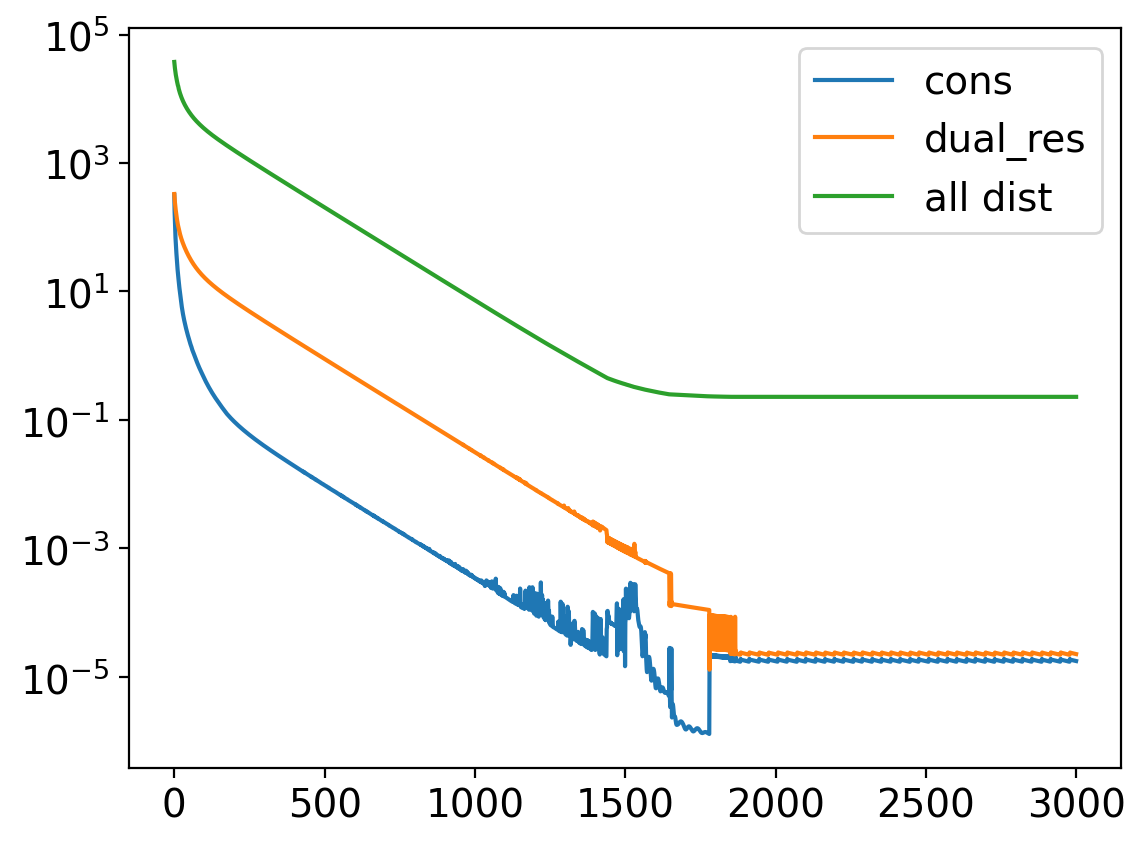

In [79]:
# d0=read_traffic_mat_transport_networks_tntp(traffic_mat_file, metadata).traffic_mat

d0 = l[:, np.newaxis] @ w[np.newaxis, :] / l.sum()
beckmann_model.set_traffic_mat(d0)
f0e = beckmann_model.flows_on_shortest(beckmann_model.graph_props[0])
f0ei = f0e[:, np.newaxis] @ np.ones((1, d0.shape[0])) / d0.shape[0]

admm_times, f_dists, d_dists, cons, dual_res = combined_admm(admm_oracle=admm_oracle,
                                             d0=d0,
                                             f0=f0ei,
                                             solution_corrs=d_ij_best,
                                             solution_flows=flows_e_best,
                                             agd_kwargs=experiment["agd_kwargs"],
                                             salim_kwargs=experiment["salim_kwargs"],
                                             rho=experiment["admm_rho"],
                                             iters=experiment["admm_iters"] * 30, )

experiment["admm_times"] = admm_times
experiment["admm_dists"] = list((np.array(d_dists) ** 2 + np.array(f_dists) ** 2) ** 0.5)

plt.plot(cons, label="cons")
plt.plot(dual_res, label="dual_res")
plt.plot(experiment["admm_dists"], label="all dist")
plt.yscale("log")
_ = plt.legend(), plt.show()

In [336]:
import time

d_ij = traffic_mat.copy()  # maybe init with zeros or 1-rank approx?
# d_ij = np.ones(traffic_mat.shape)
# d_ij = l[:, np.newaxis] @ w[np.newaxis, :] / l.sum()

rho = 0.1 

y = np.zeros(traffic_mat.shape)

f_dist, d_dist, cons, dual_res = [], [], [], []
f_dual_feas, d_dual_feas = [], []
lam, mu = None, None

# TODO: reuse previous solution as starting point for subproblems, terminate by crit. 

flows_ei, y_salim = None, None
start = time.time()
admm_times = []
for k in tqdm(range(450)):
#     print("time passed:", round(time.time() - start), "s")
    
    flows_ei_ = admm_oracle.agd_argmin_flows(d_ij, y, rho, x0=flows_ei, eps_abs=5e-6, iters=1000, M0=10) 
#     if k > 0:
#         print("flows change norm", np.linalg.norm(flows_ei_ - flows_ei))
    flows_ei = flows_ei_

    d_ij_, y_salim = admm_oracle.salim_argmin_corrs(y_admm=y, flows_ei=flows_ei, eps_abs=1e-5,
                                                    rho=rho, x0=d_ij, y0=y_salim,
                                                    mu=0.01, L=1, iters=1000) 
#     print("corrs change norm", np.linalg.norm(d_ij - d_ij_))
    dual_res.append(rho * np.linalg.norm(admm_oracle.ATmul(admm_oracle.Bmul(d_ij - d_ij_))))
    d_ij = d_ij_
    
    Bd_plus_Af = admm_oracle.Amul(flows_ei) + admm_oracle.Bmul(d_ij)
    y += rho * Bd_plus_Af
    
    admm_times.append(time.time() - start)
    f_dist.append(np.linalg.norm(flows_e_best - flows_ei.sum(axis=1)))
    d_dist.append(np.linalg.norm(d_ij_best - d_ij))
    
    cons.append(np.linalg.norm(Bd_plus_Af))  # primal residual
    
#     print("\n", k)
#     print(f"flows dist={f_dist[-1]}, corrs dist={d_dist[-1]}")
#     print(f"constraint={cons[-1]}", f"optimality={dual_res[-1]}", "\n")

/tmp/ipykernel_27843/1017970501.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  incidence_mat = nx.incidence_matrix(graph, oriented=True).todense()
100%|██████████| 450/450 [00:16<00:00, 27.57it/s] 


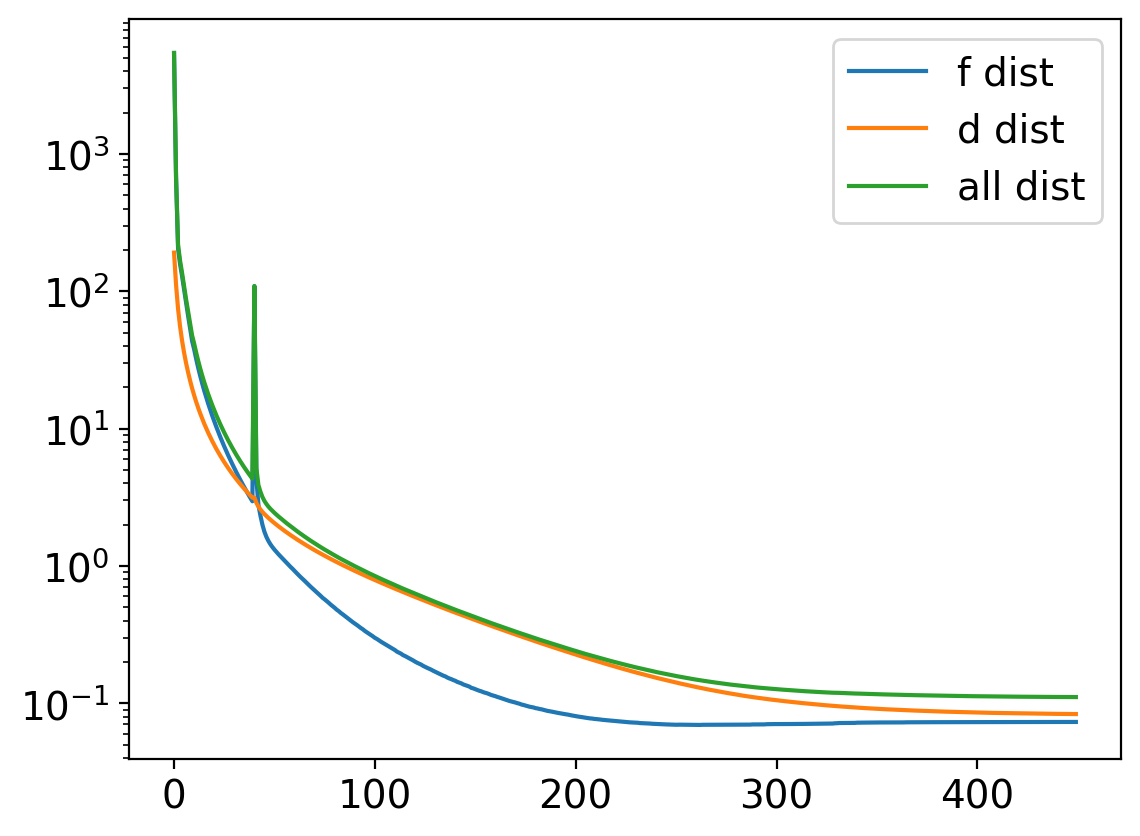

In [337]:
plt.plot(f_dist, label="f dist")
plt.plot(d_dist, label="d dist")
admm_dists = (np.array(d_dist) ** 2 + np.array(f_dist) ** 2) ** 0.5
plt.plot(admm_dists, label="all dist")
plt.yscale("log")
# plt.xscale("log")
plt.legend()
plt.show()

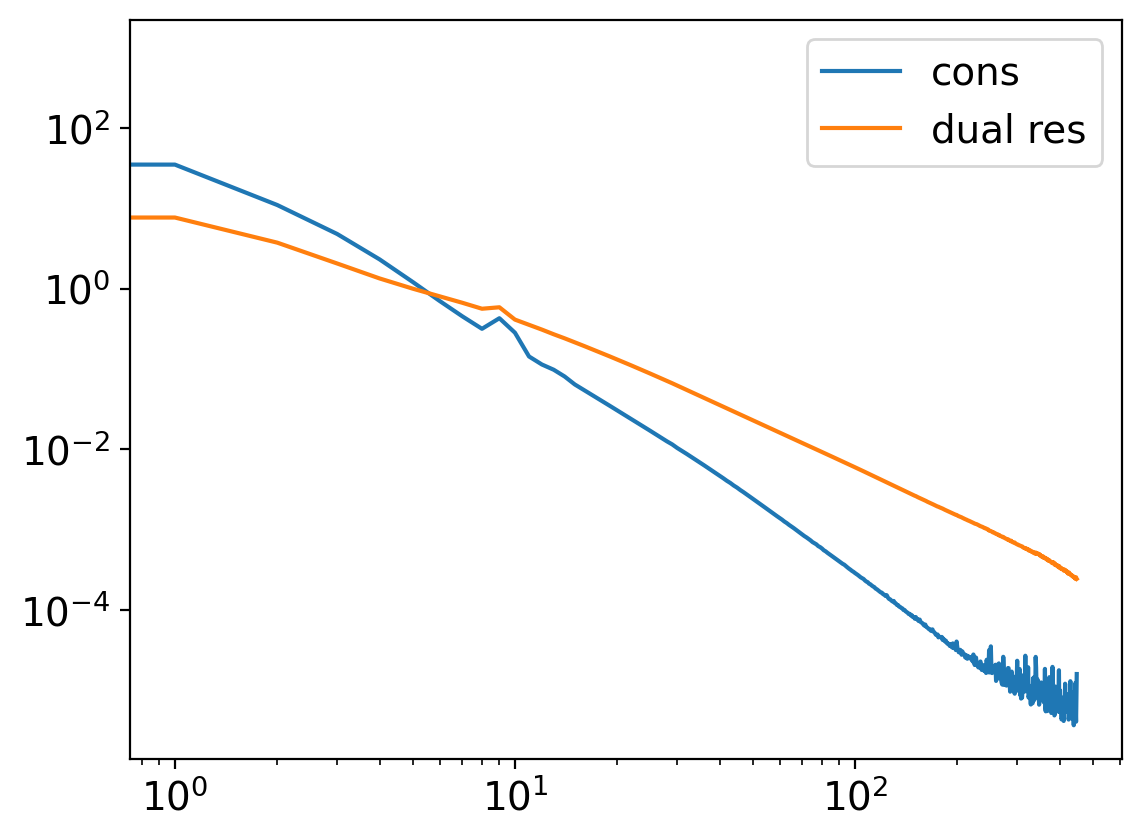

In [328]:
plt.plot(cons, label="cons")
plt.plot(dual_res, label="dual res")
plt.legend()
plt.yscale("log")
plt.xscale("log")


flows agd: 29882.807260736863 M= 5.0e+01
flows agd: 0.08258447173294199 M= 7.8e-01
flows agd: 0.01876050677762064 M= 1.6e+00
flows agd: 0.006436107020733585 M= 7.8e-01
flows agd: 0.002830855398512112 M= 7.8e-01


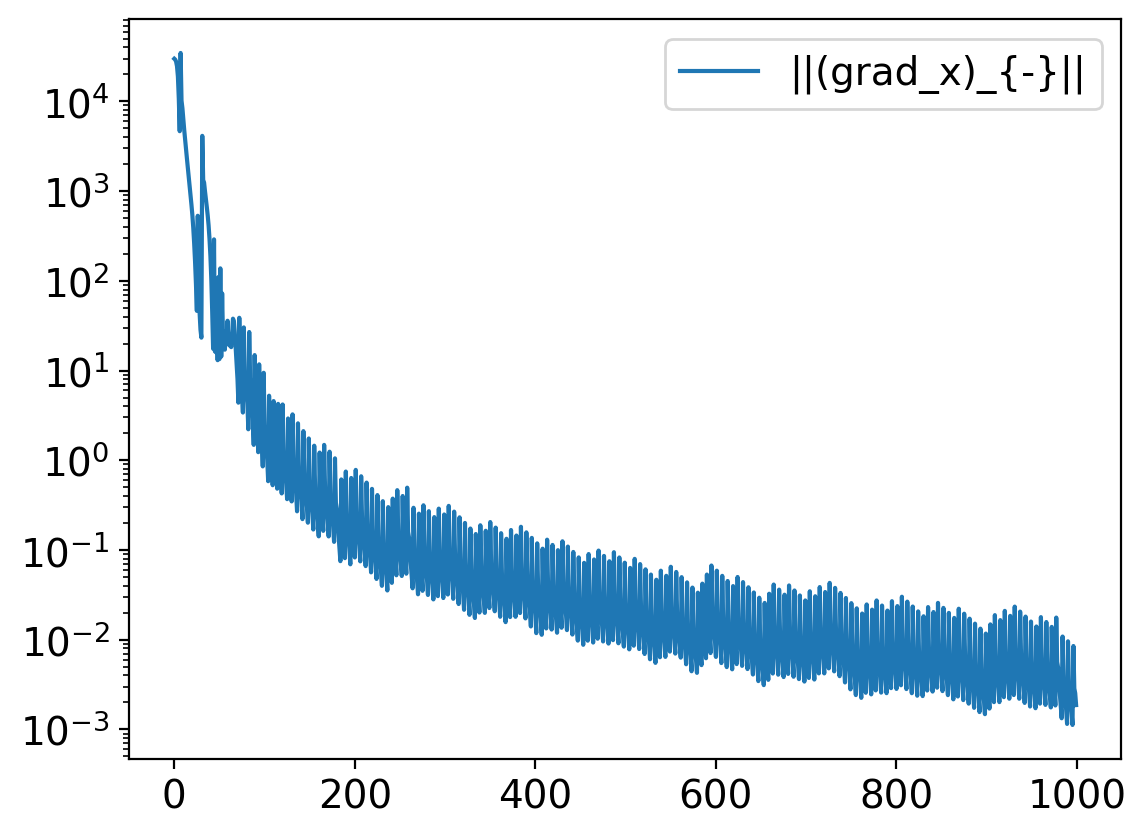

In [26]:
x = admm_oracle.agd_argmin_flows(d_ij, y, rho, iters=1000, M0=100, plot_convergence=True)

0.2
Salim cons=8.743e+05 func=8.395e+05
Salim cons=2.889e+03 func=4.600e+02
Salim cons=1.415e+01 func=1.107e+01
Salim cons=4.314e-01 func=3.423e-01
Salim cons=1.753e-02 func=1.398e-02


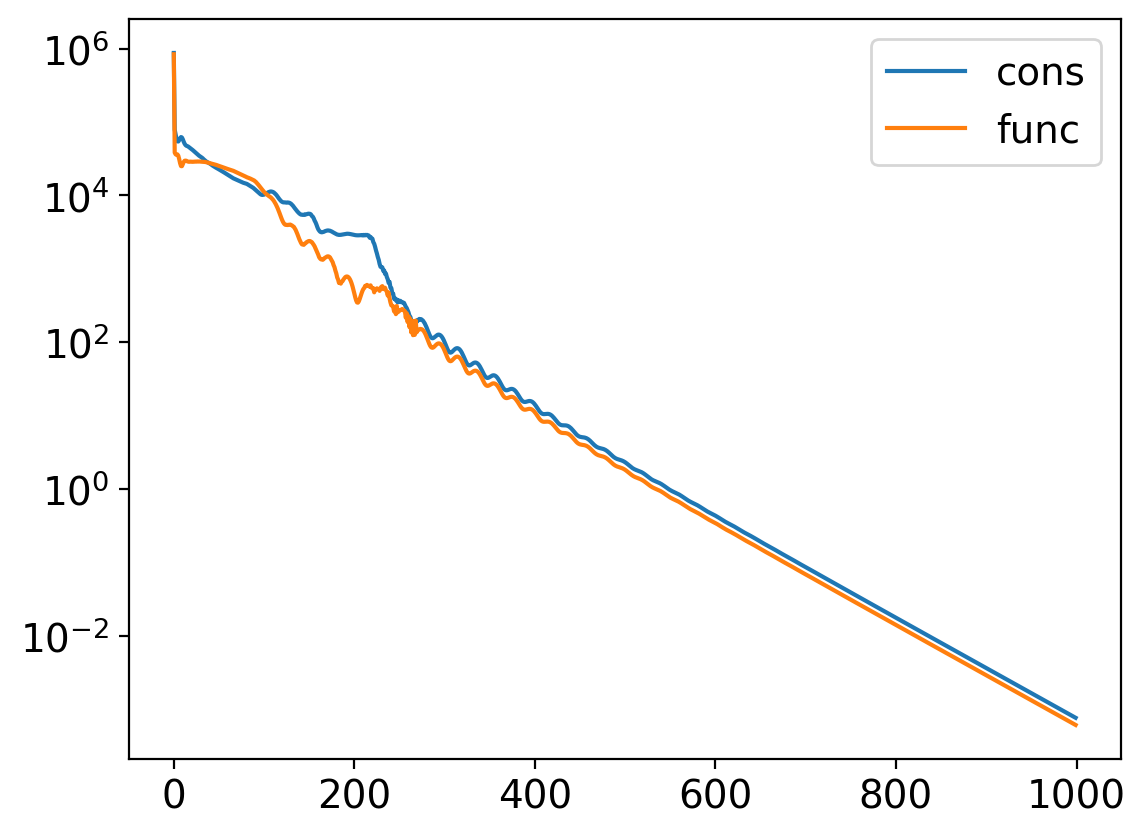

CPU times: user 271 ms, sys: 177 ms, total: 448 ms
Wall time: 260 ms


In [27]:
%%time 
print(rho)
x, y_salim = admm_oracle.salim_argmin_corrs(y_admm=y,
                                      flows_ei=flows_ei,
                                      rho=rho,
                                      mu=1e-3,
                                      L=1,
                                      iters=1000,
                                      plot_convergence=True)